In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math

In [3]:
data = pd.read_json('ibd_admix_data.json')
print(data.head())

    index  number  fraction    u     v   group  true_N  true_T1  true_T2  \
0  [0, 1]   52389  0.992927  0.0  0.35  [0, 0]    5000       30      100   
1  [0, 2]   52549  0.995403  0.0  0.35  [0, 0]    5000       30      100   
2  [0, 3]   51393  0.975364  0.0  0.35  [0, 0]    5000       30      100   
3  [0, 4]   51266  0.964924  0.0  0.35  [0, 0]    5000       30      100   
4  [0, 5]   51637  0.982030  0.0  0.35  [0, 0]    5000       30      100   

   true_T3  
0     1000  
1     1000  
2     1000  
3     1000  
4     1000  


In [4]:
#Sanity Check if the fraction sums to one.
data['index'] = data['index'].apply(tuple)
data['group'] = data['group'].apply(tuple)
data.groupby(['index'])['fraction'].sum()

index
(0, 1)      1.0
(0, 2)      1.0
(0, 3)      1.0
(0, 4)      1.0
(0, 5)      1.0
           ... 
(76, 78)    1.0
(76, 79)    1.0
(77, 78)    1.0
(77, 79)    1.0
(78, 79)    1.0
Name: fraction, Length: 3160, dtype: float64

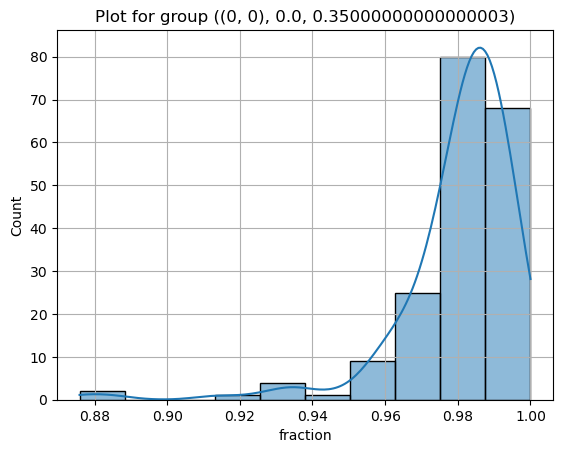

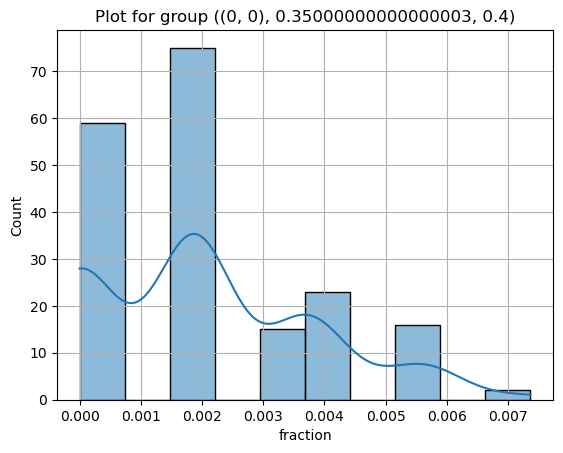

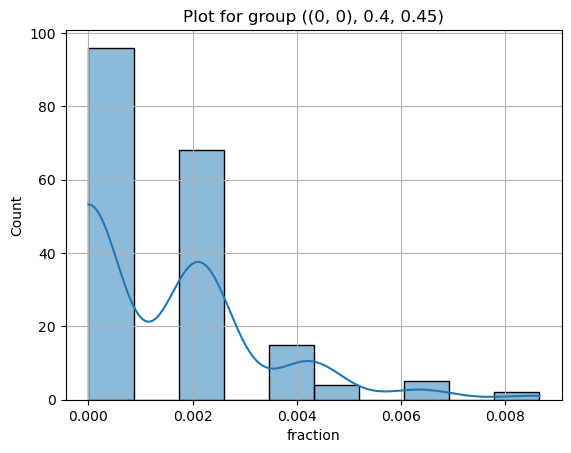

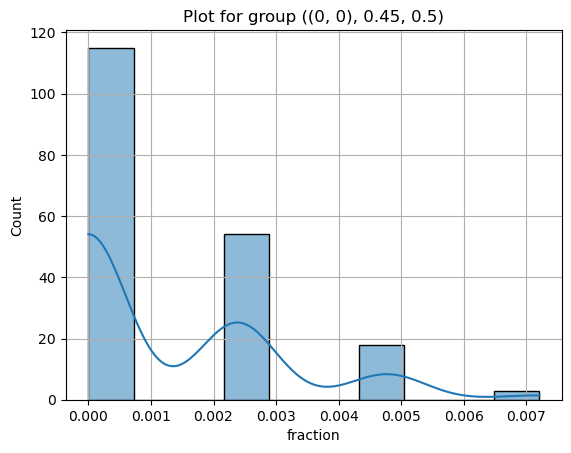

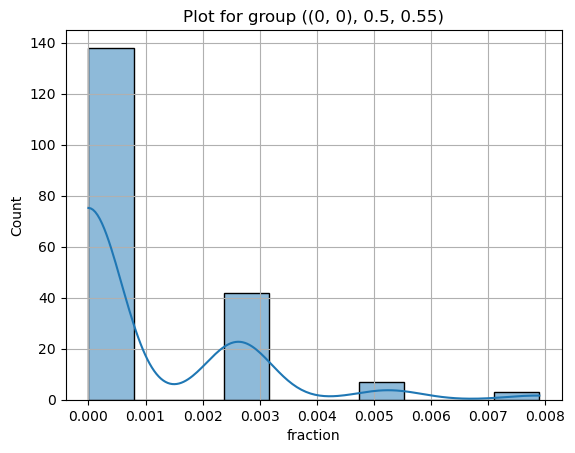

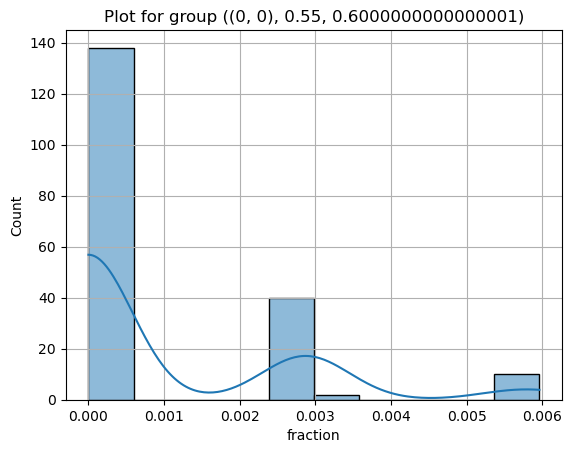

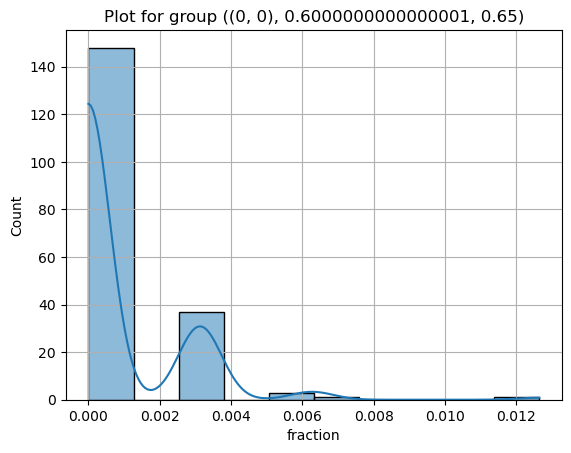

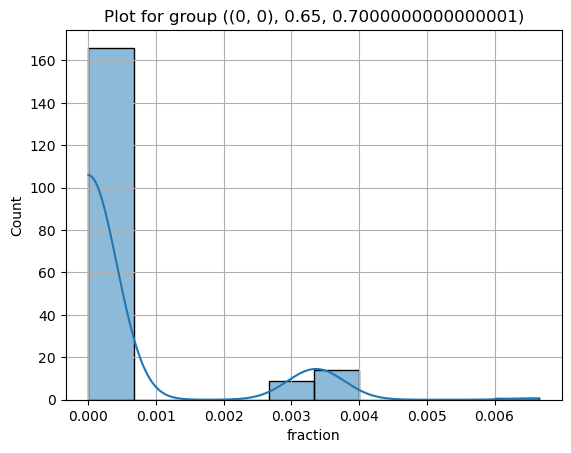

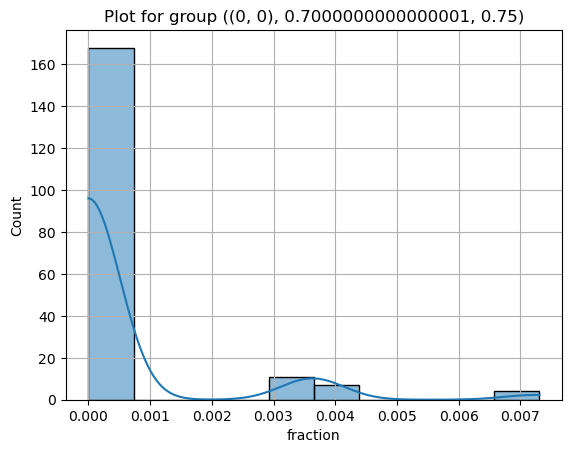

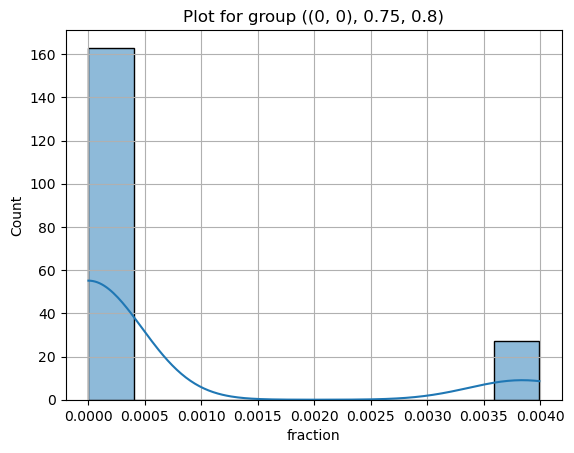

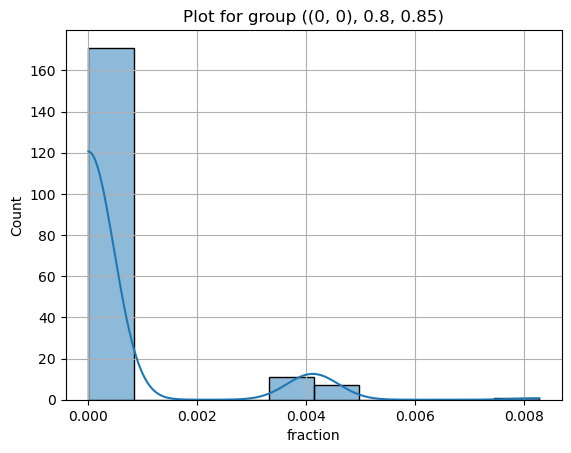

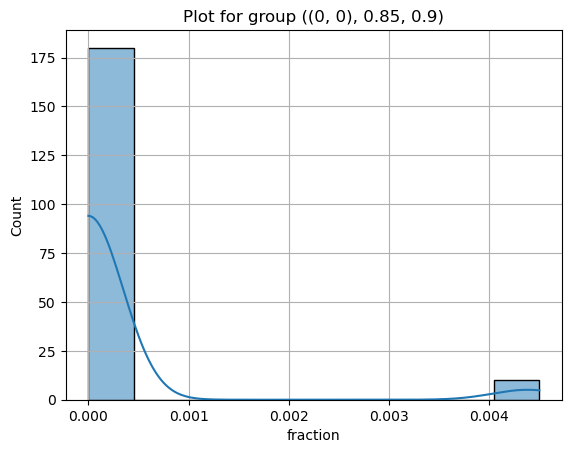

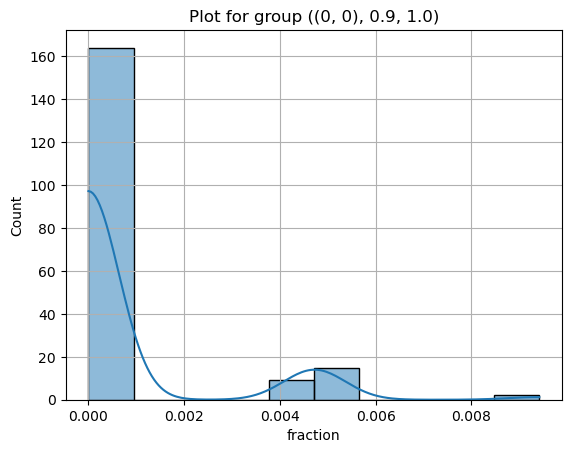

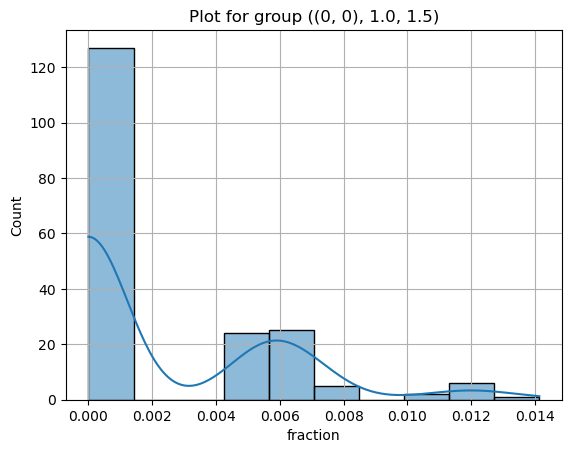

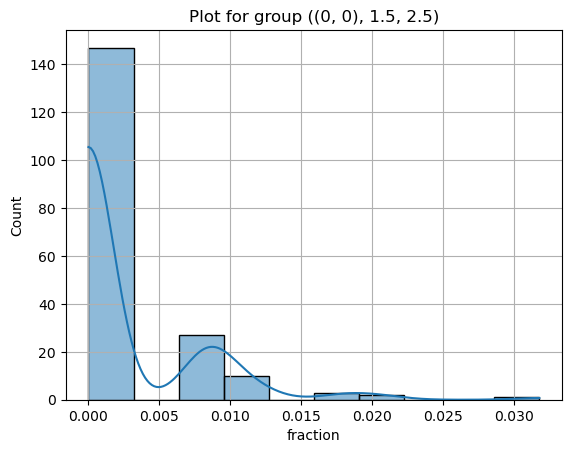

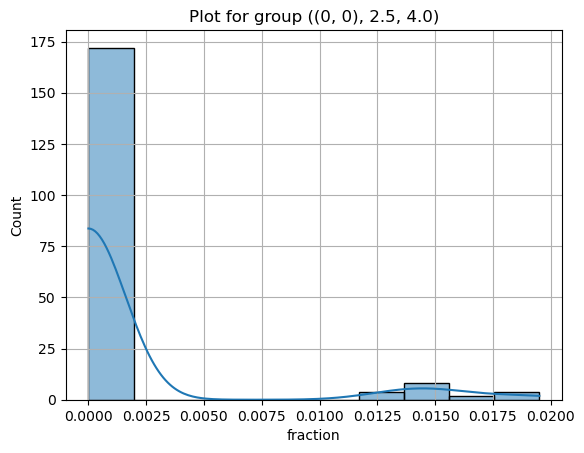

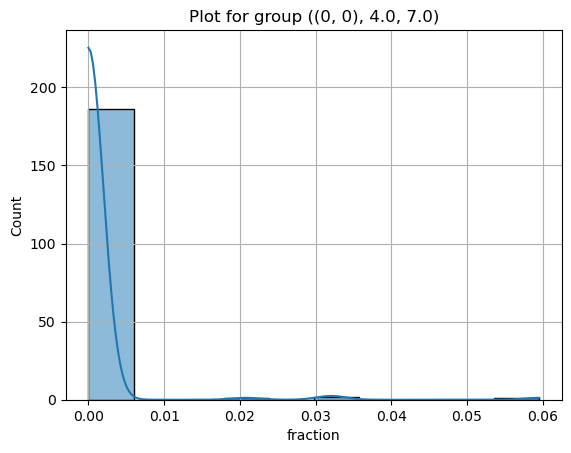

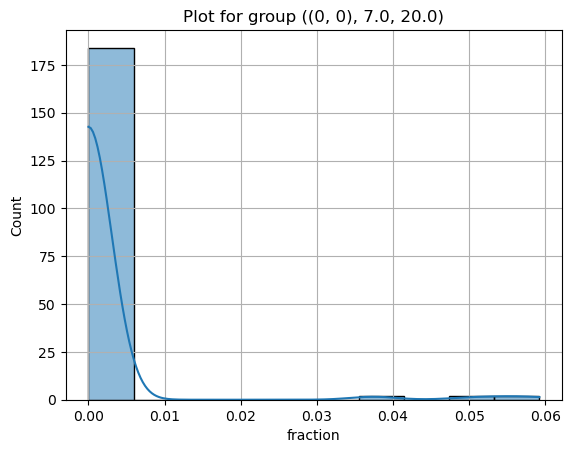

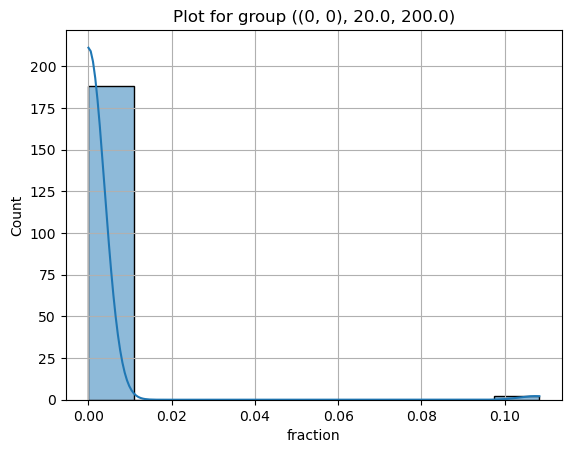

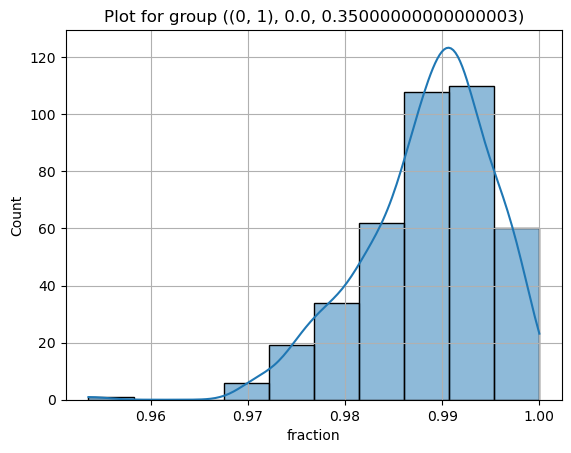

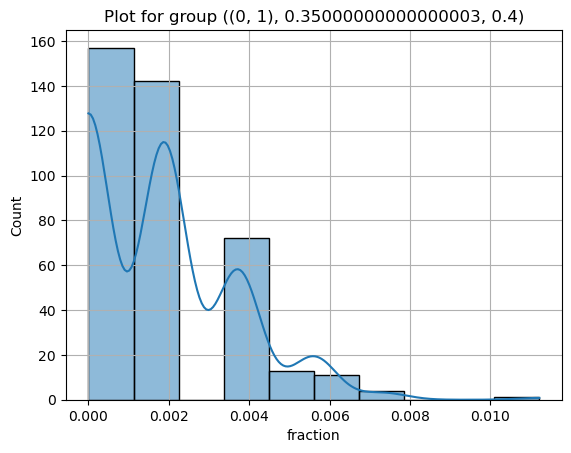

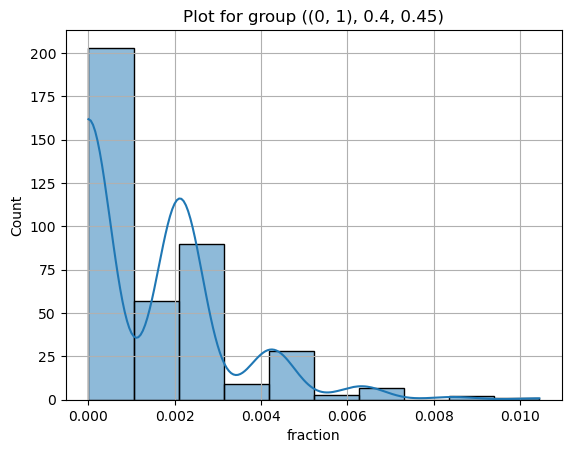

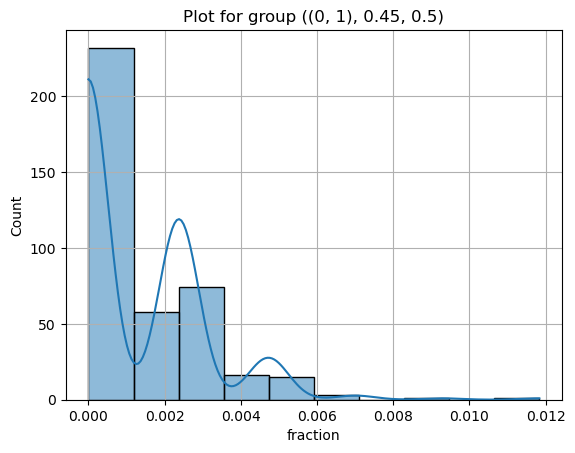

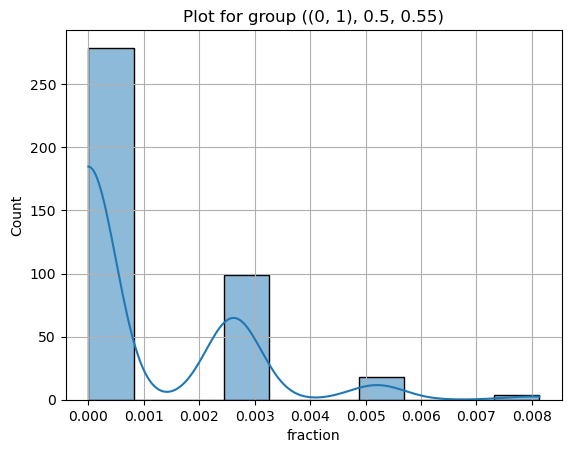

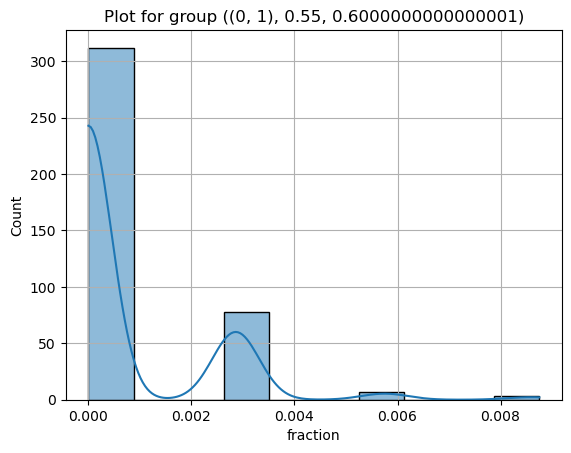

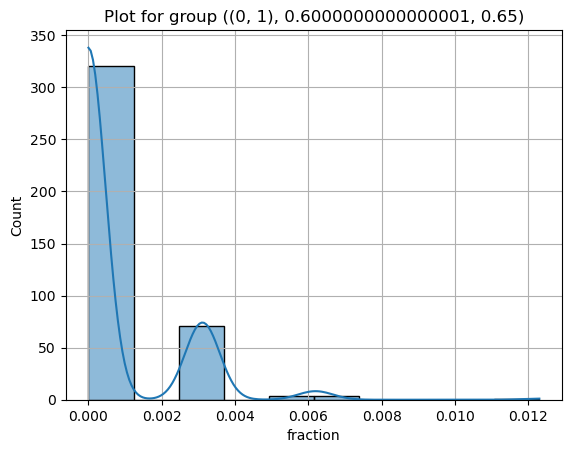

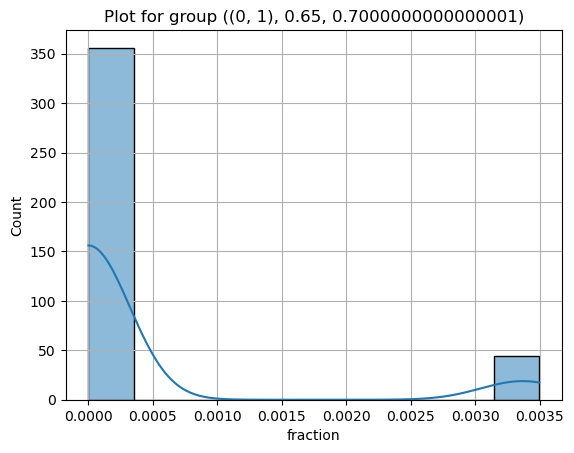

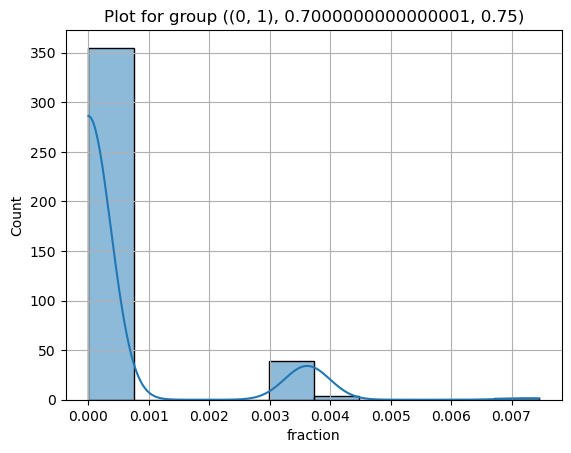

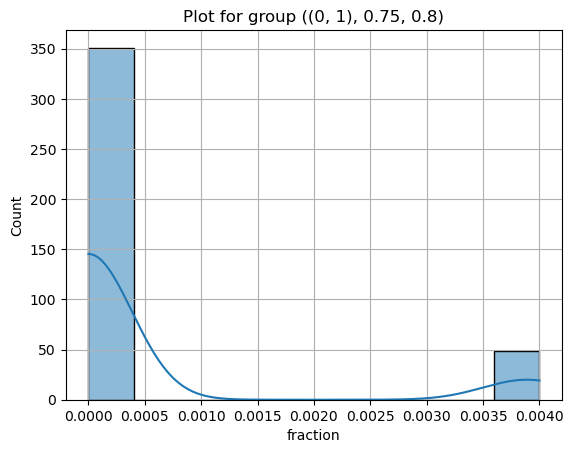

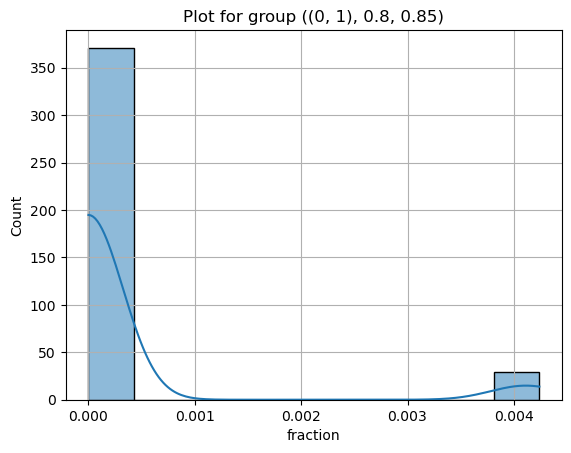

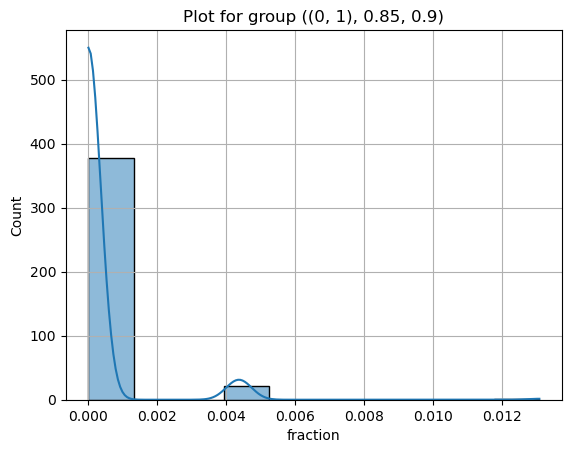

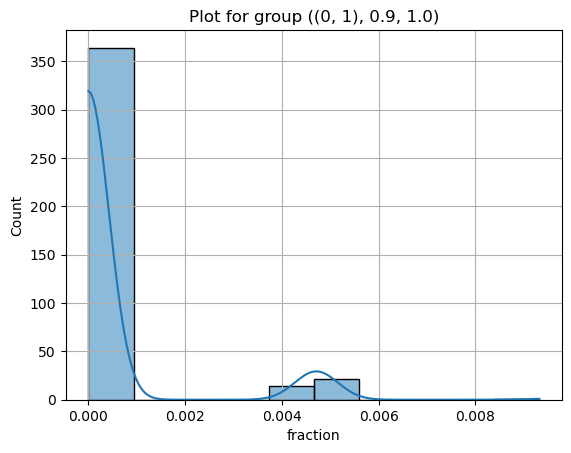

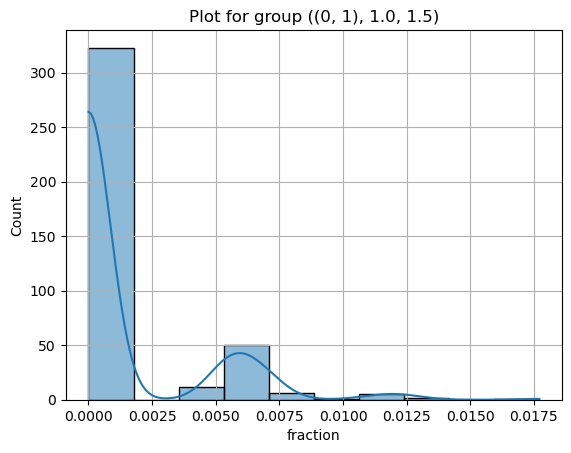

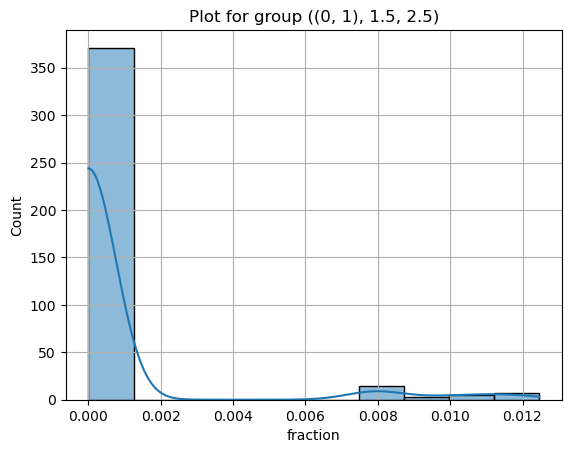

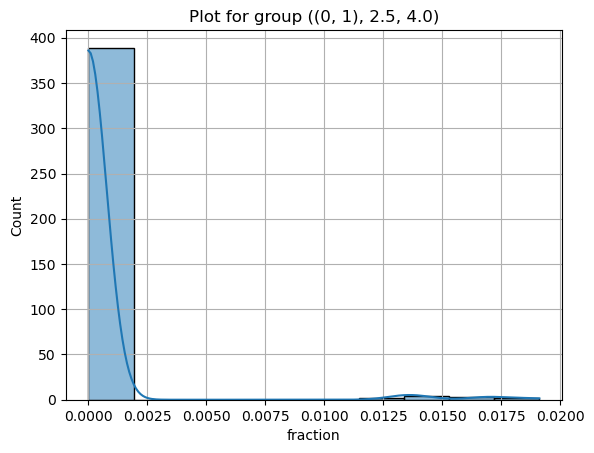

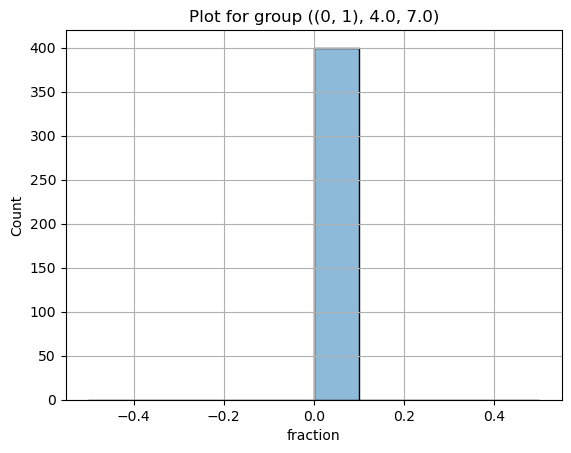

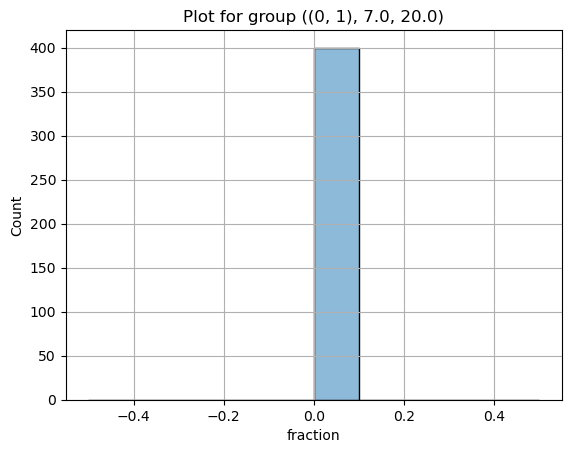

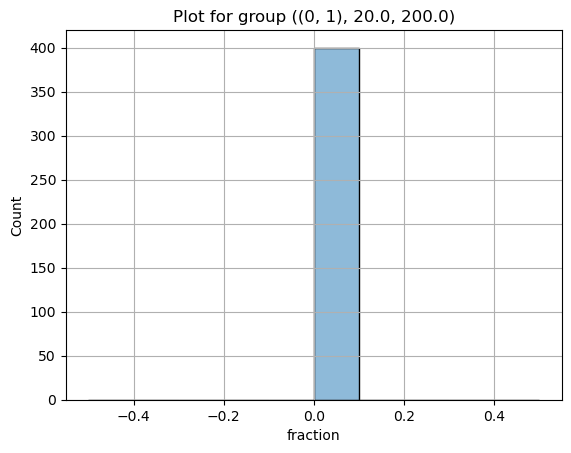

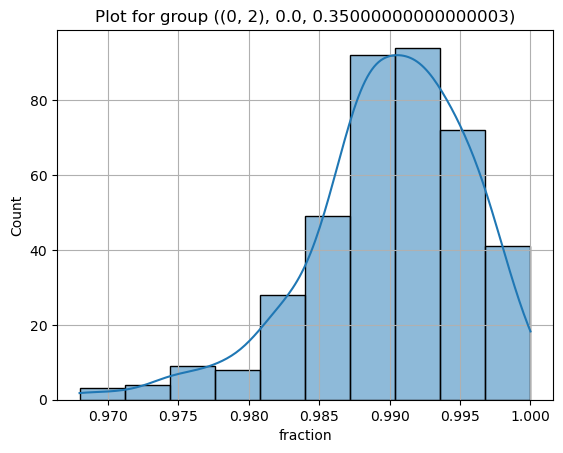

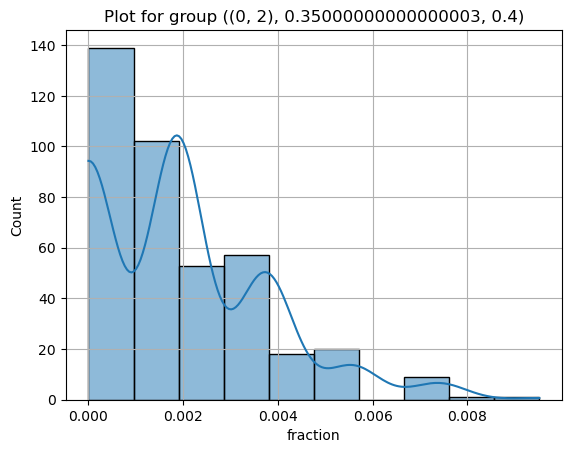

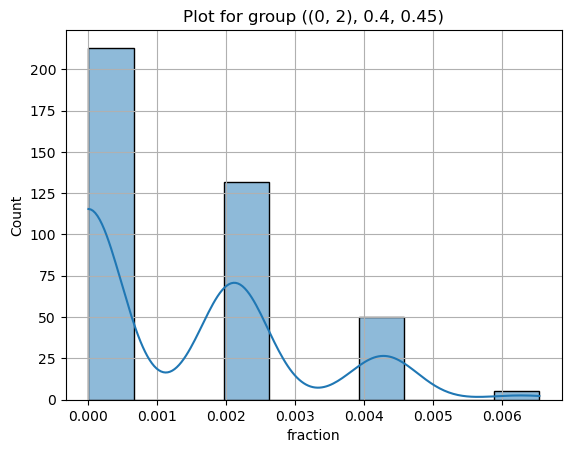

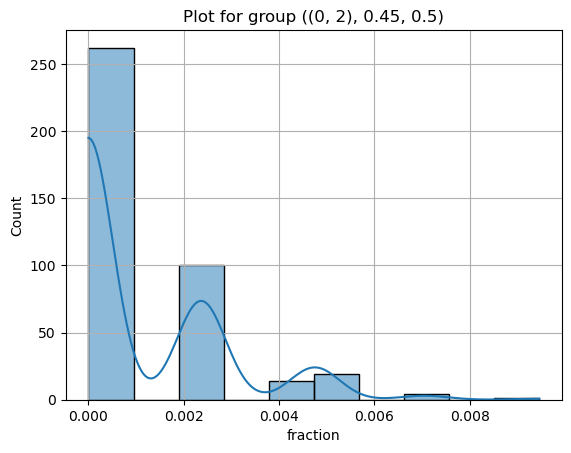

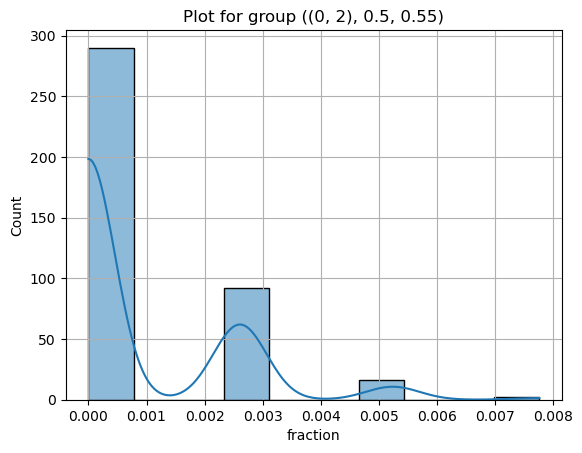

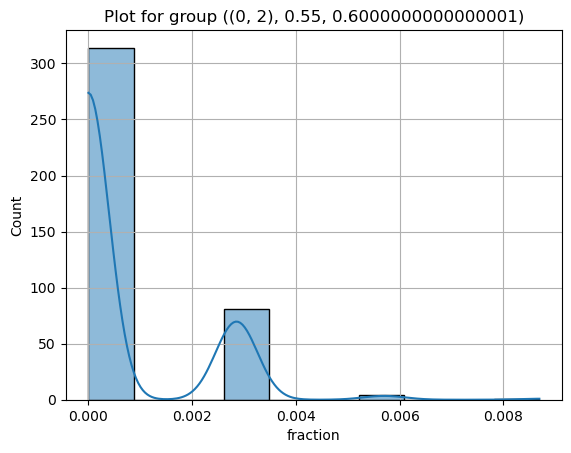

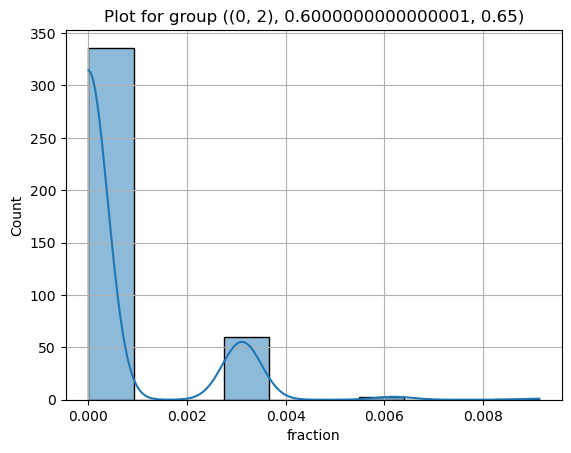

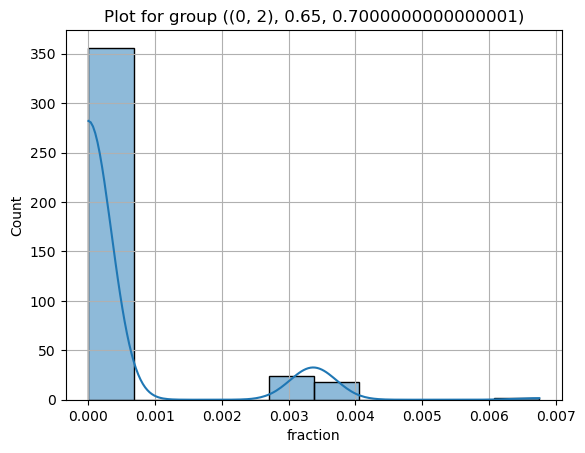

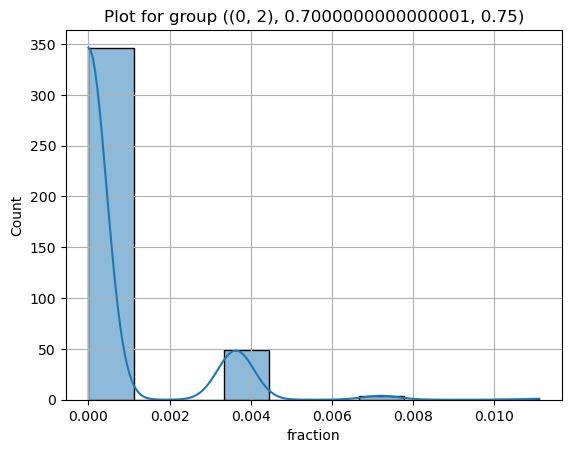

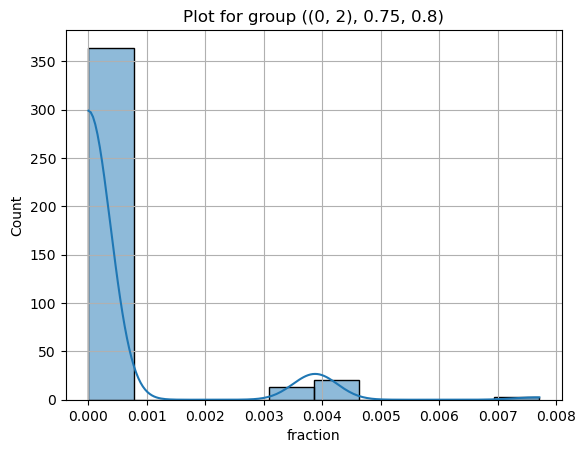

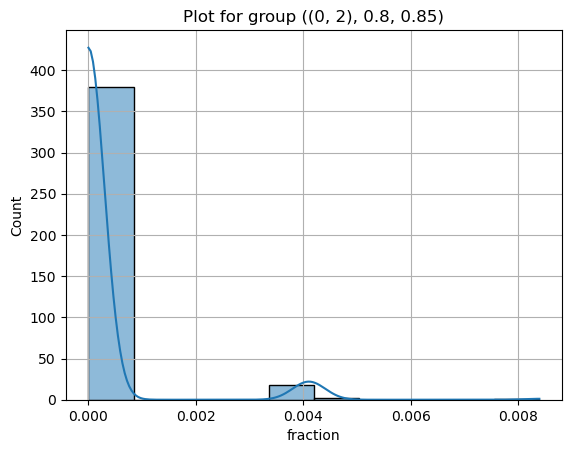

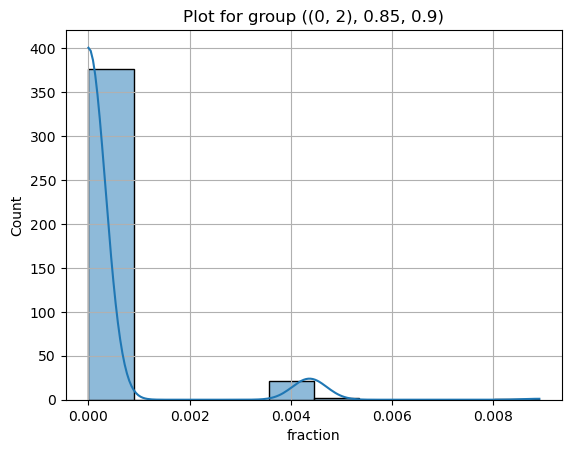

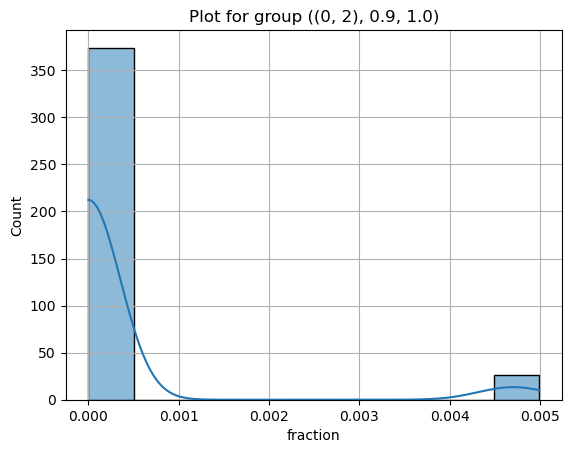

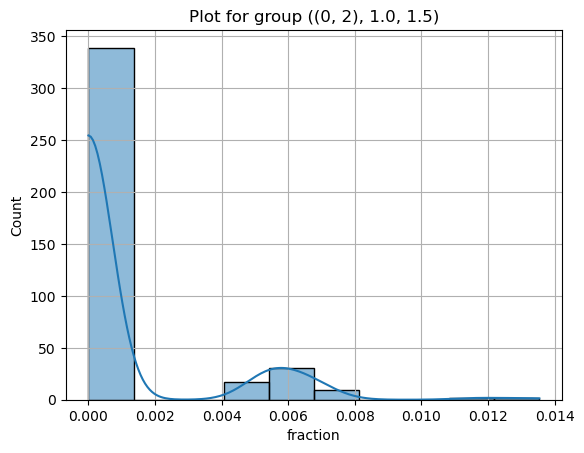

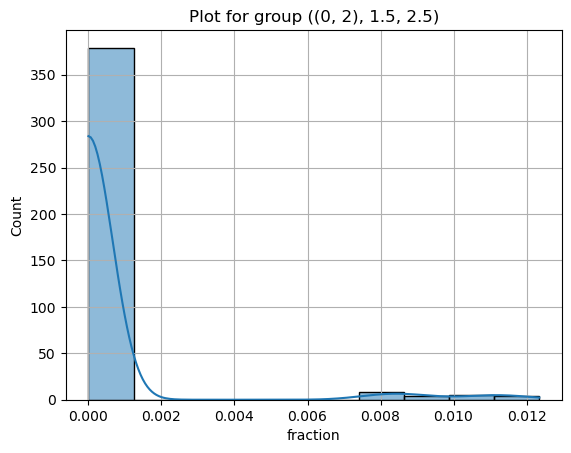

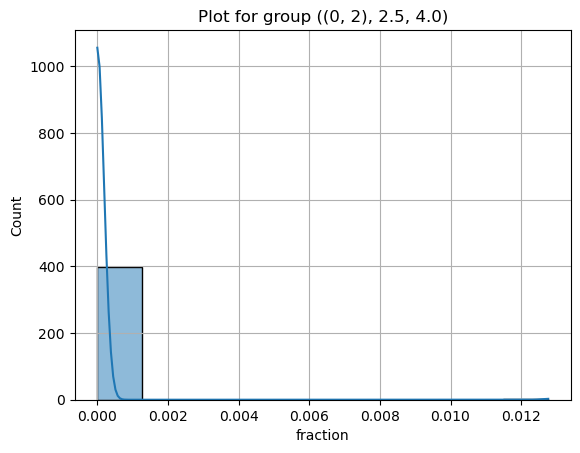

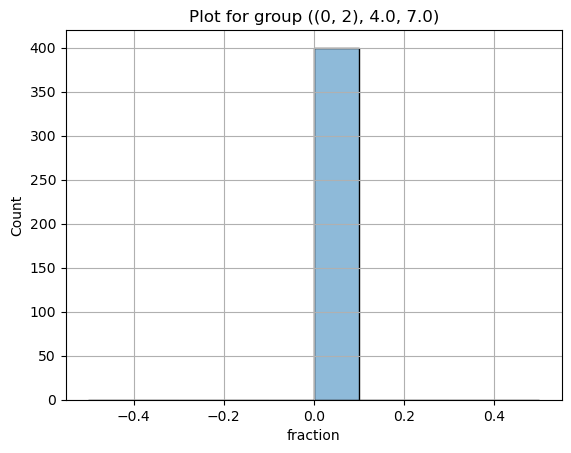

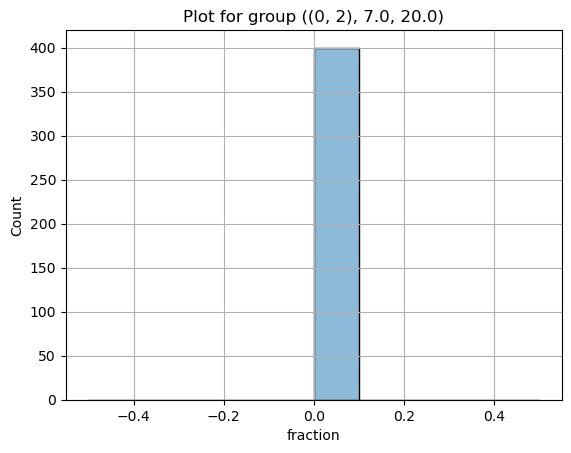

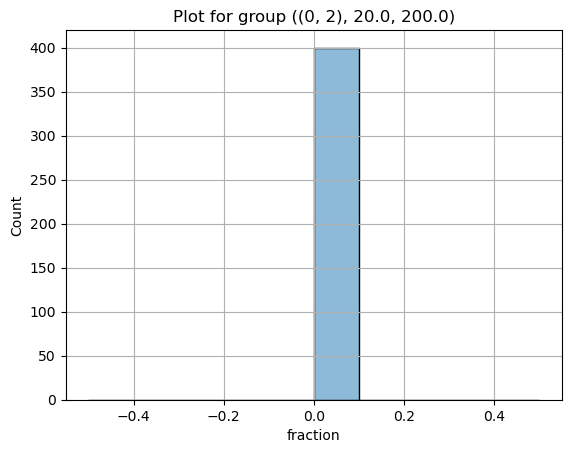

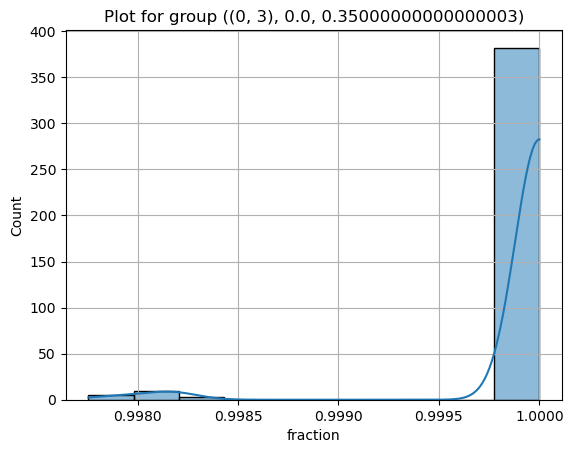

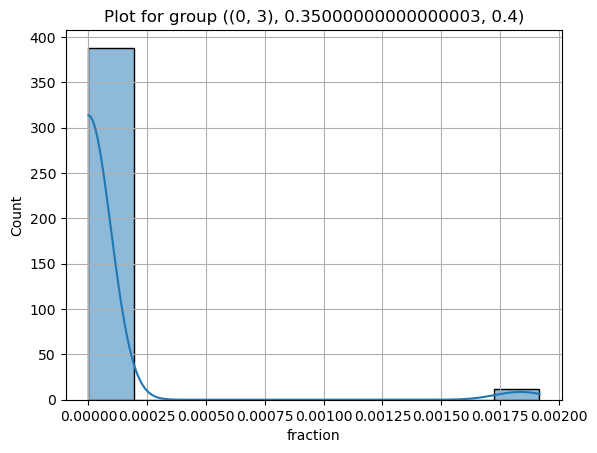

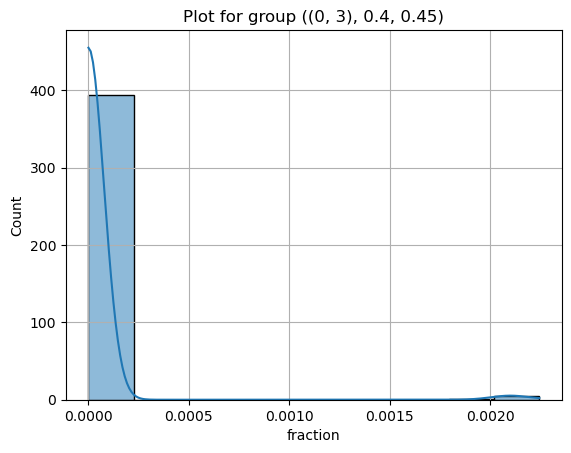

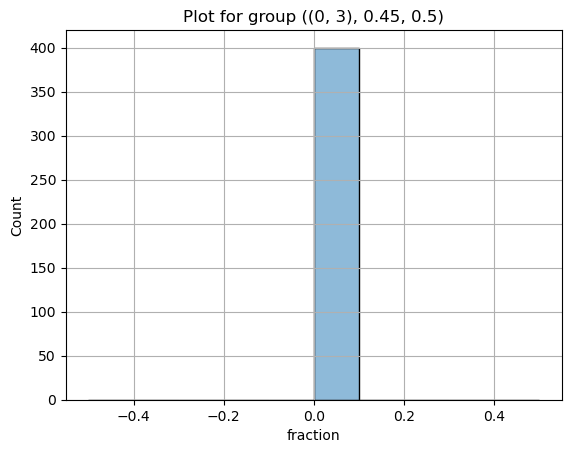

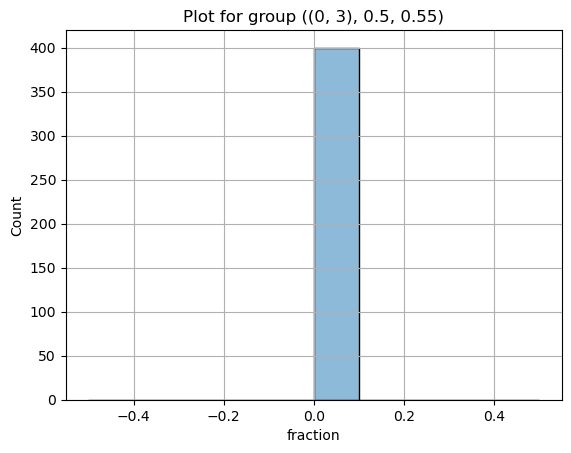

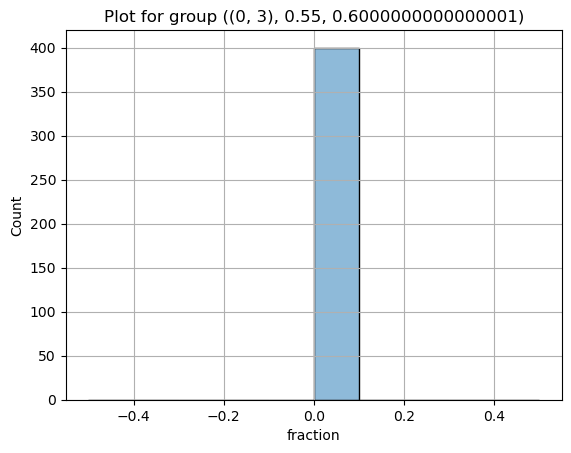

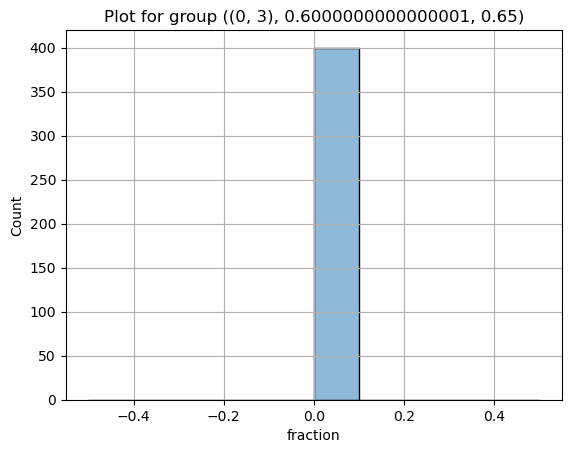

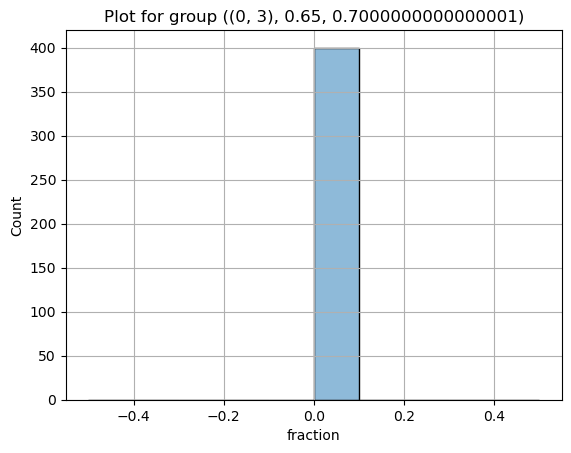

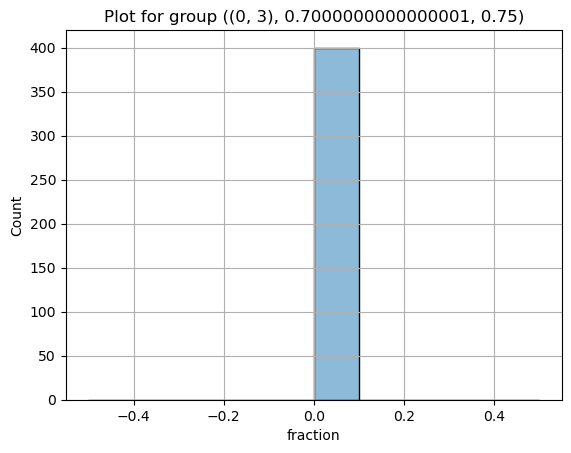

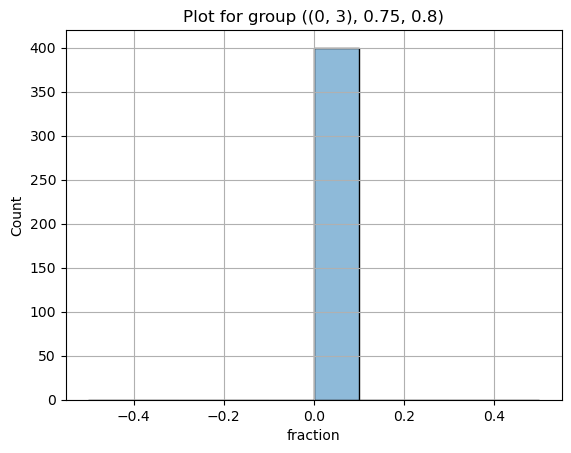

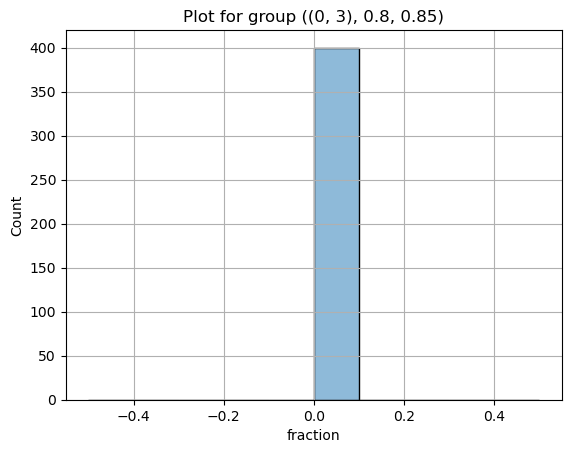

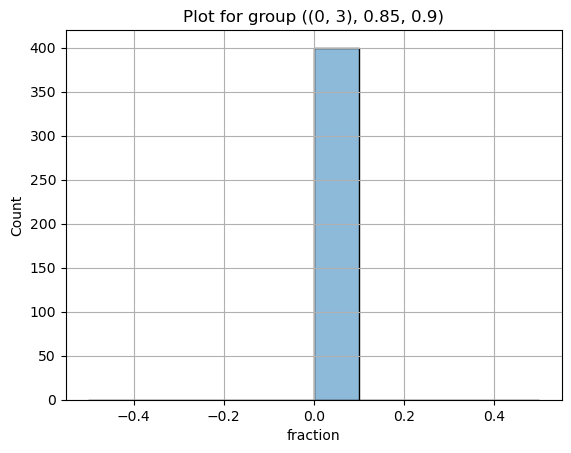

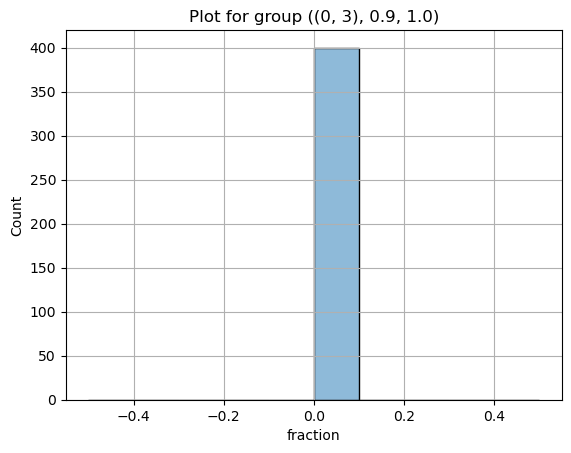

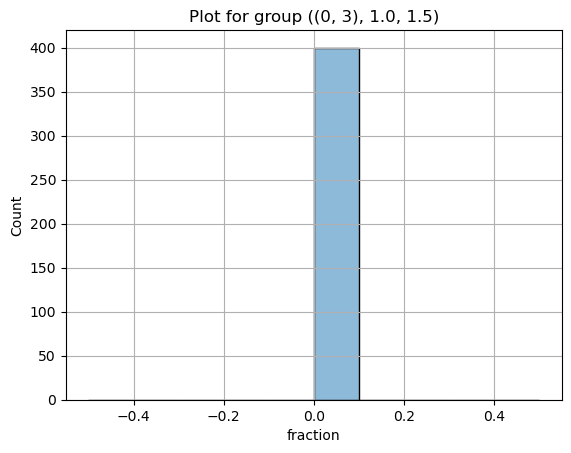

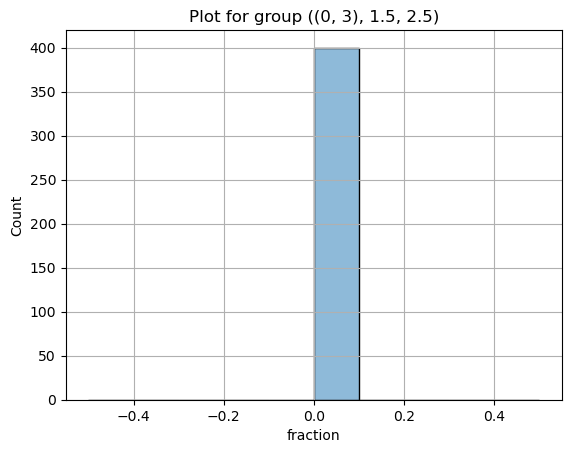

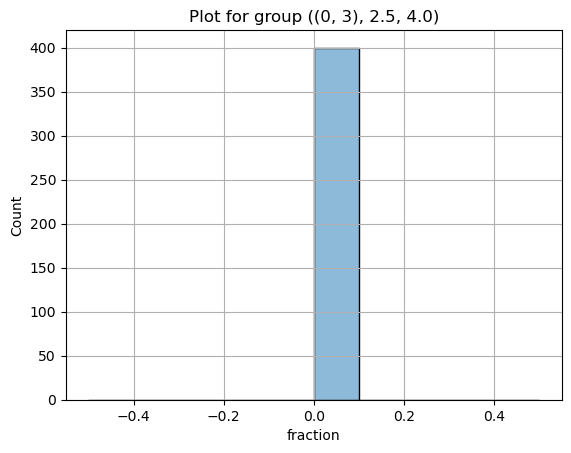

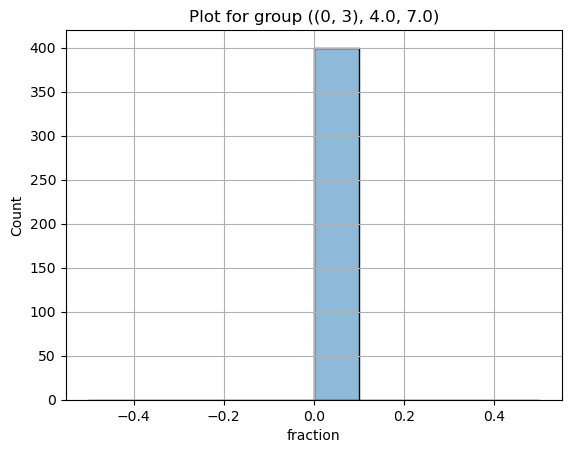

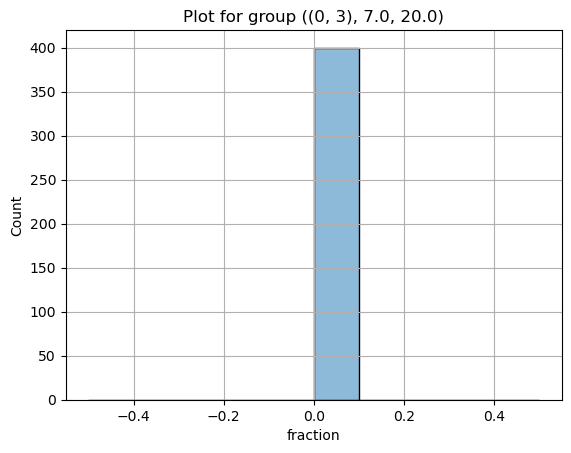

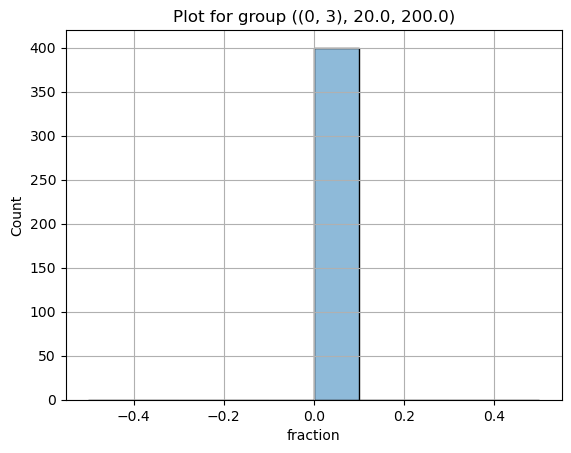

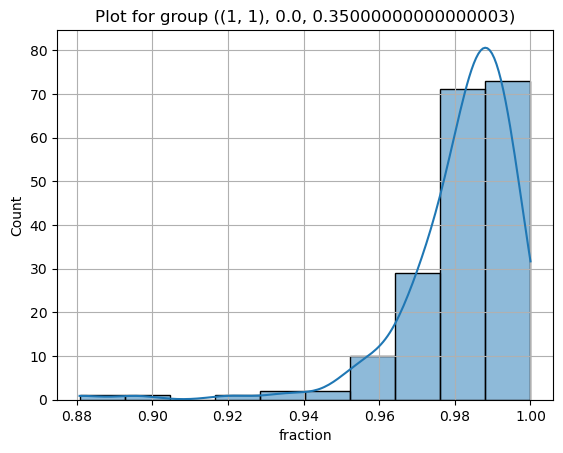

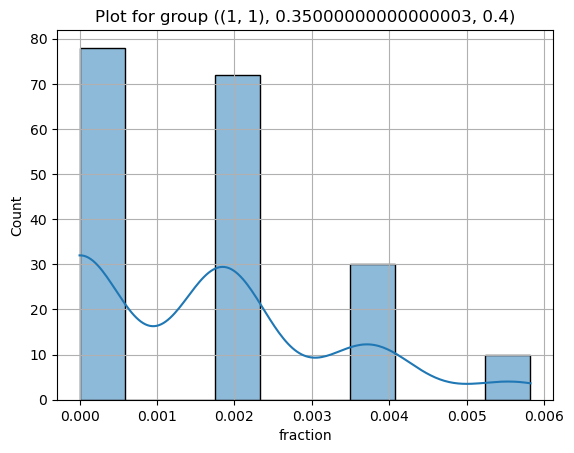

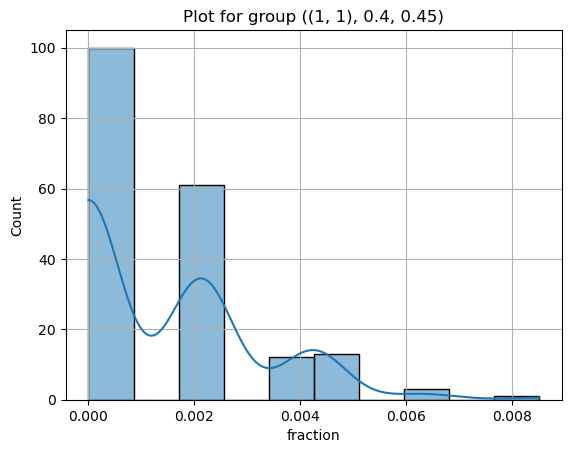

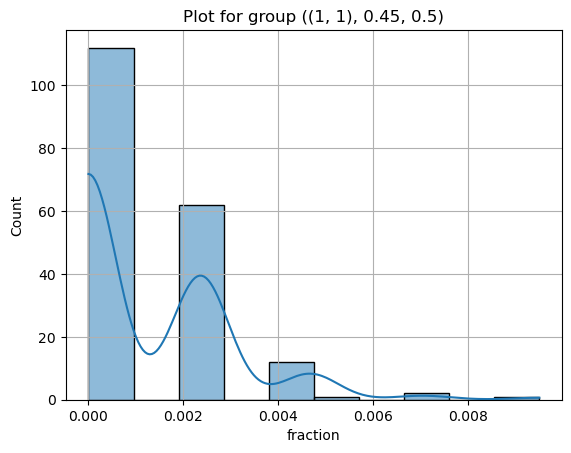

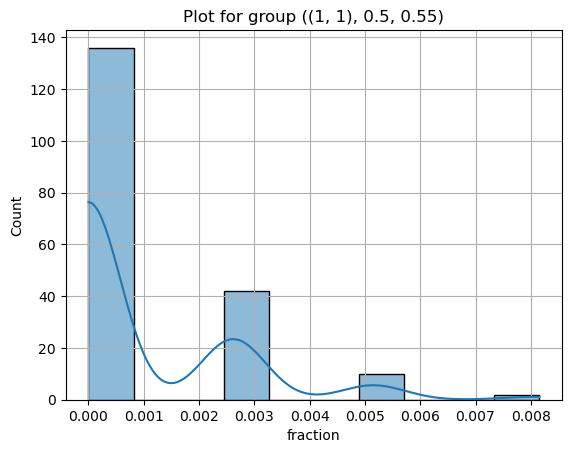

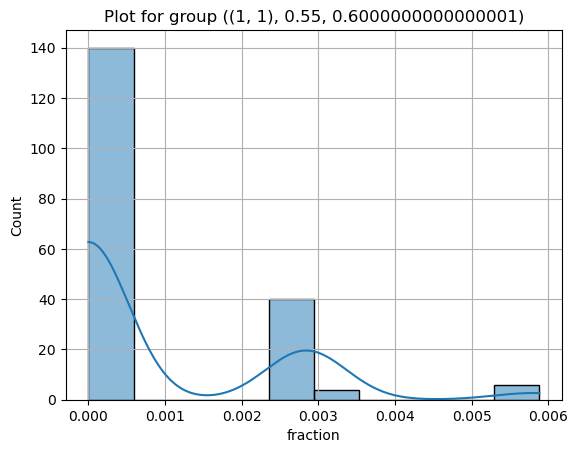

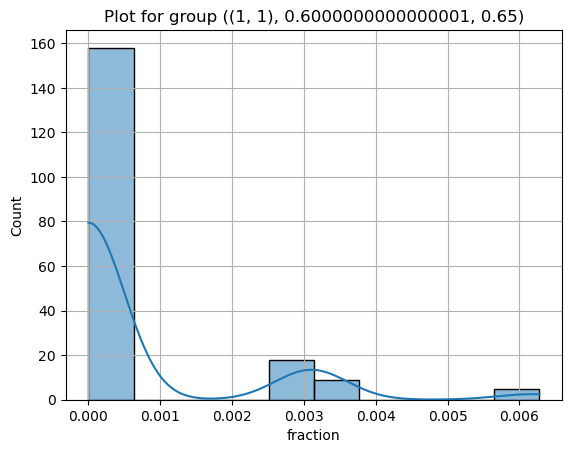

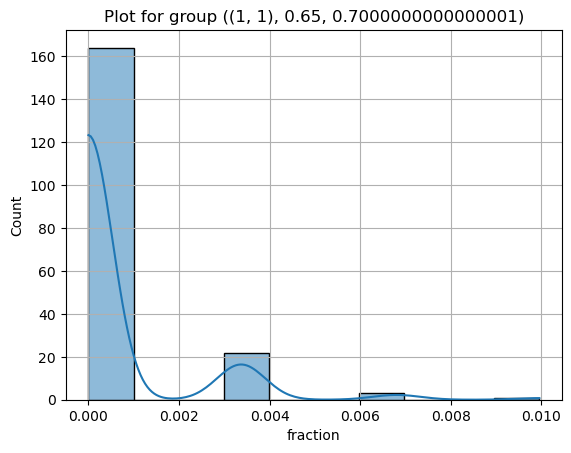

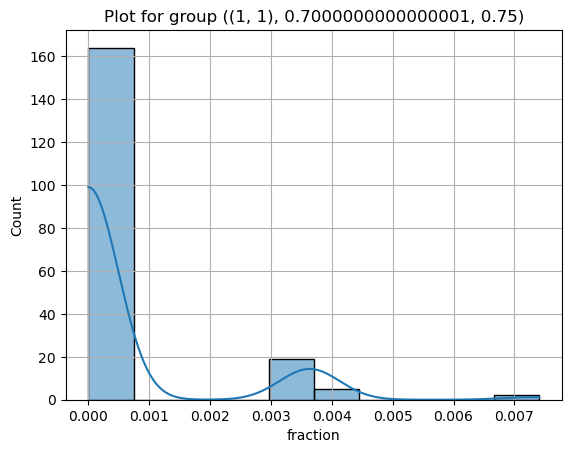

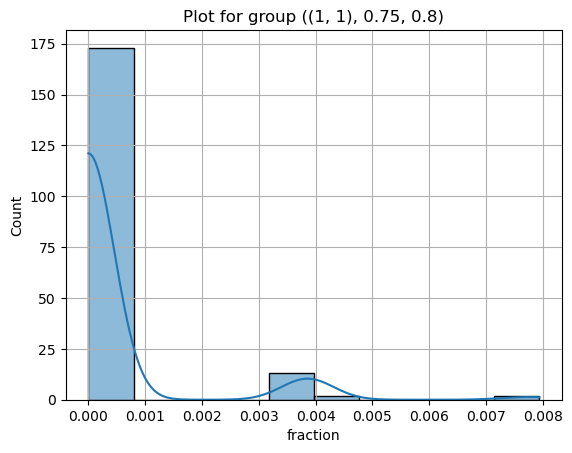

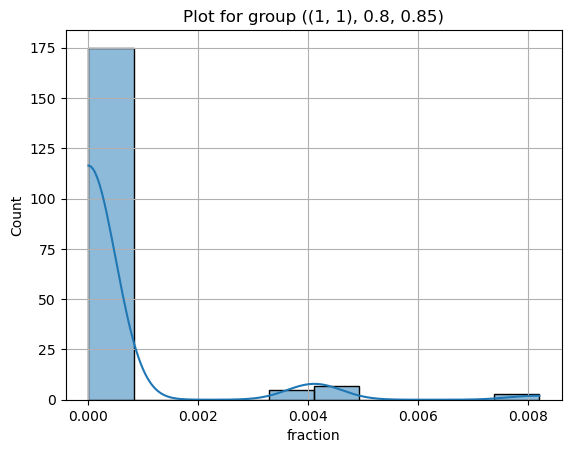

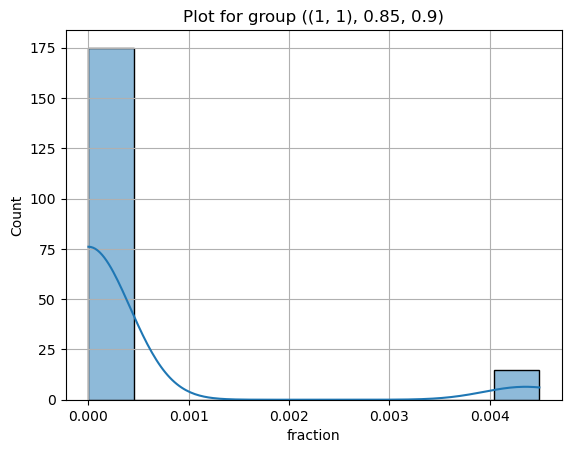

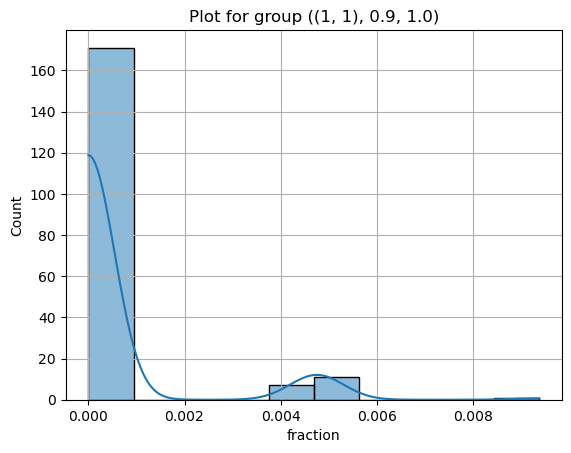

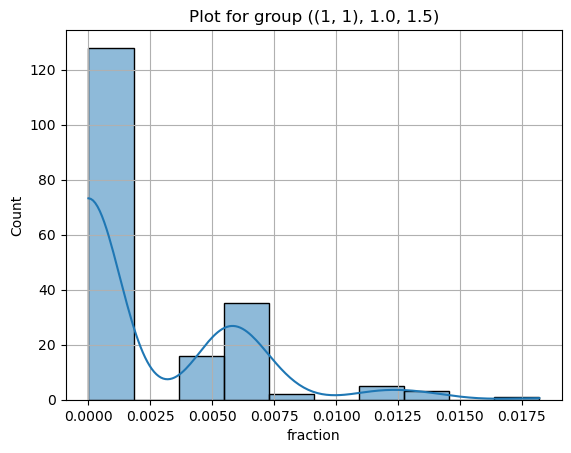

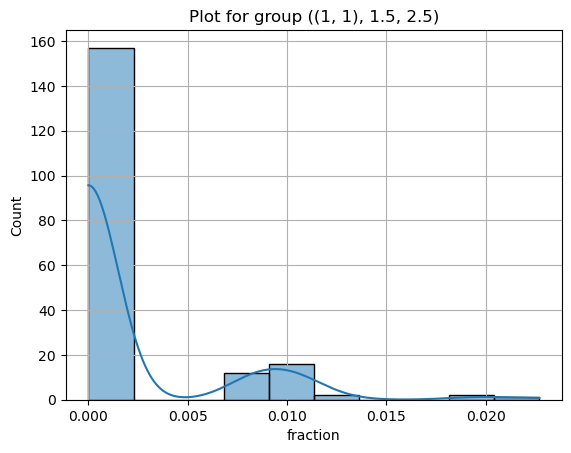

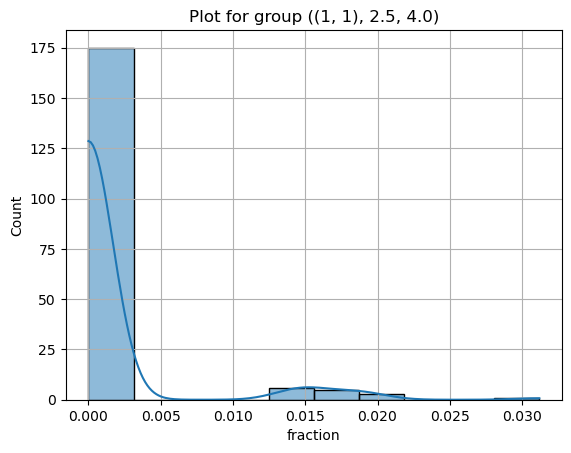

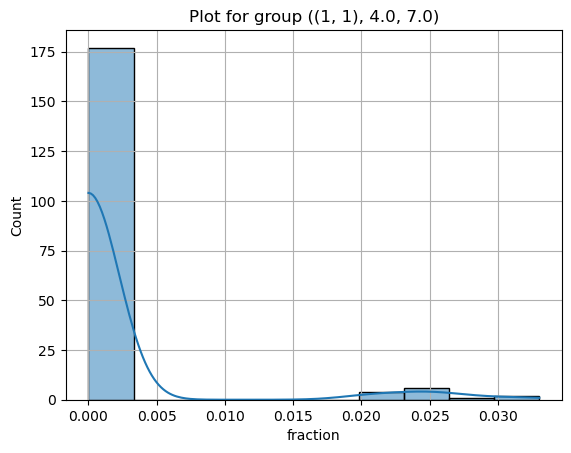

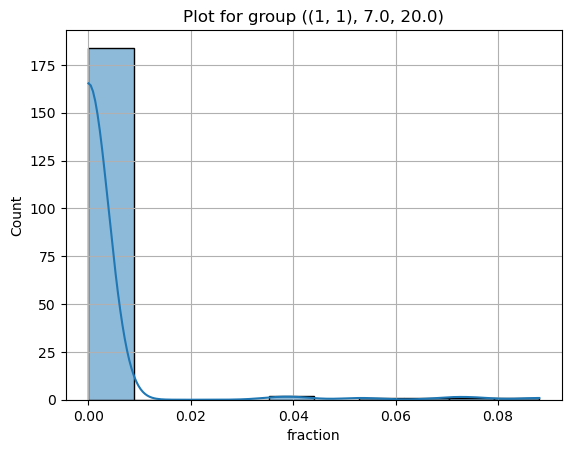

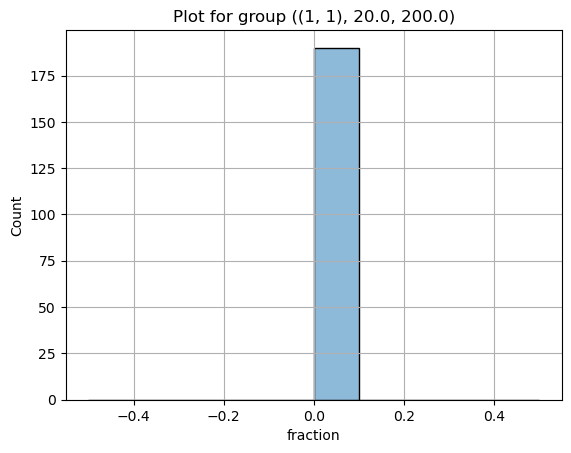

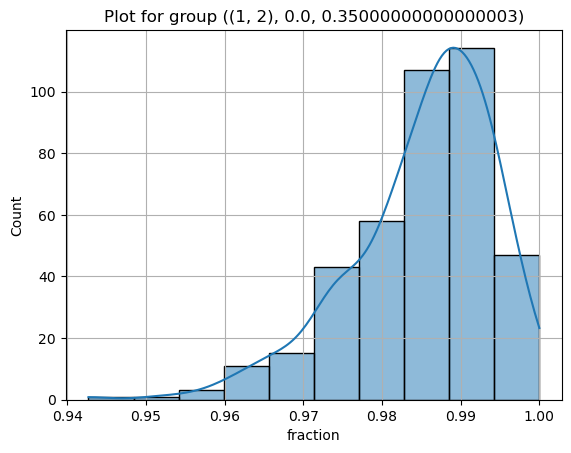

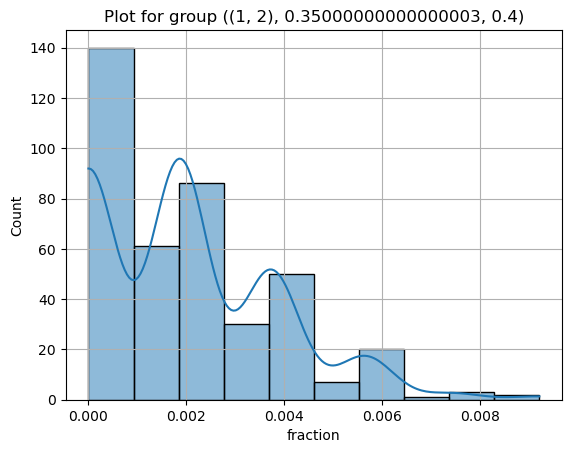

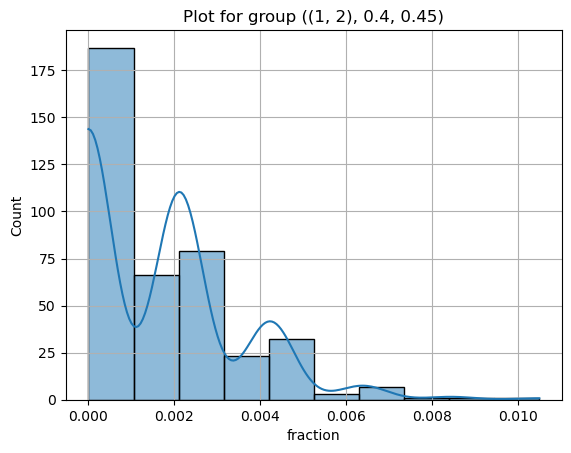

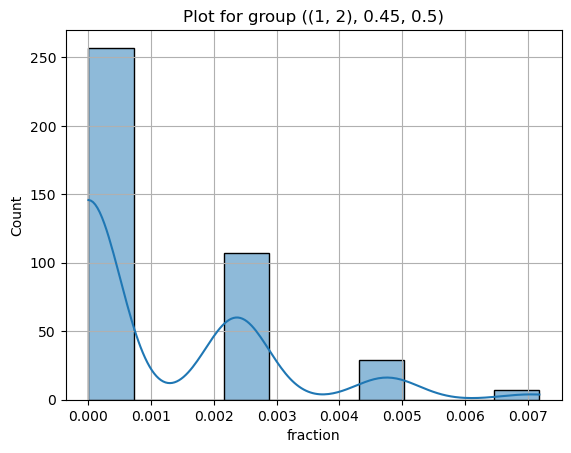

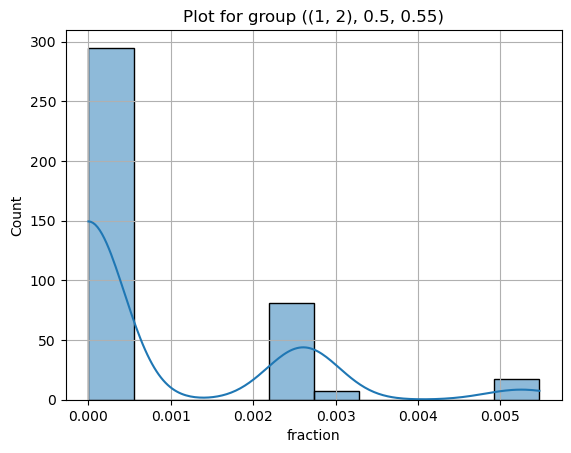

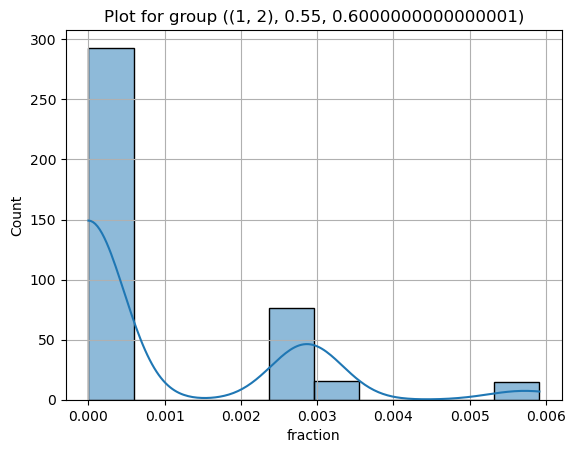

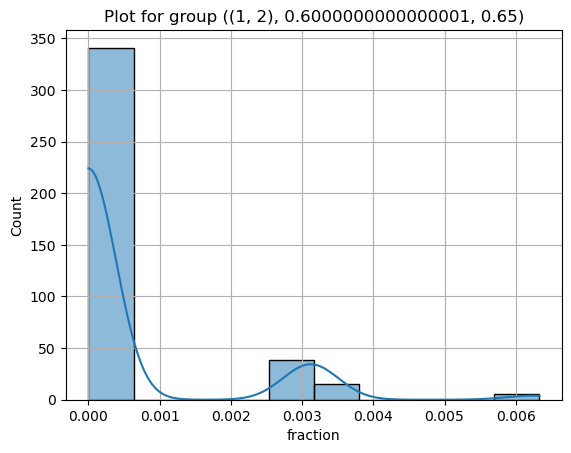

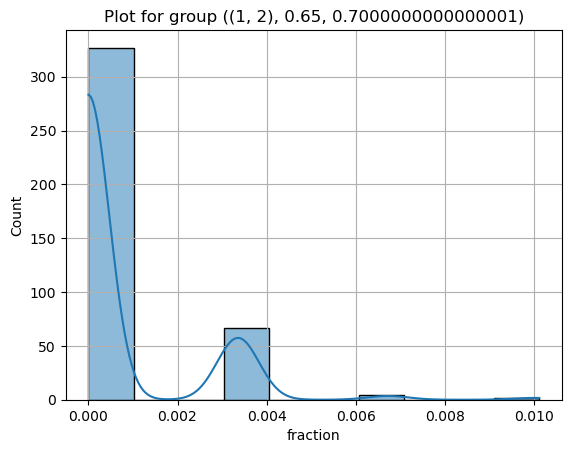

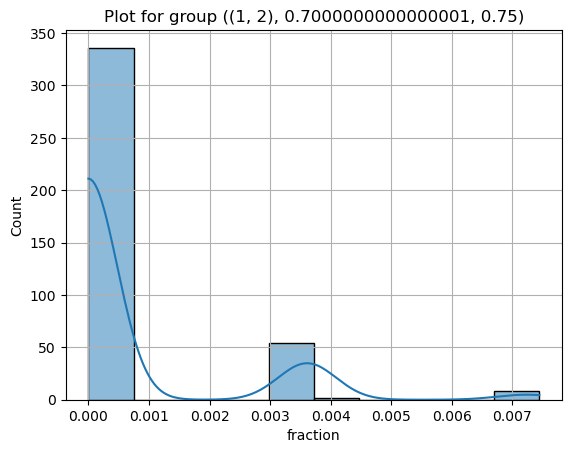

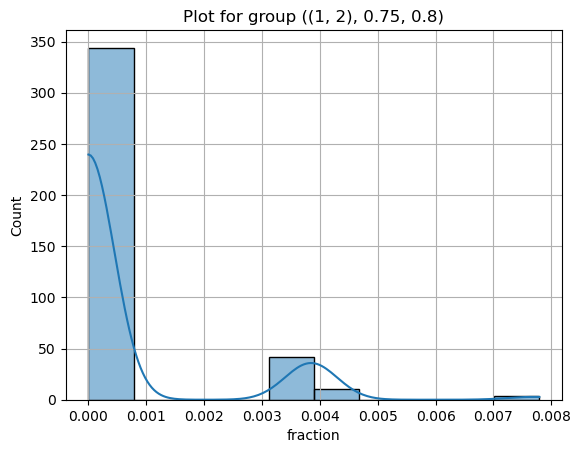

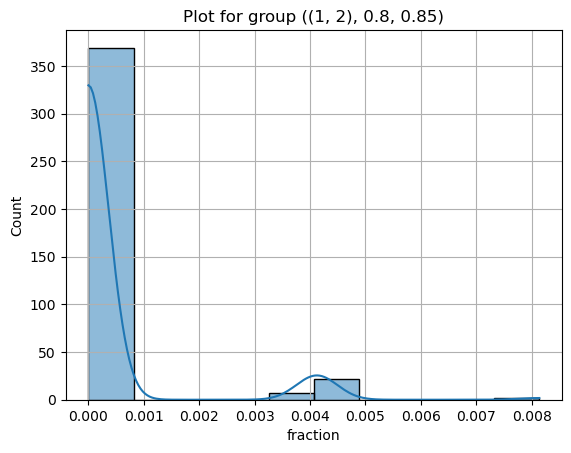

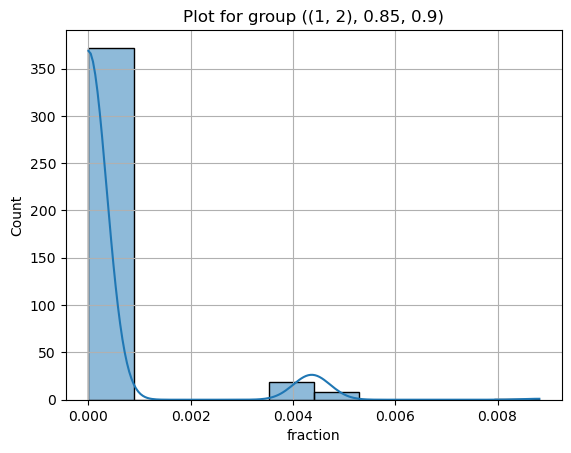

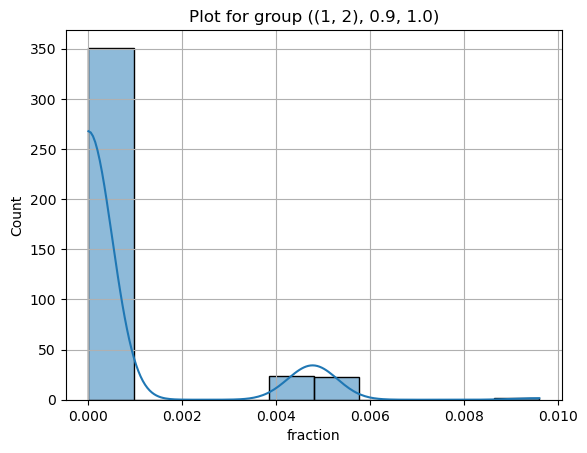

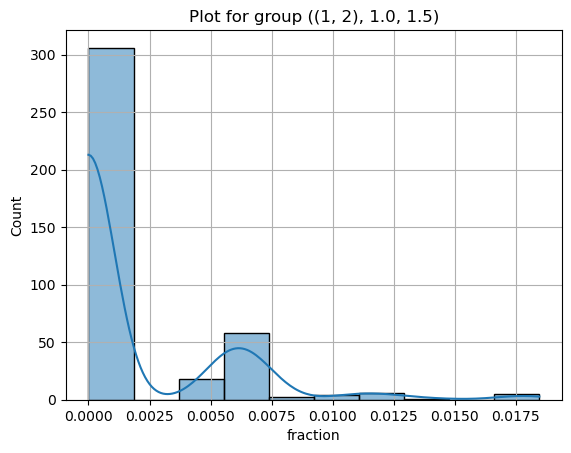

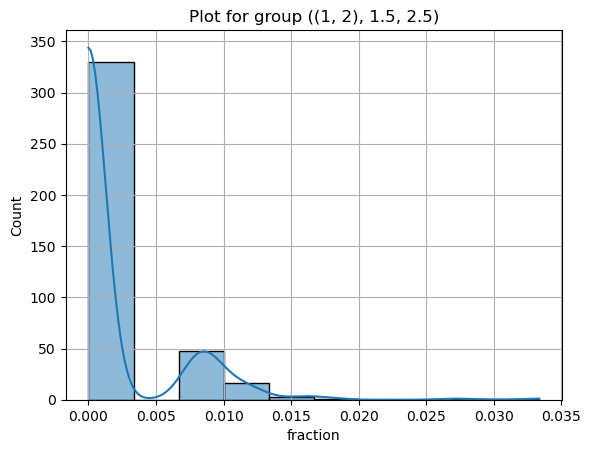

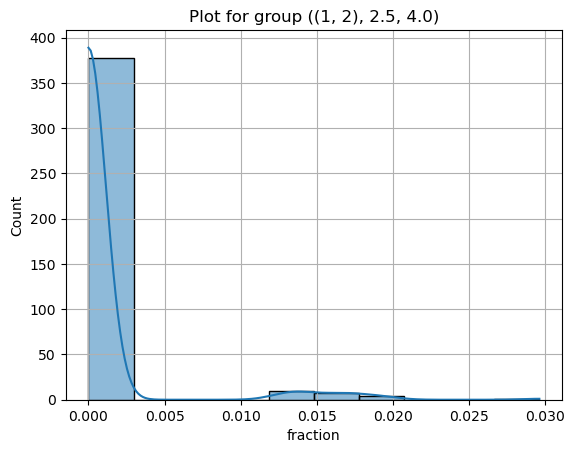

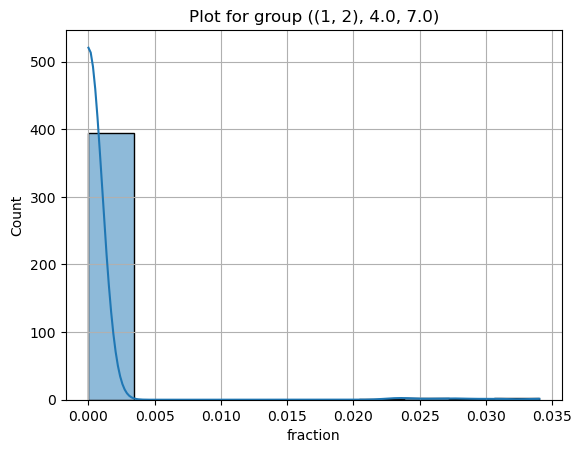

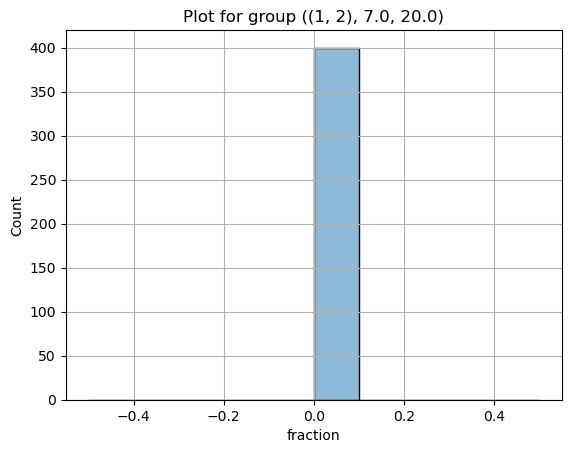

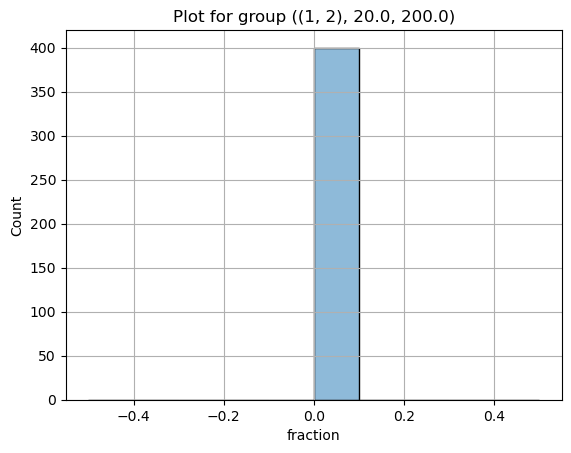

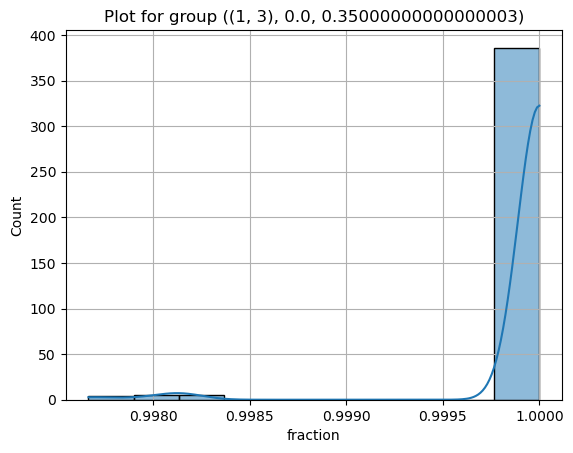

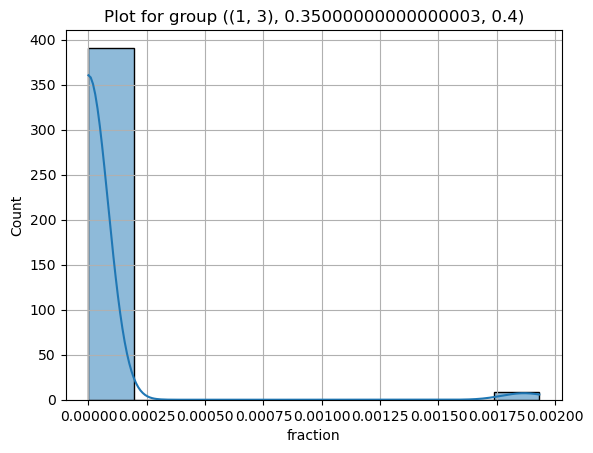

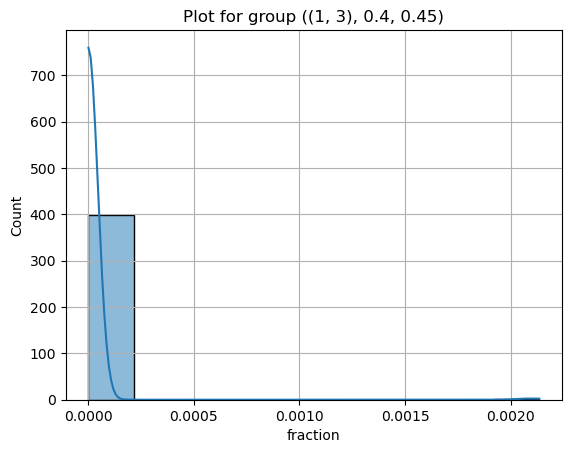

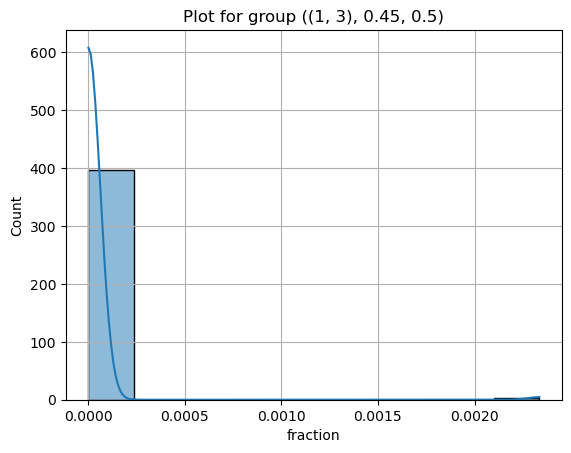

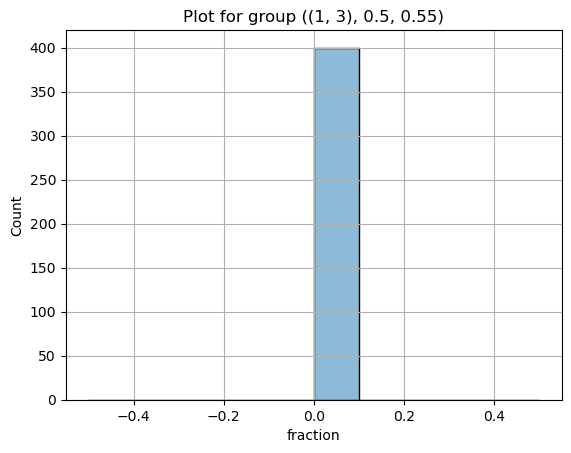

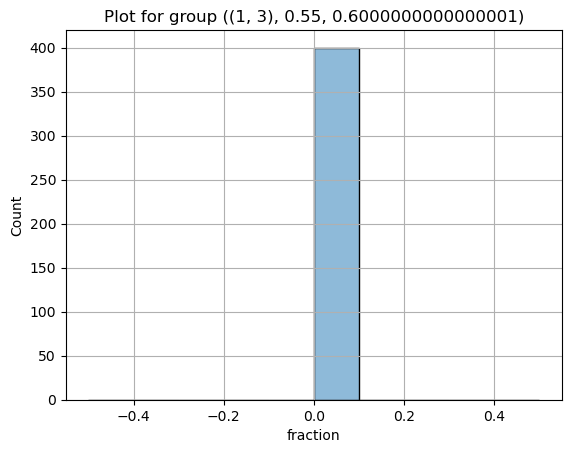

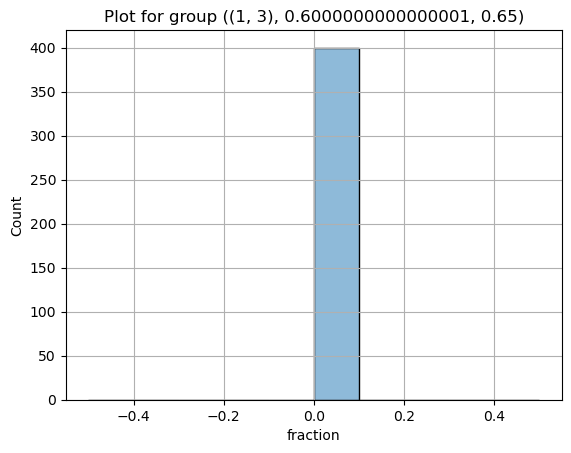

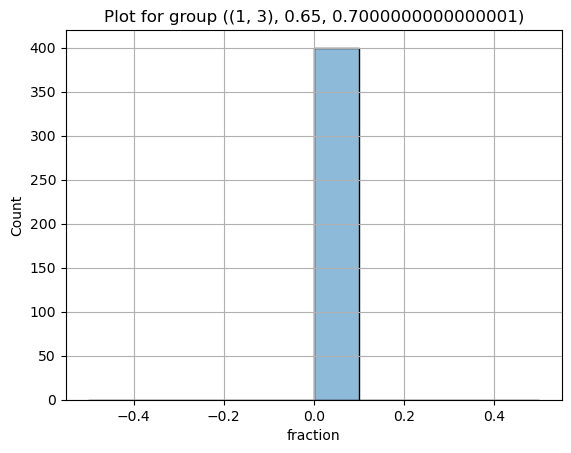

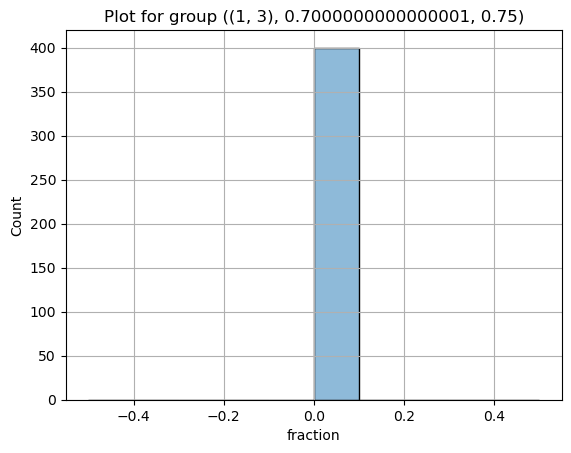

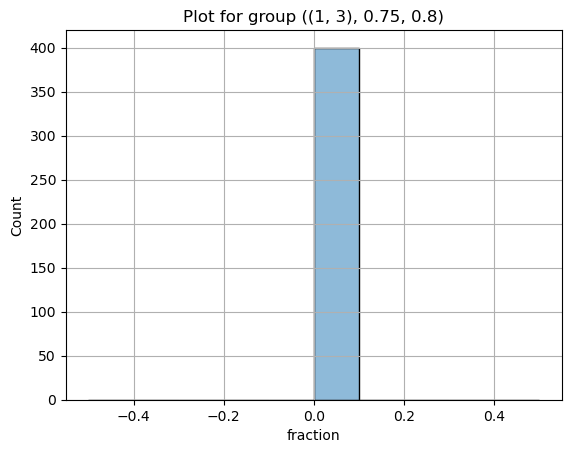

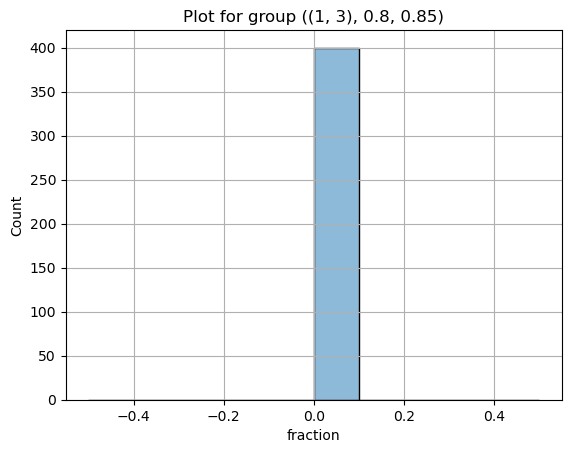

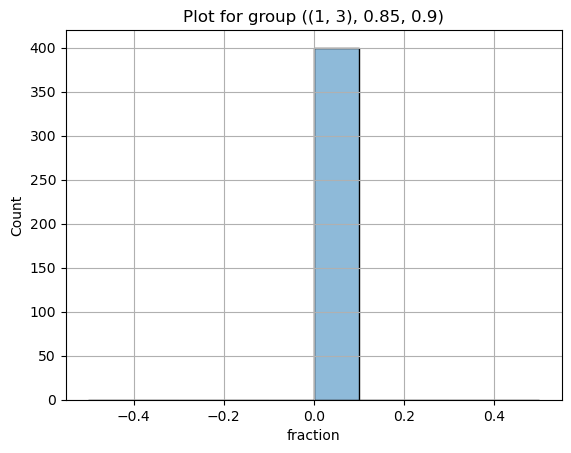

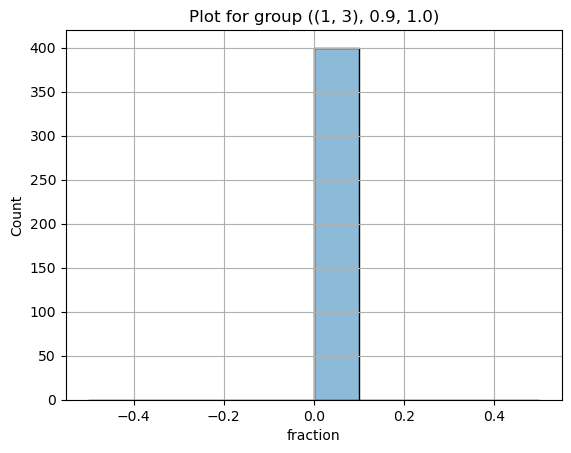

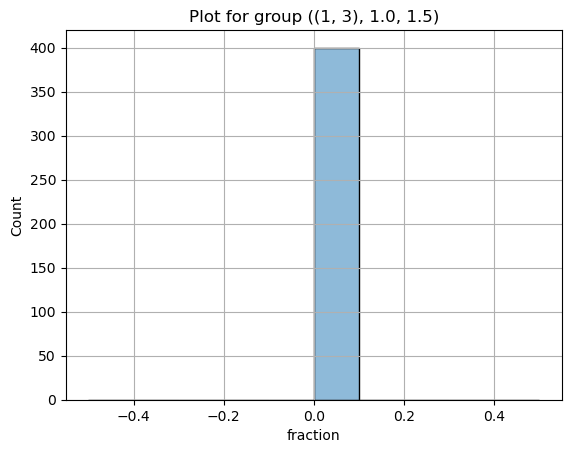

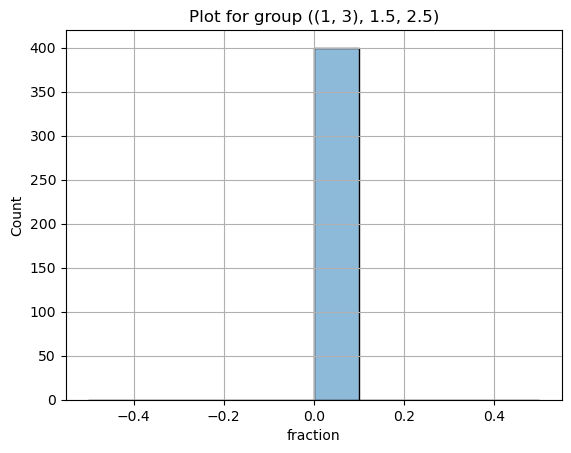

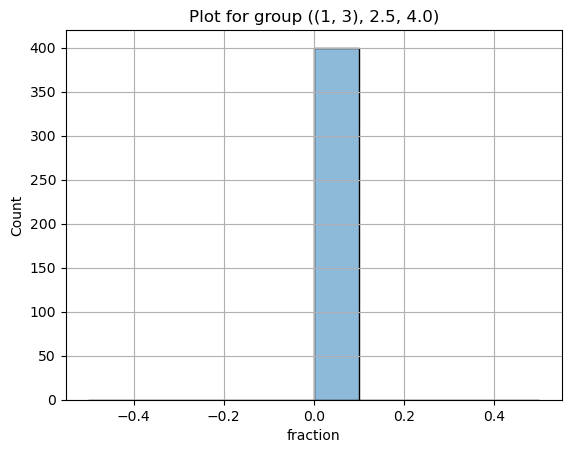

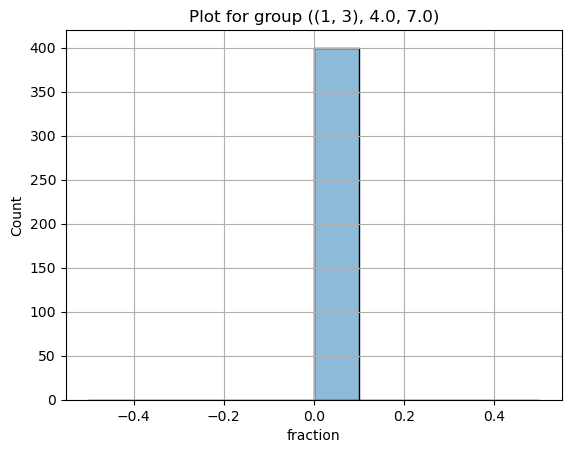

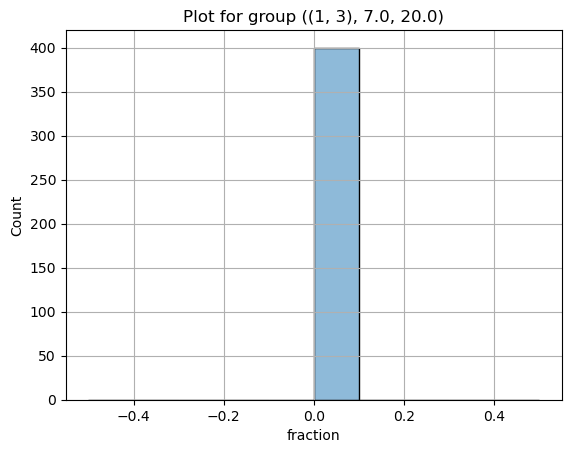

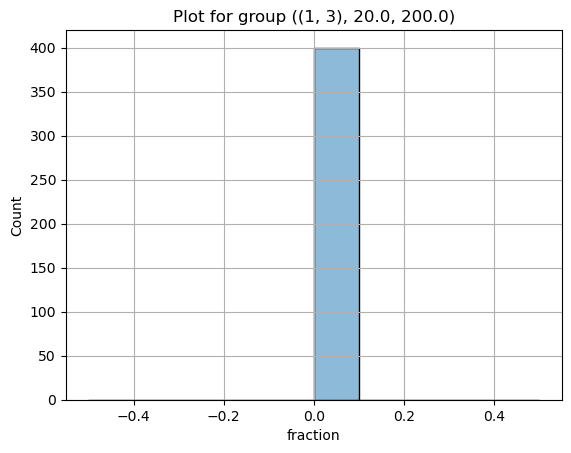

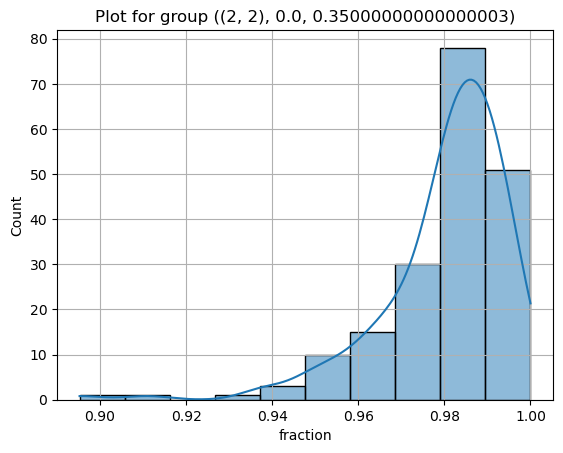

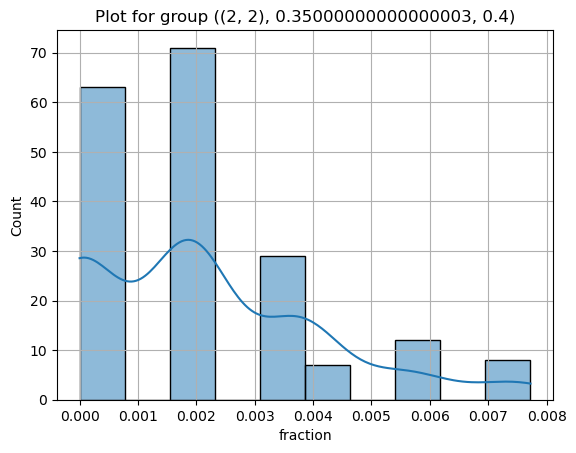

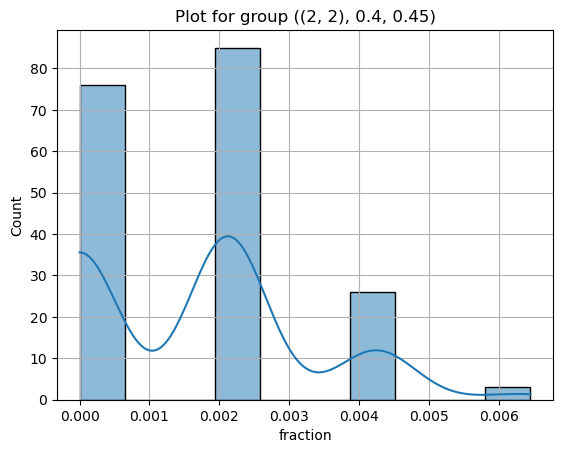

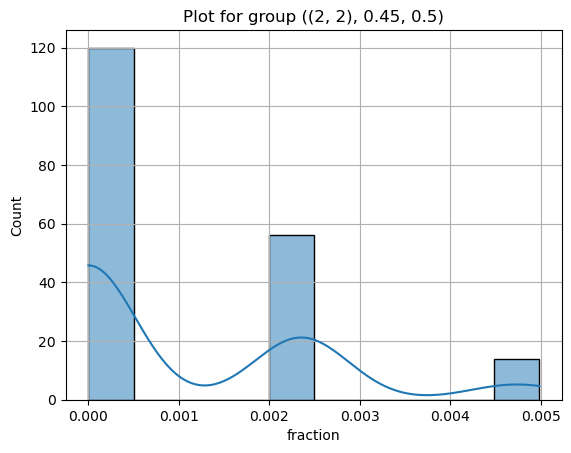

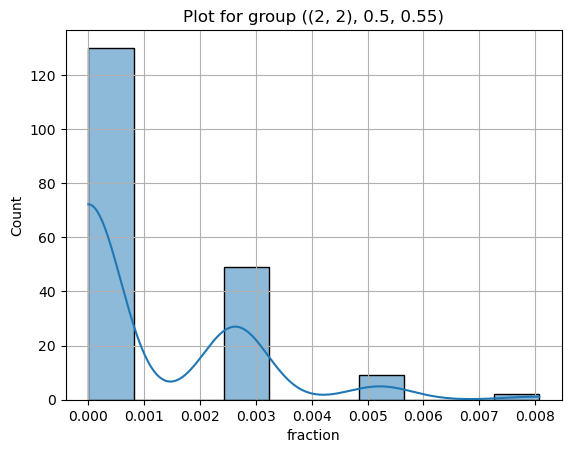

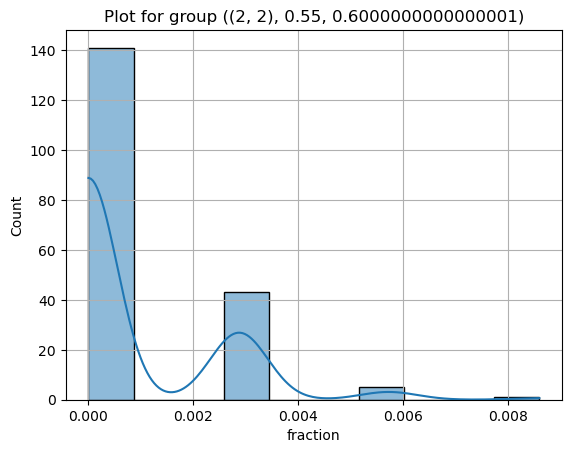

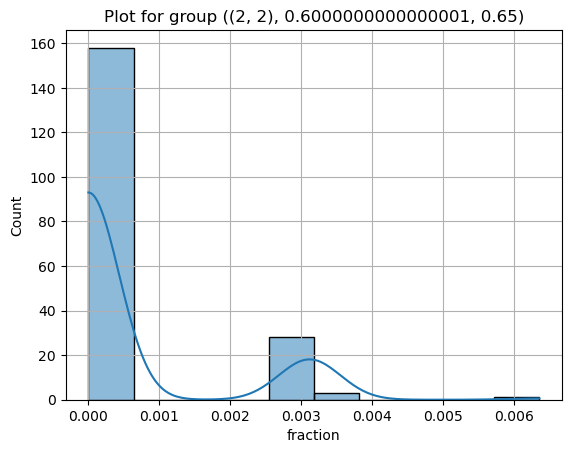

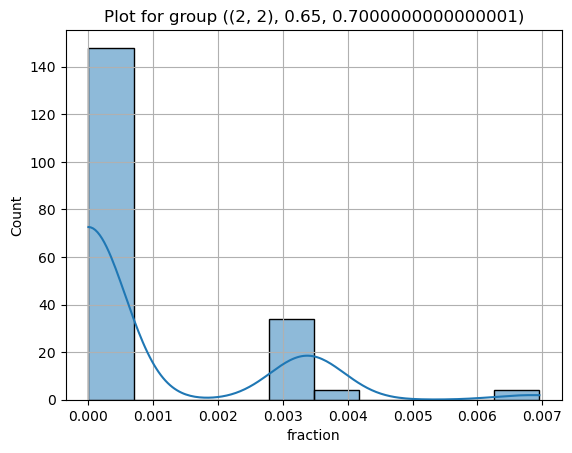

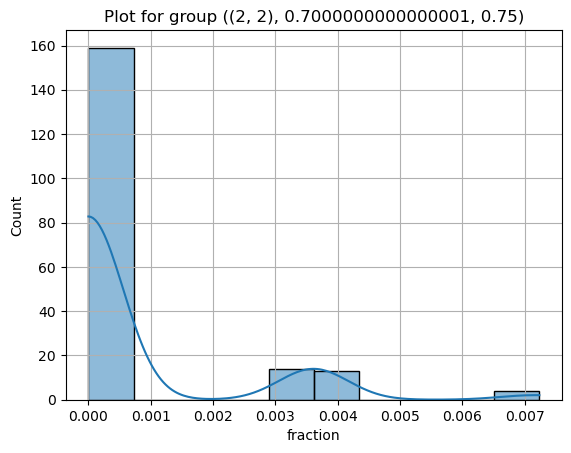

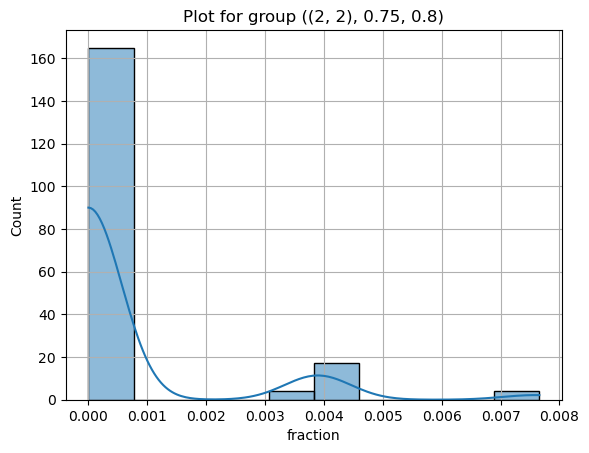

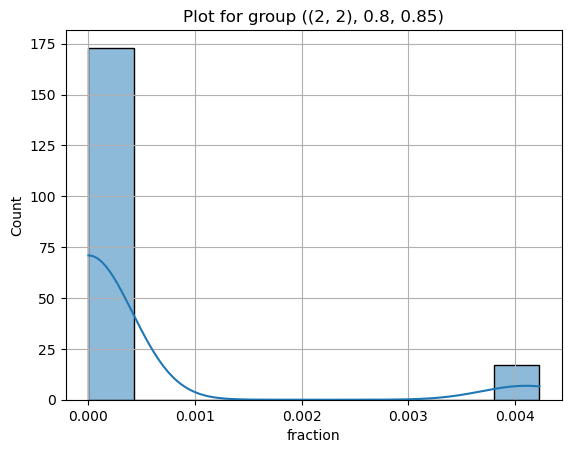

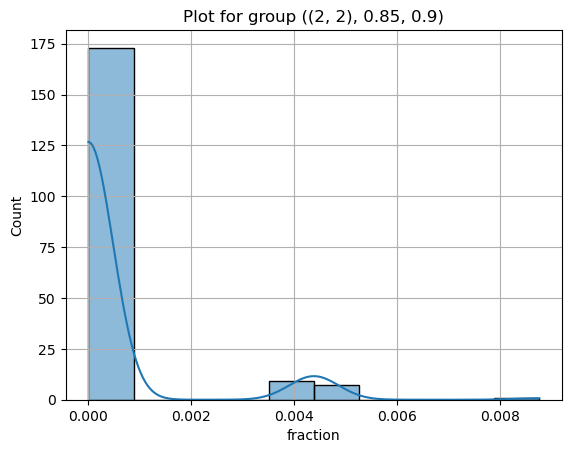

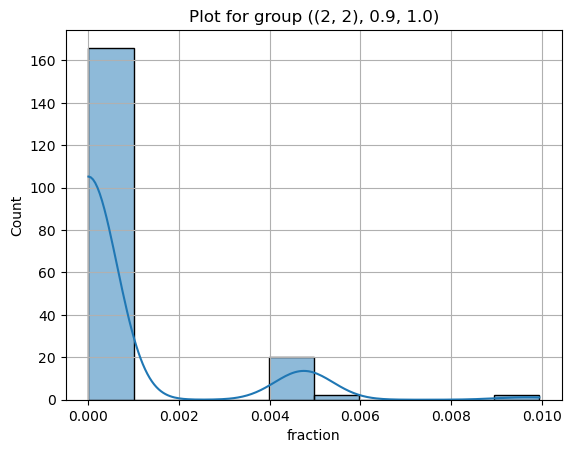

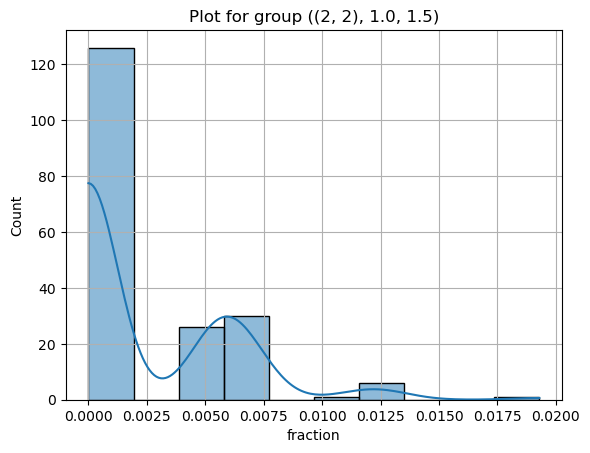

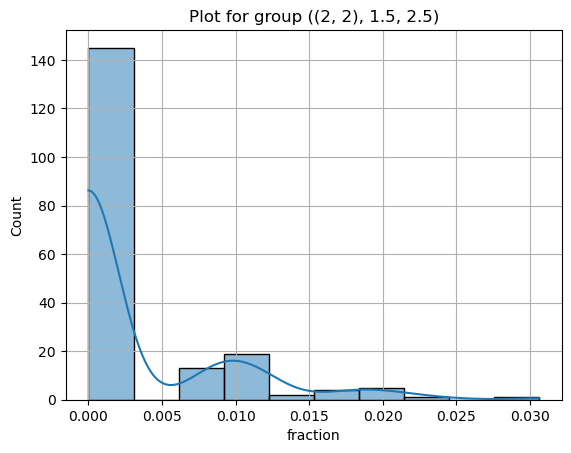

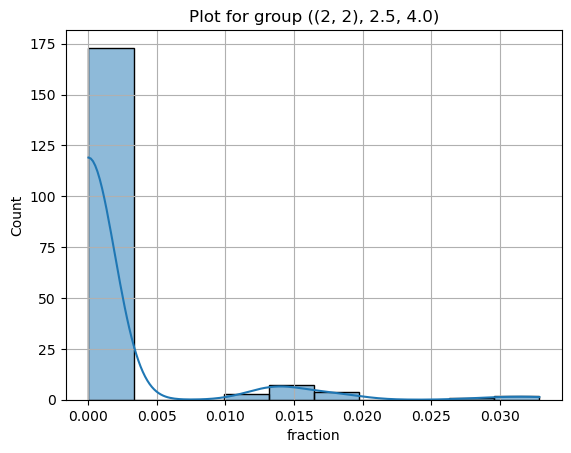

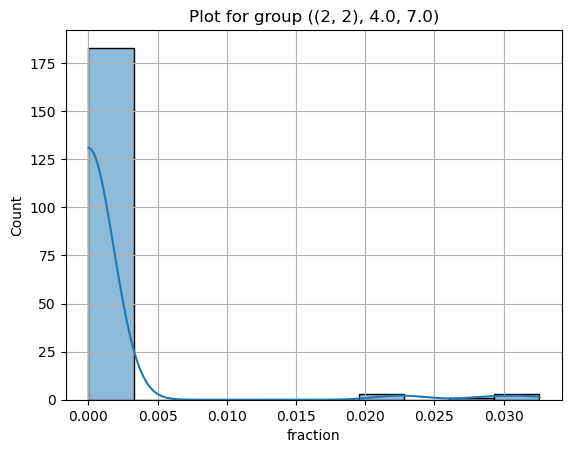

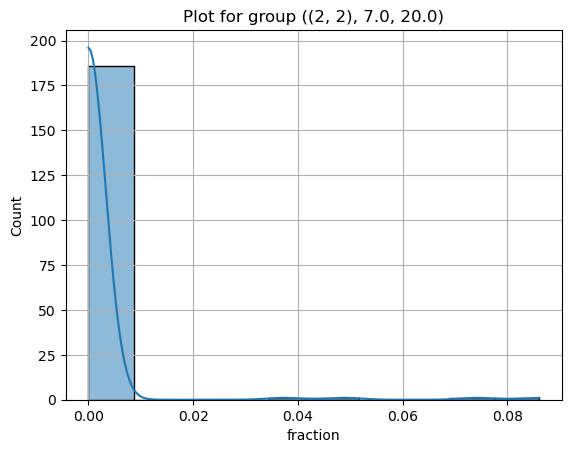

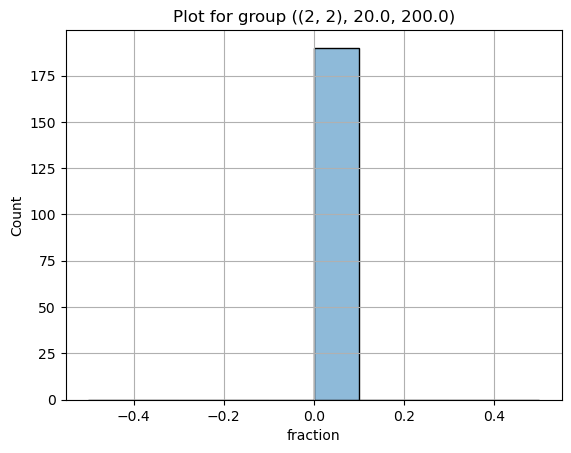

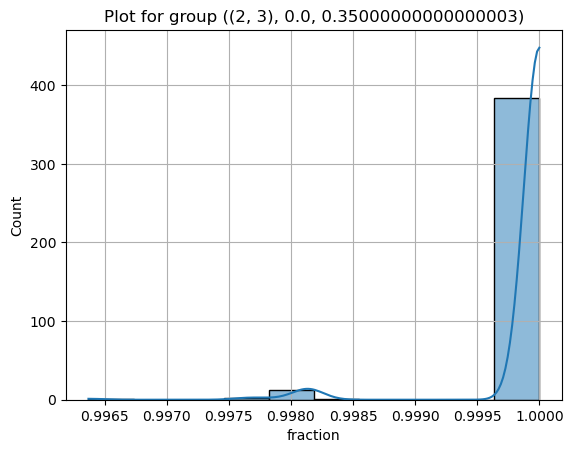

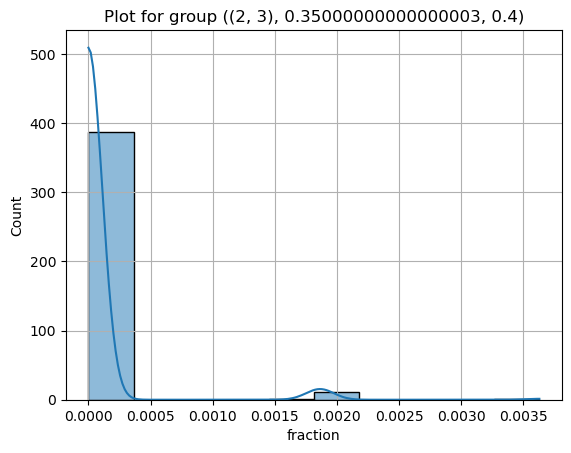

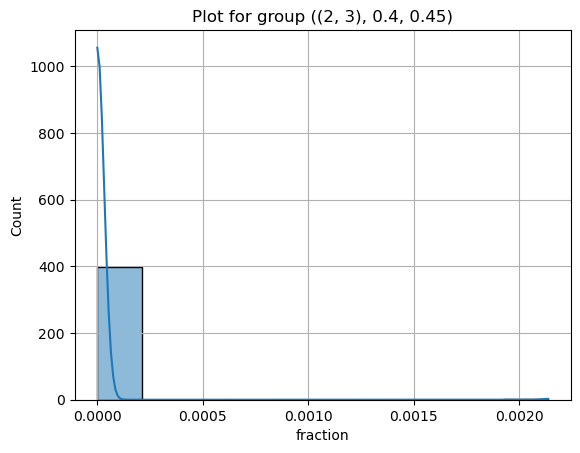

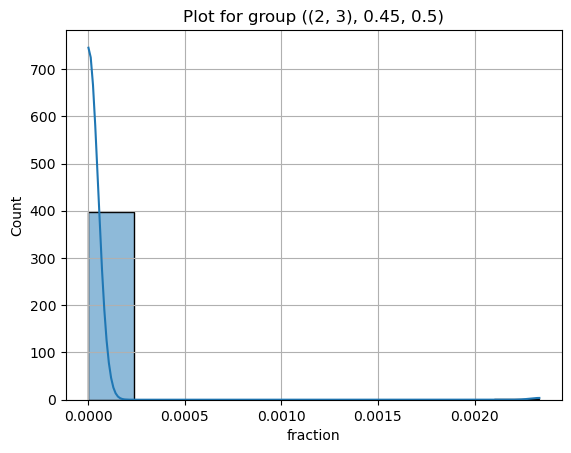

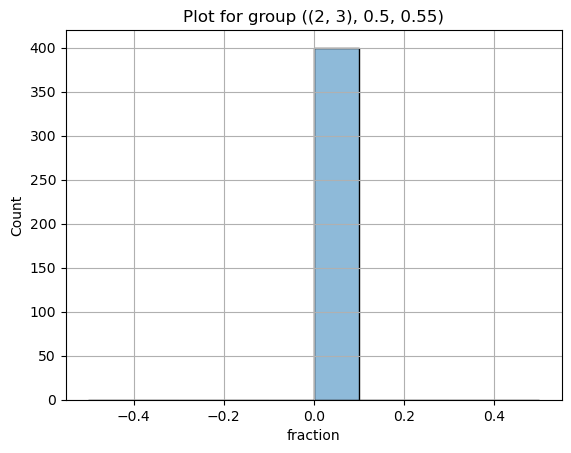

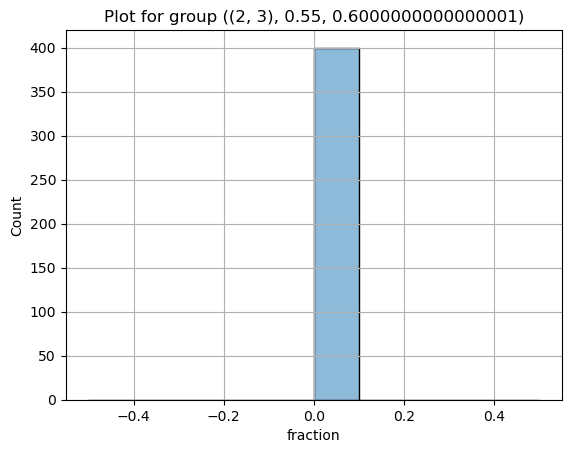

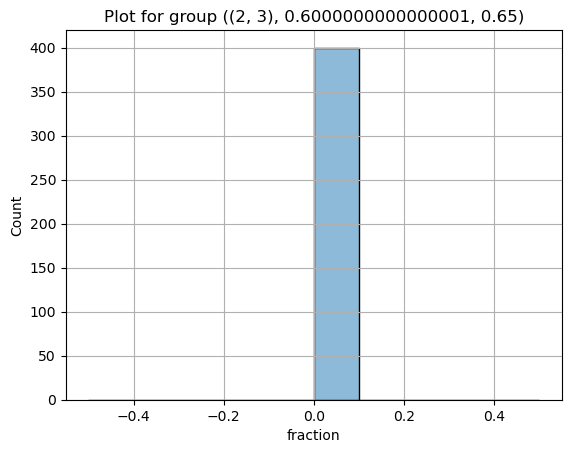

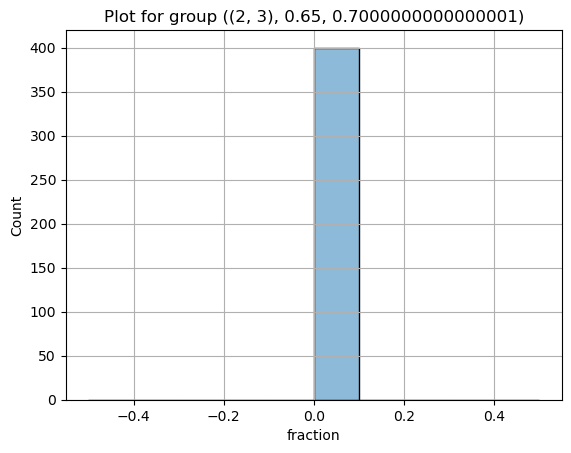

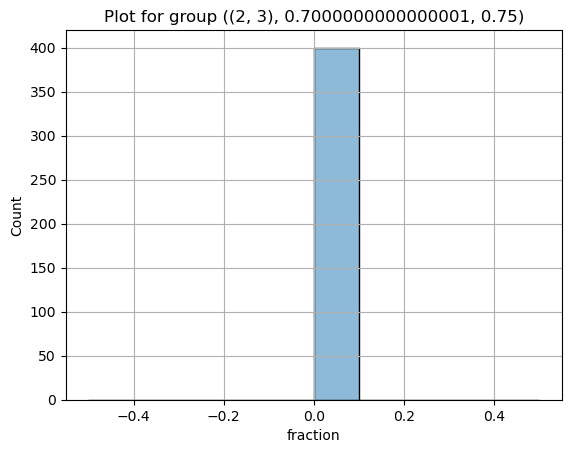

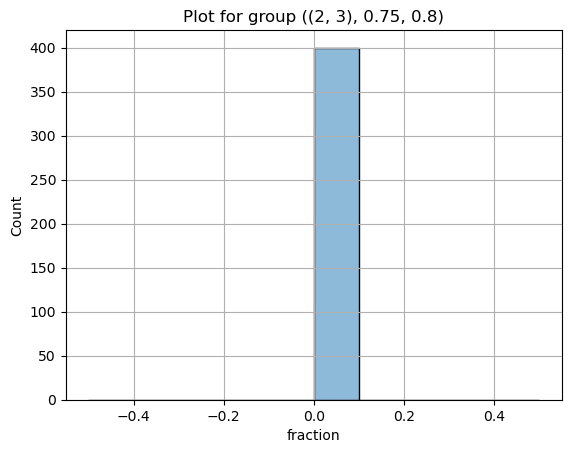

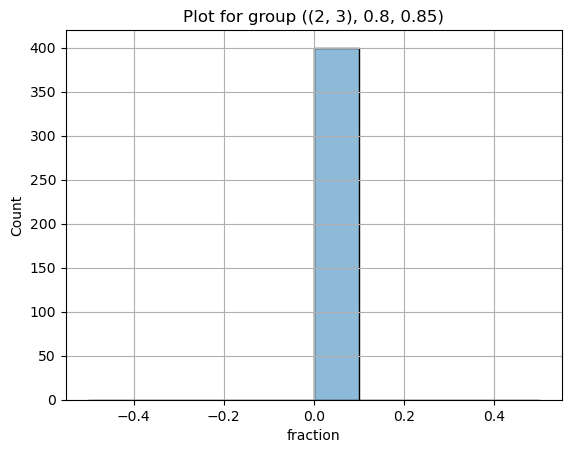

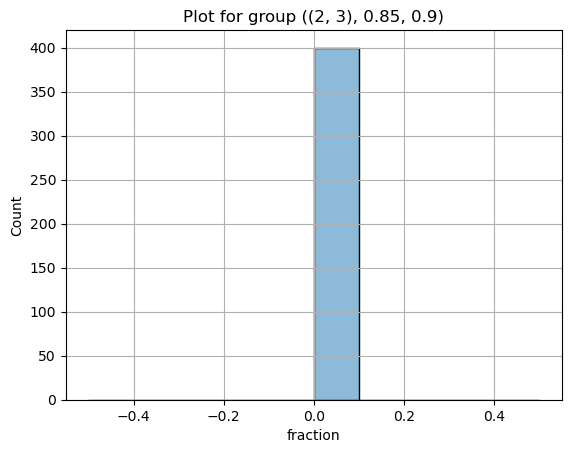

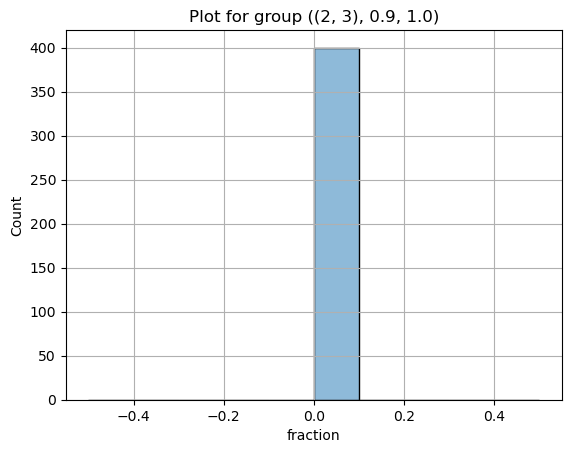

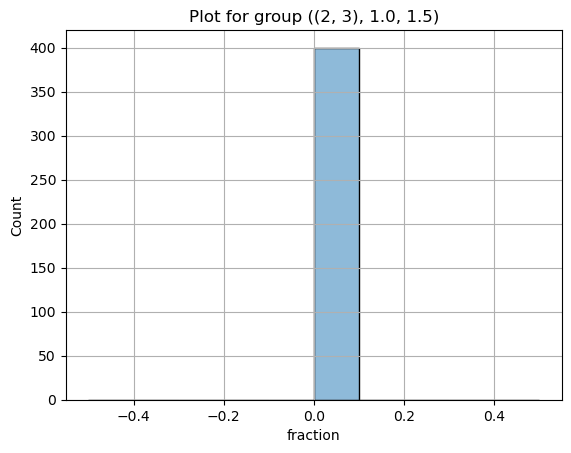

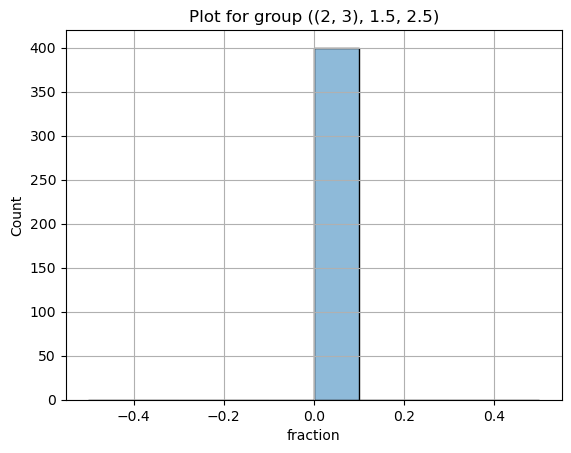

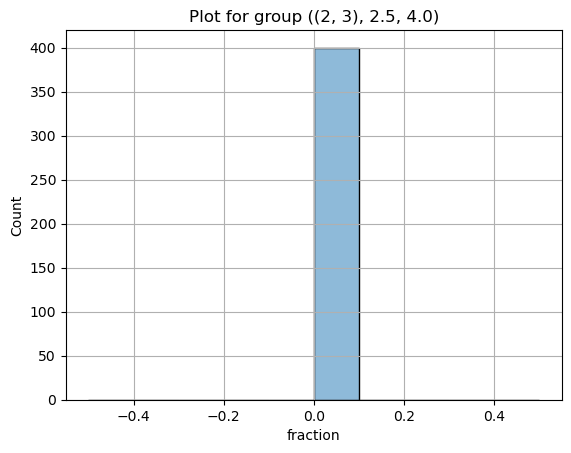

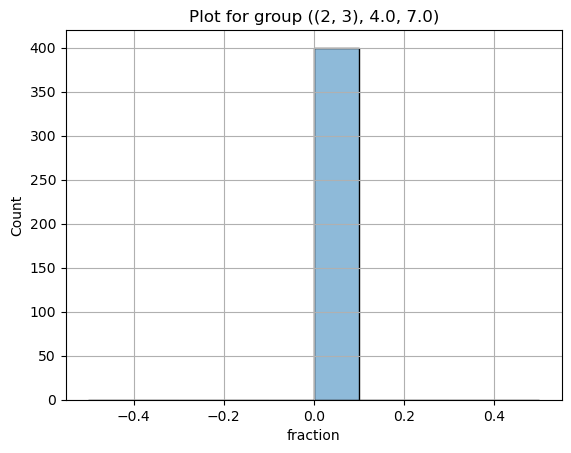

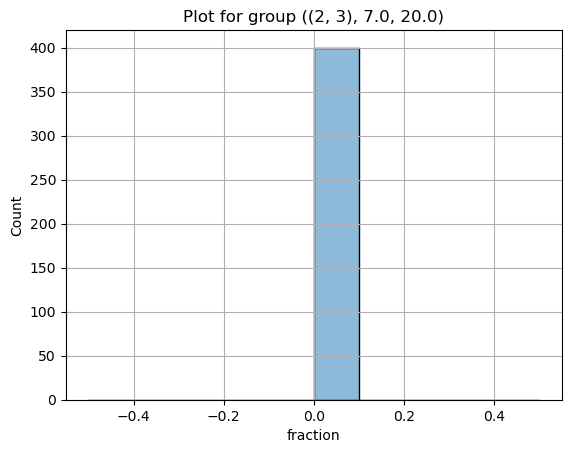

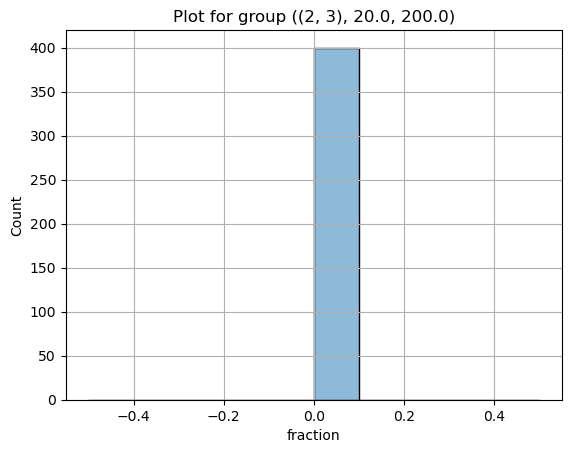

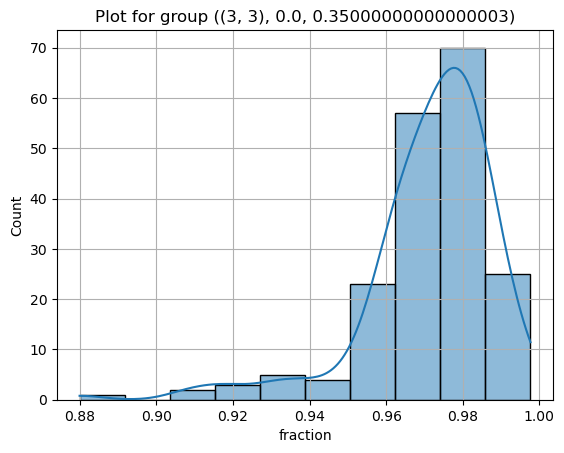

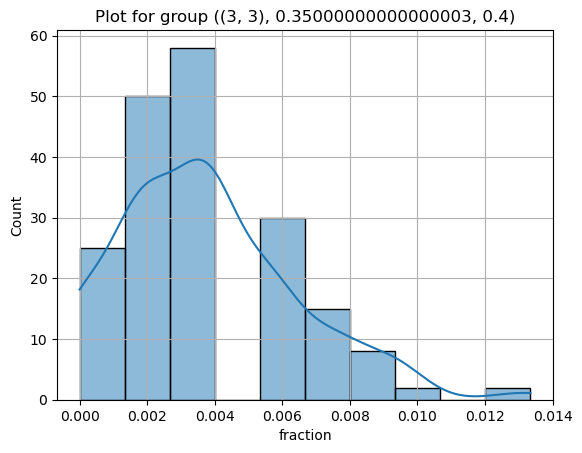

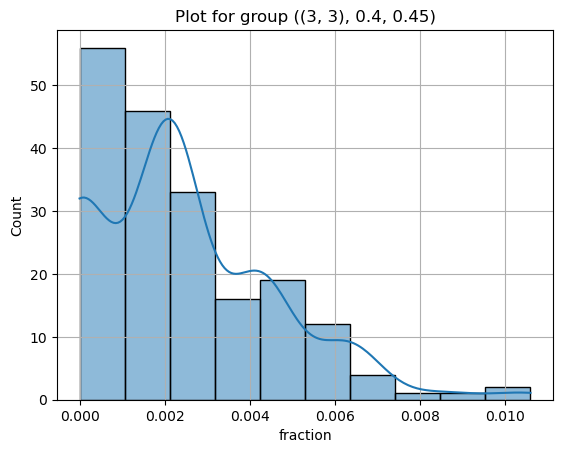

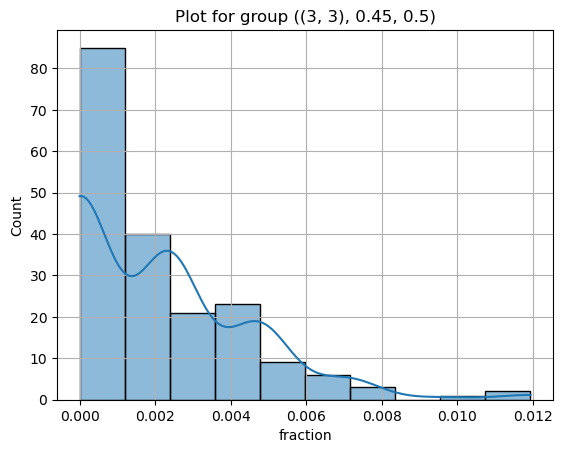

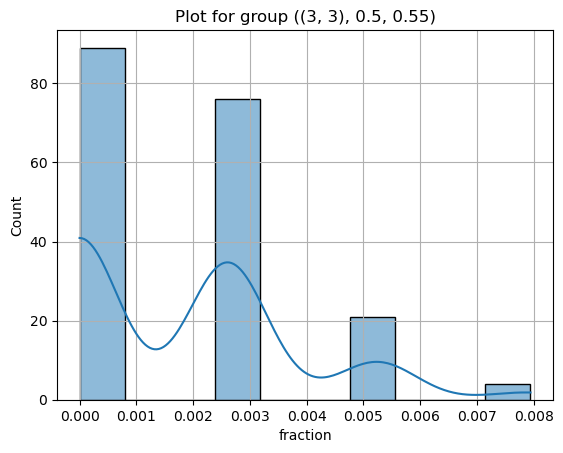

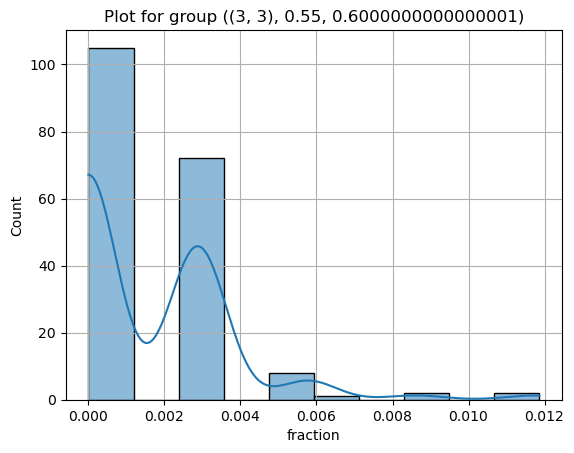

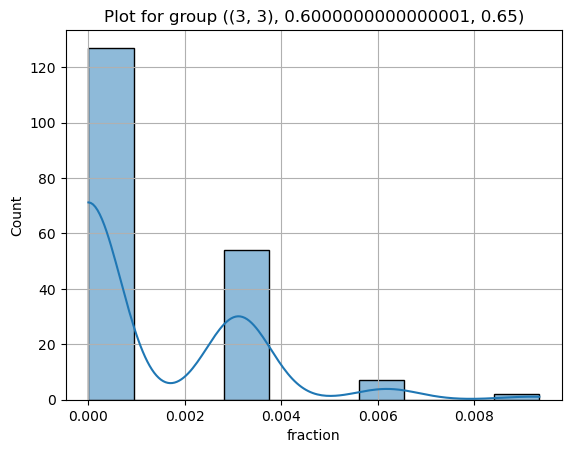

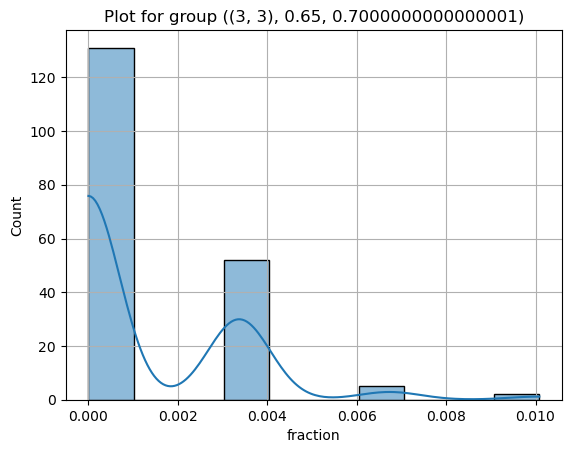

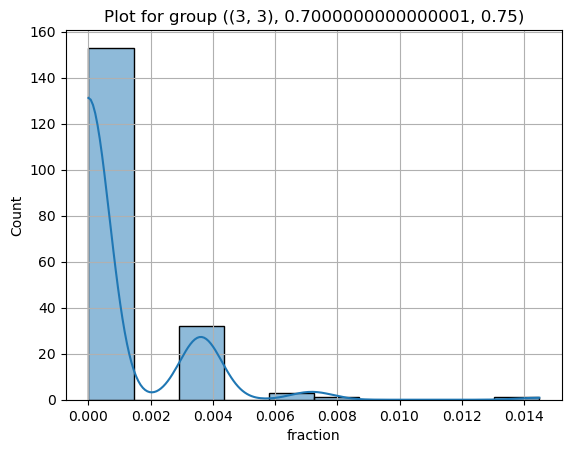

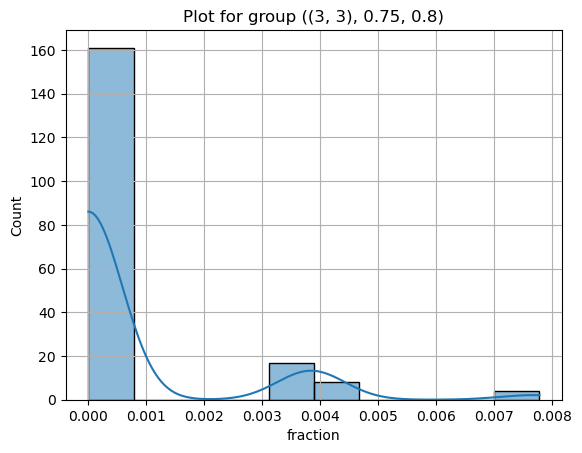

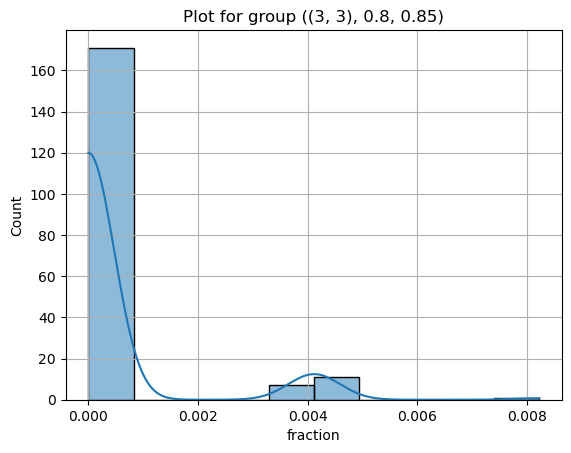

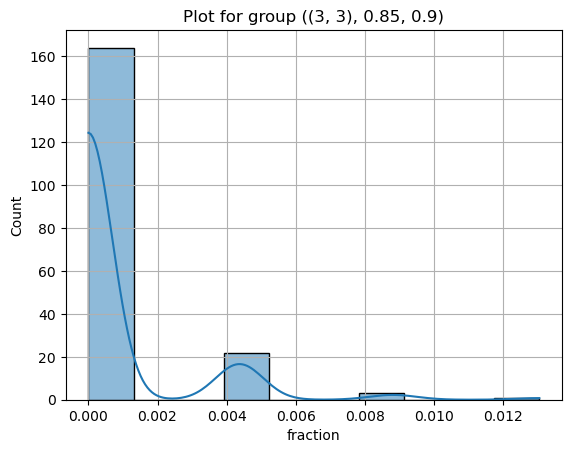

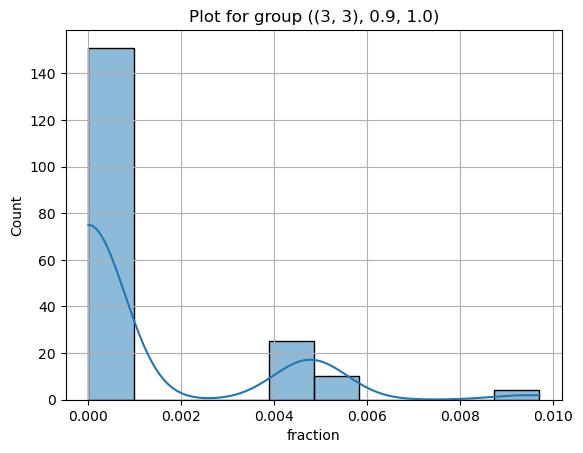

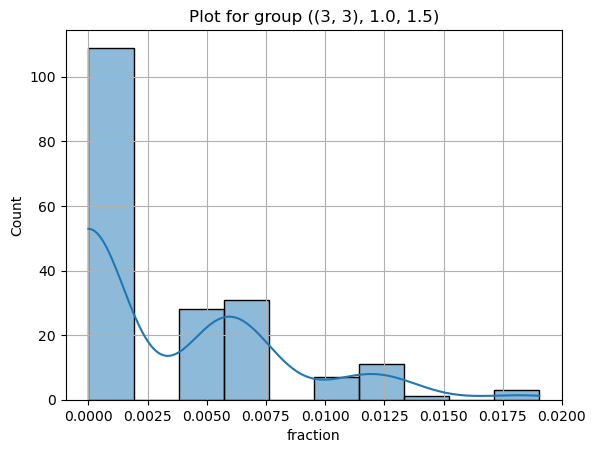

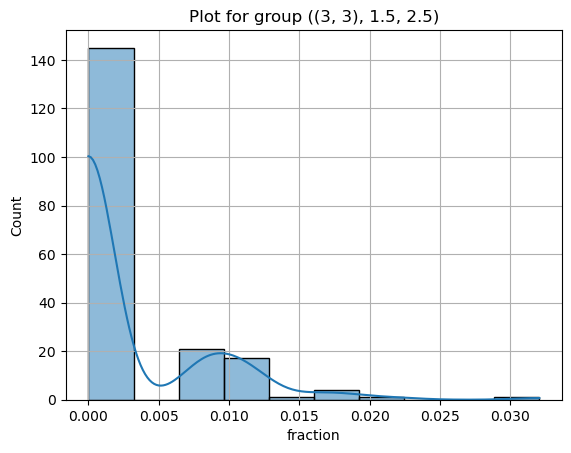

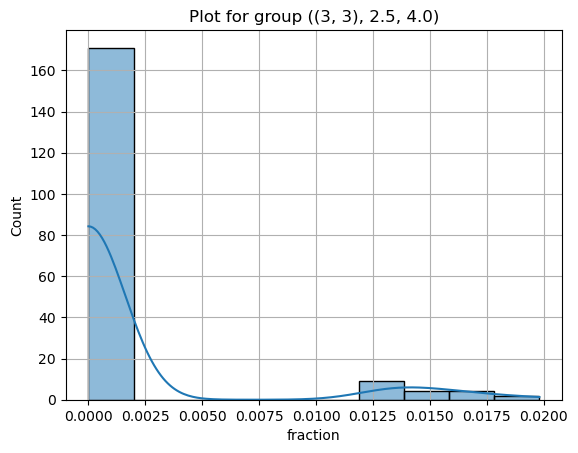

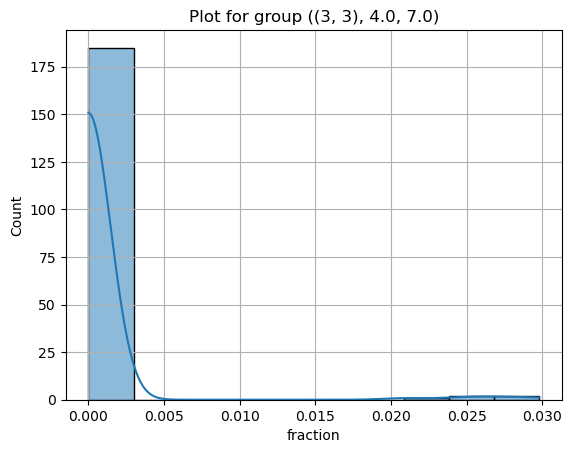

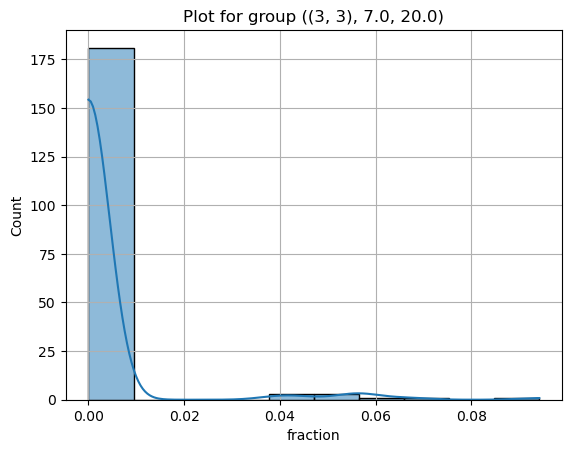

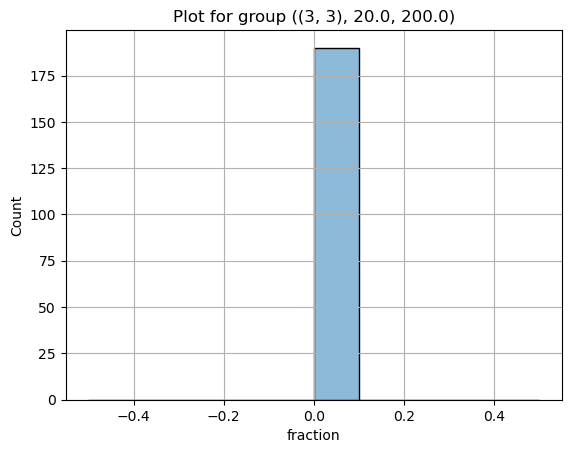

In [5]:
grouped = data.groupby(['group','u','v'])
for name, group in grouped:
    plt.figure()
    sns.histplot(group['fraction'],bins = 10,kde = True)
    plt.title(f'Plot for group {name}')
    plt.grid(True)
    plt.show()

<Axes: xlabel='fraction', ylabel='Count'>

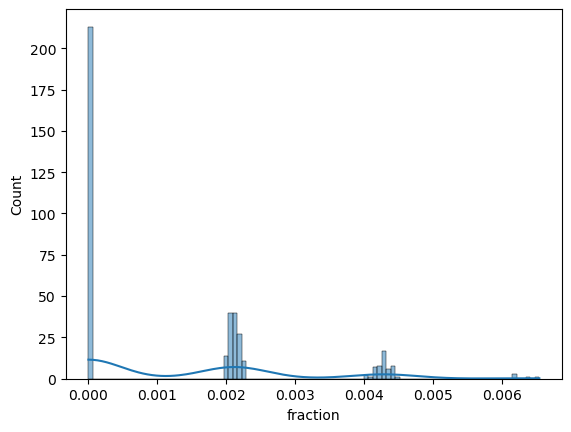

In [8]:
sns.histplot(data[(data['group'] == (0,2)) & (data['u'] == 0.4)]['fraction'],bins=100,kde = True)

In [13]:
n_boot = 1000
sample_N = data['true_N'][0]
sample_T1 = data['true_T1'][0]
sample_T2 = data['true_T2'][0]
sample_T3 = data['true_T3'][0]
columns = ['group','mean_fraction','bootstrap_variance','p_0','true_N','u','v','true_T1','true_T2','true_T3']
boot_data = pd.DataFrame(columns = columns)
for name, group in grouped:
    gg = name[0]
    u = name[1]
    v = name[2]
    non_zero = [i for i in group['fraction'] if i > 0]
    p_0 = 1- (len(non_zero)/len(group['fraction']))
    if p_0 > 0.95:
        continue
    sample_mean = sum(non_zero)/len(non_zero)
    bootstrap_means = []

    for _ in range(n_boot):
        sample = np.random.choice(non_zero, size=len(non_zero), replace=True)
        bootstrap_means.append(np.mean(sample))

# Estimate variance
    variance_estimate = np.var(bootstrap_means)
    new_row = [gg,sample_mean,variance_estimate,p_0,sample_N,u,v,sample_T1,sample_T2,sample_T3]
    boot_data.loc[len(boot_data)] = new_row



In [ ]:
from one_population_data import simulate
N = [4000]
L =  [0,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,1,1.5,2.5,5,20,200] 
final_data = pd.DataFrame(columns = ['u','v','total_mean','non_zero_mean','p_0'])

for _ in range(400):
    ibd = simulate(N,L,2,1e7,10)
    data = pd.DataFrame(ibd)
    grouped = data.groupby(['u','v'])
    for name, group in grouped:
        u = name[0]
        v = name[1]
        total_mean = sum(group['fraction'])/len(group['fraction'])
        non_zero = [i for i in group['fraction'] if i > 0]
        p_0 = 1- (len(non_zero)/len(group['fraction']))
        if p_0 > 0.95:
            continue
        sample_mean = sum(non_zero)/len(non_zero)
        new_data = [u,v,total_mean,sample_mean,p_0]
        final_data.loc[len(final_data)] = new_data

    

In [92]:
final_data

u      v  total_mean  non_zero_mean       p_0
0     0.00   0.35    0.963433       0.963433  0.000000
1     0.35   0.40    0.004677       0.005136  0.089474
2     0.40   0.45    0.003709       0.004297  0.136842
3     0.45   0.50    0.002706       0.004214  0.357895
4     0.50   0.55    0.002528       0.004037  0.373684
...    ...    ...         ...            ...       ...
6537  0.90   1.00    0.001234       0.005329  0.768421
6538  1.00   1.50    0.003883       0.007685  0.494737
6539  1.50   2.50    0.003328       0.010716  0.689474
6540  2.50   5.00    0.002159       0.017090  0.873684
6541  5.00  20.00    0.002218       0.038306  0.942105

[6542 rows x 5 columns]

In [8]:
def int_p_L(N, t1, t2, u, v):
    cu = -(1/N + u/50)
    cv = -(1/N + v/50)

    # Avoid division by zero or very small denominators

    k1 = (u / (50 * N)) * ((np.exp(cu * t2) * (cu * t2 - 1) / cu**2) - (np.exp(cu * t1) * (cu * t1 - 1) / cu**2))
    k2 = (v / (50 * N)) * ((np.exp(cv * t2) * (cv * t2 - 1) / cv**2) - (np.exp(cv * t1) * (cv * t1 - 1) / cv**2))
    k3 = (1 / N) * ((np.exp(cu * t2) / cu) - (np.exp(cu * t1) / cu))
    k4 = (1 / N) * ((np.exp(cv * t2) / cv) - (np.exp(cv * t1) / cv))

    return k1 - k2 + k3 - k4
true_list = []
for a in range(len(L)-1):
    true_list.append(int_p_L(8000,0,10000000,L[a],L[a+1]))

In [99]:
def true(N,u,v):
    return 100* N**2 * (v-u) * (25 * (u+v) + u*v * N)/((N*v + 50)**2 * (N*u + 50)**2) 

In [100]:
int_p_L(10000,0,1000000,0.35,0.4)

0.0034316985114682657

In [119]:
true(8000,5,100)*200

0.4740664036169533

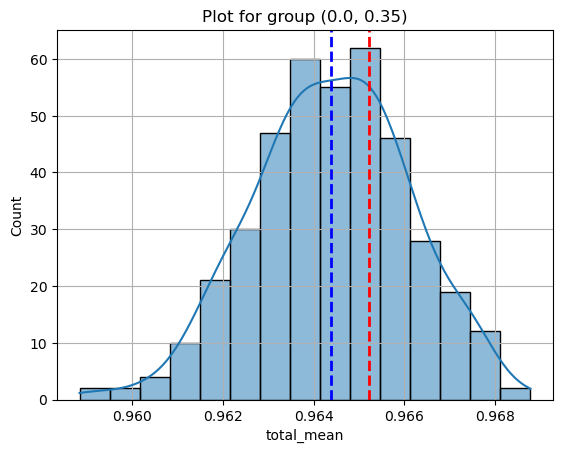

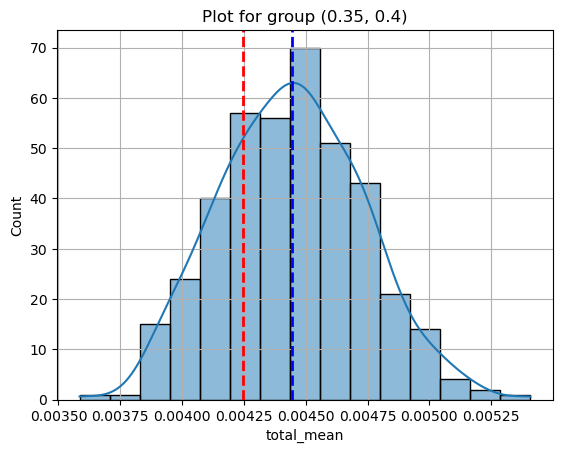

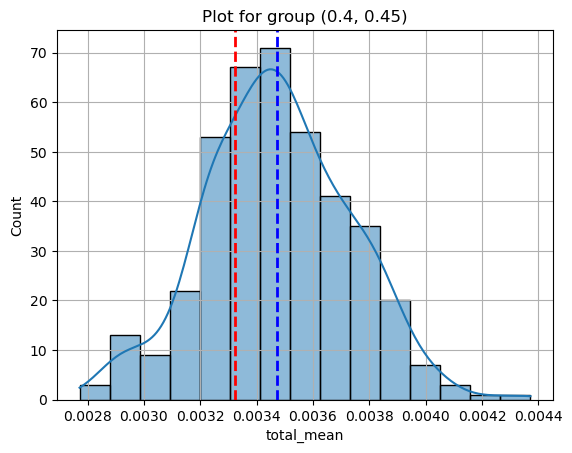

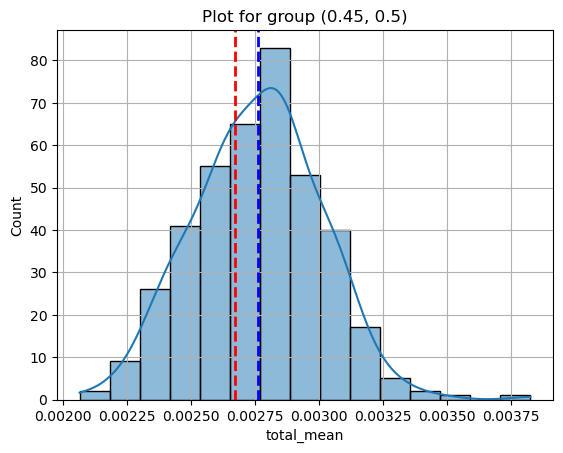

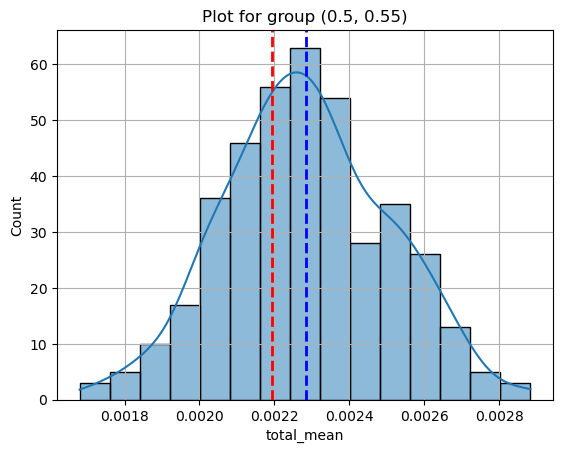

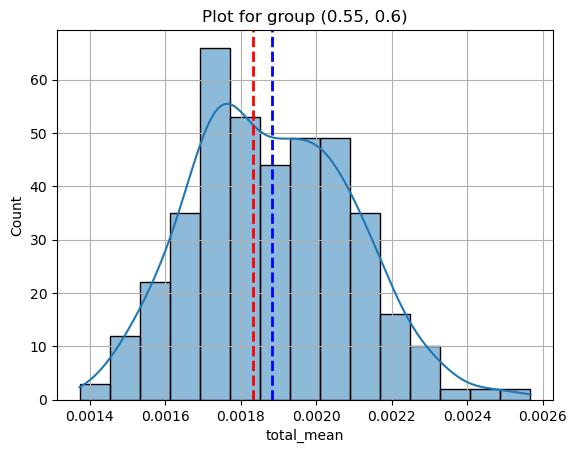

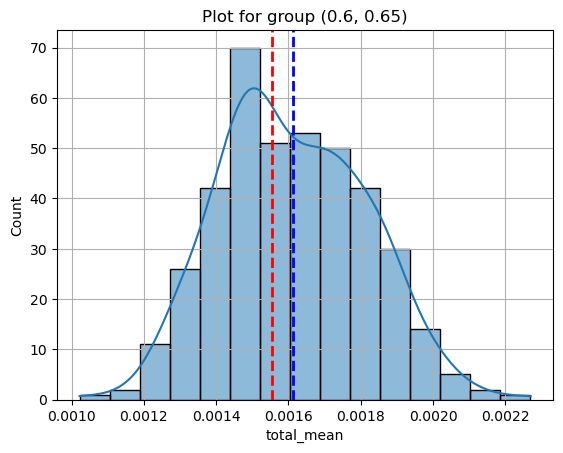

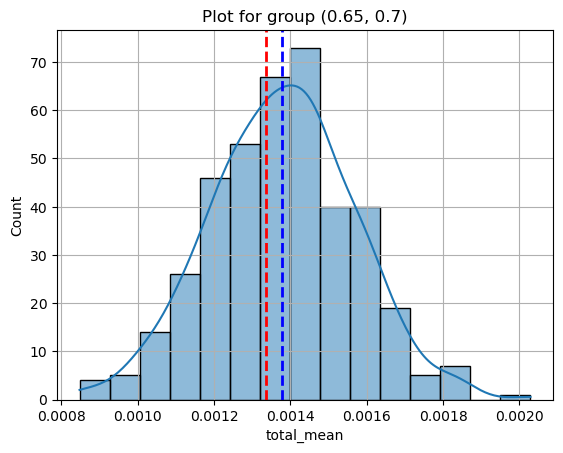

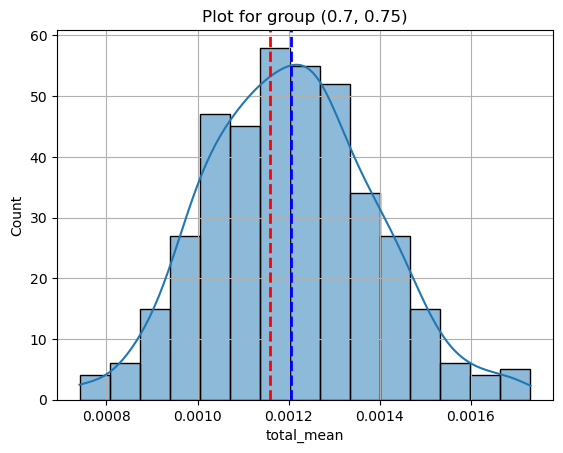

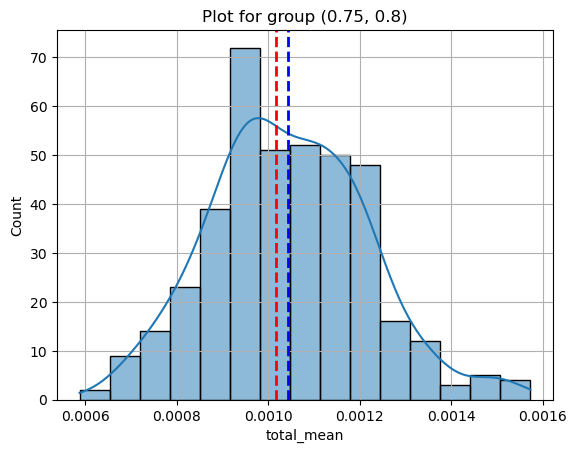

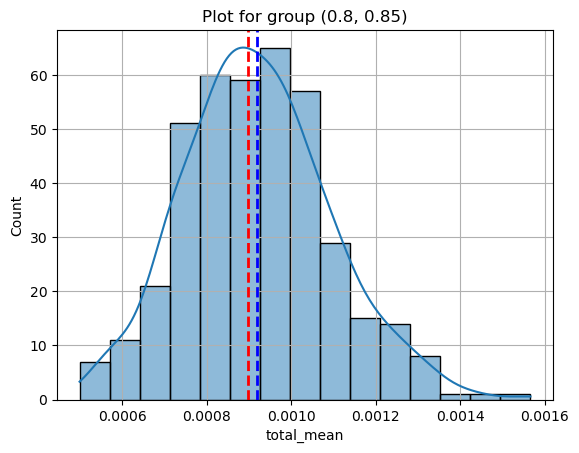

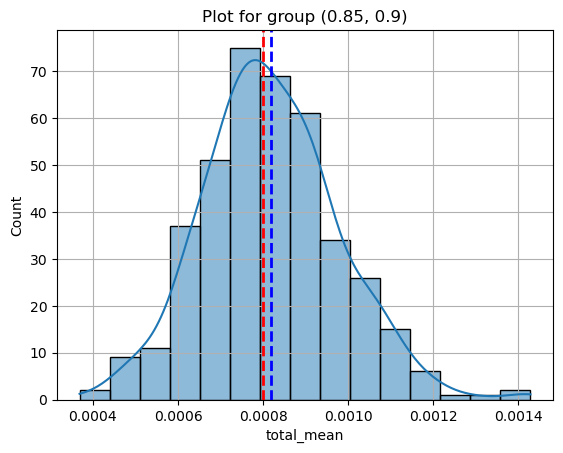

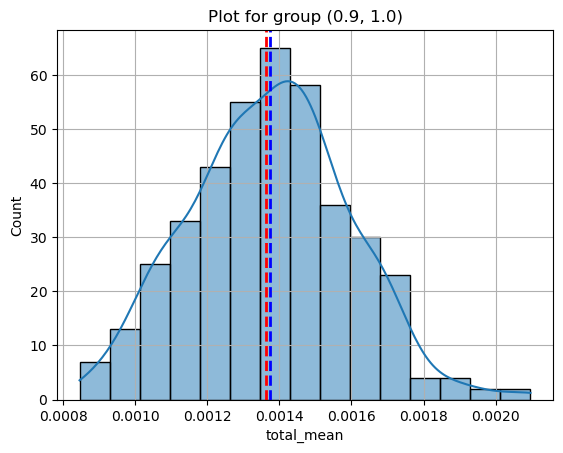

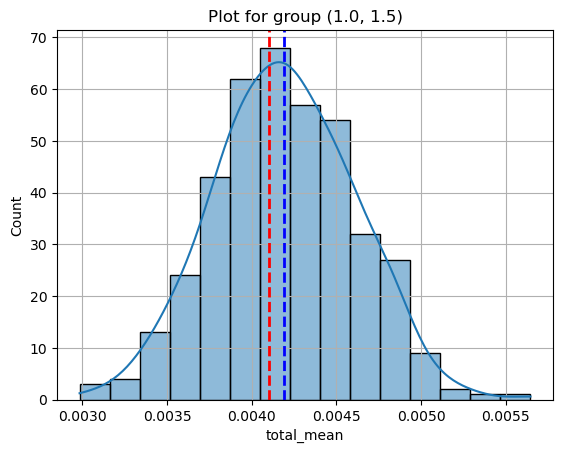

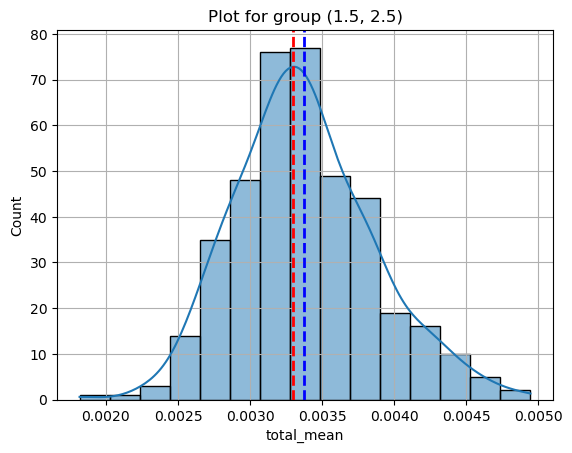

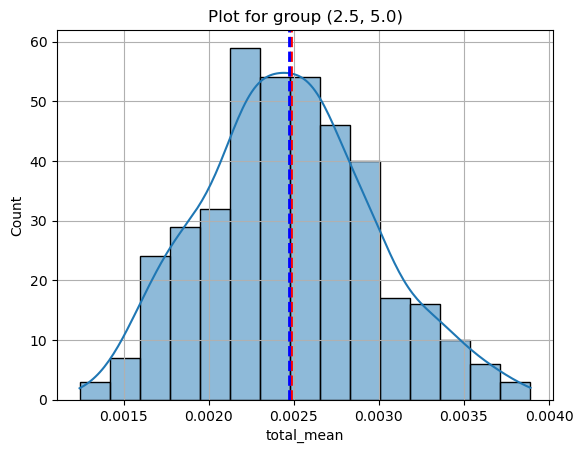

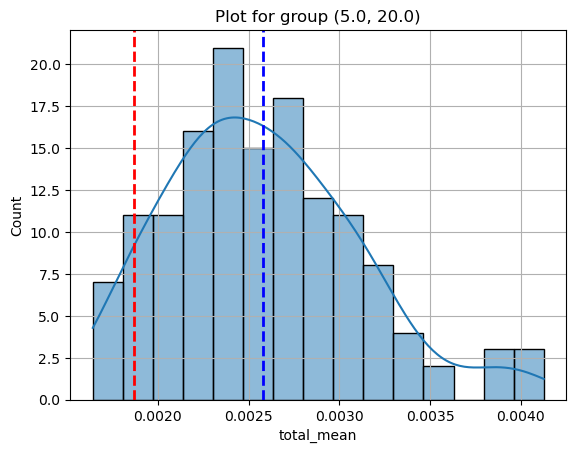

In [103]:
gg = final_data.groupby(['u','v'])
i = 0
for name, group in gg:
    plt.figure()
    sns.histplot(group['total_mean'],bins = 15,kde = True)
    plt.title(f'Plot for group {name}')
    plt.axvline(x=true_list[i], color='red', linestyle='--', linewidth=2)
    plt.axvline(x=group['total_mean'].mean(),color = 'blue',linestyle = '--', linewidth=2)
    i += 1
    plt.grid(True)
    plt.show()

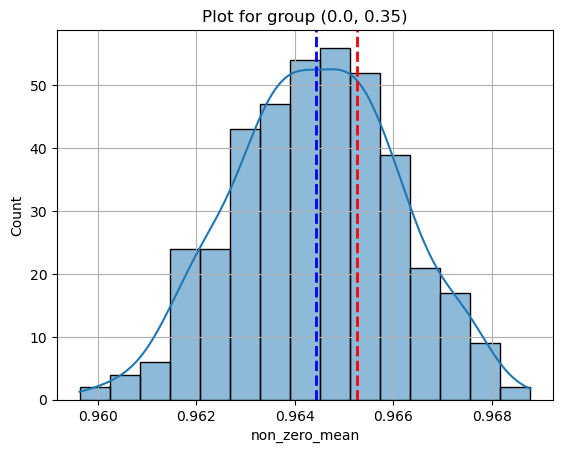

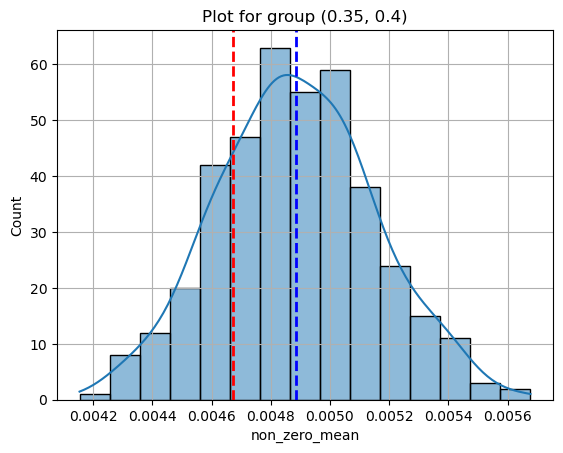

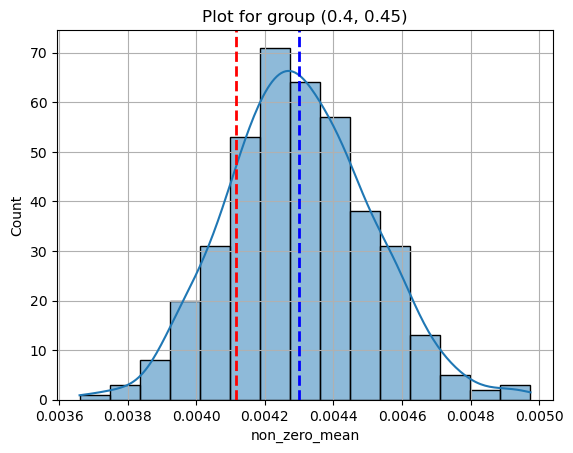

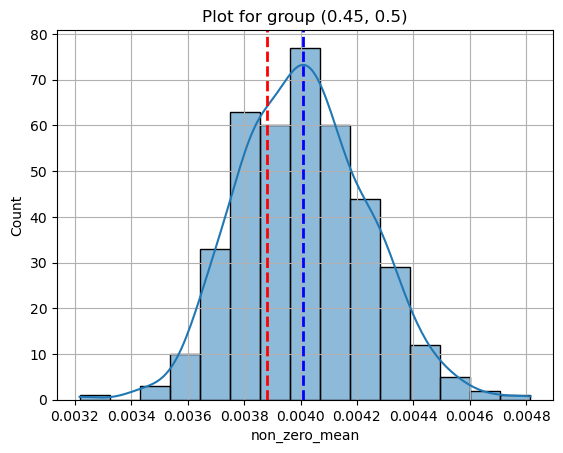

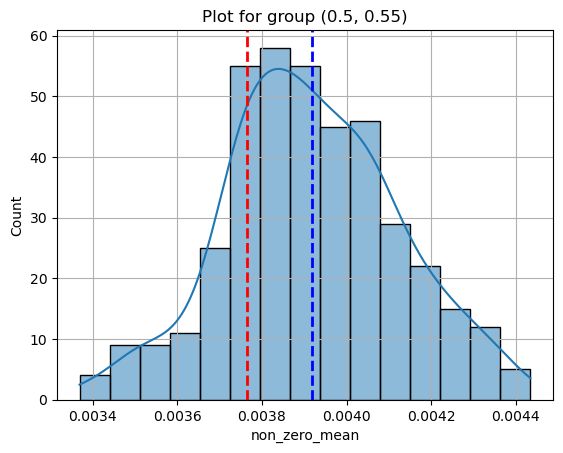

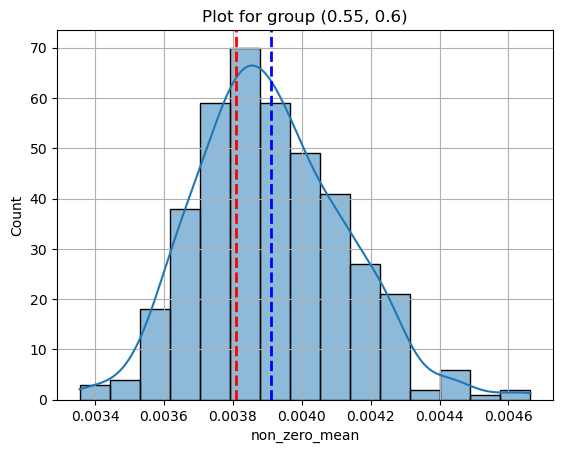

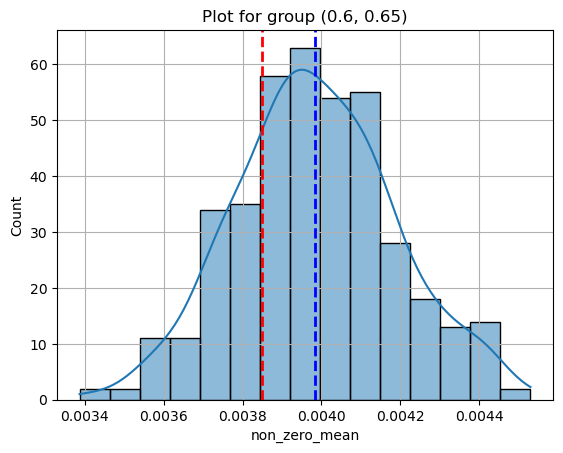

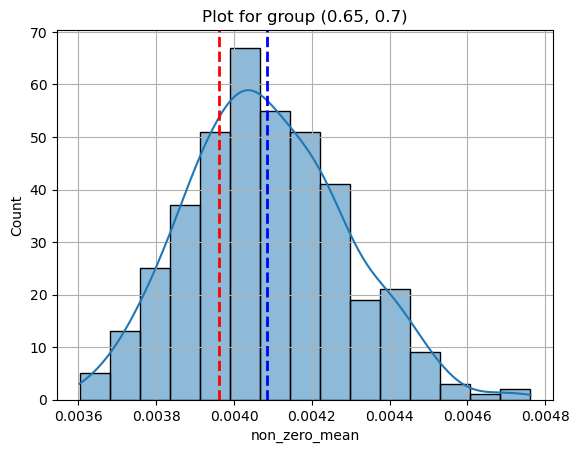

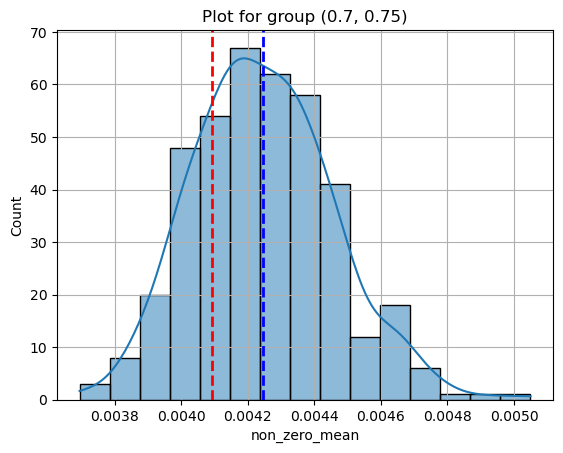

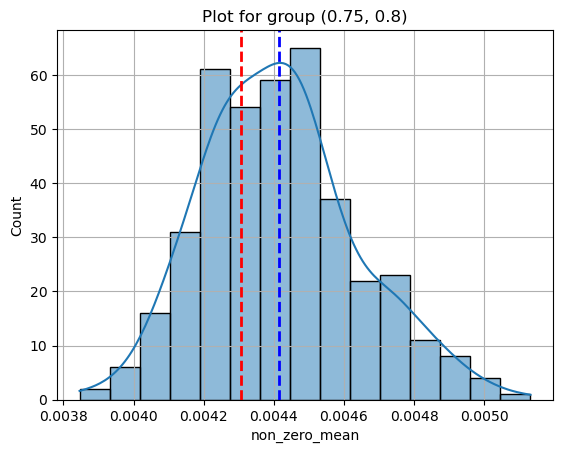

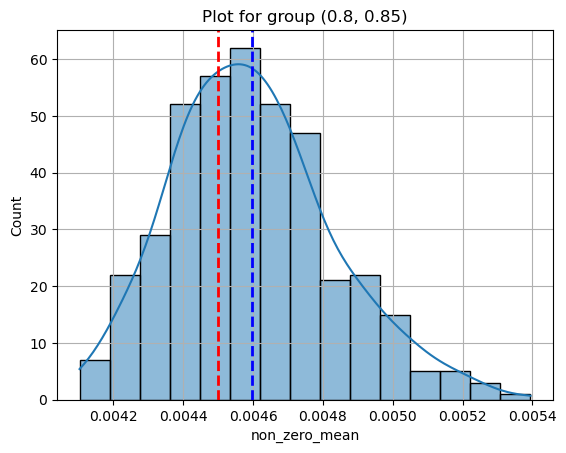

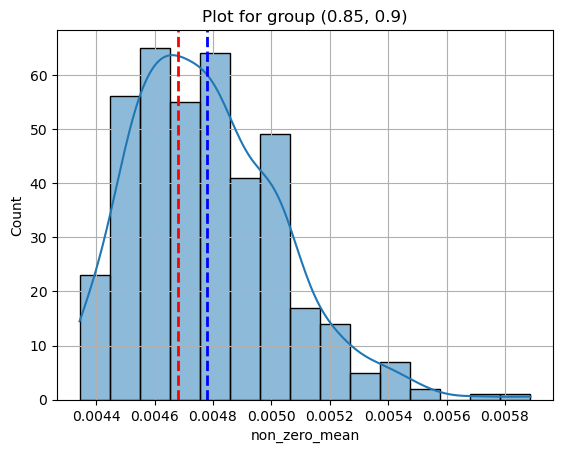

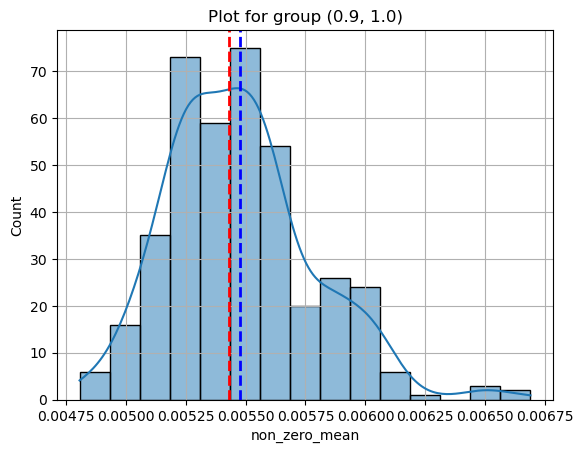

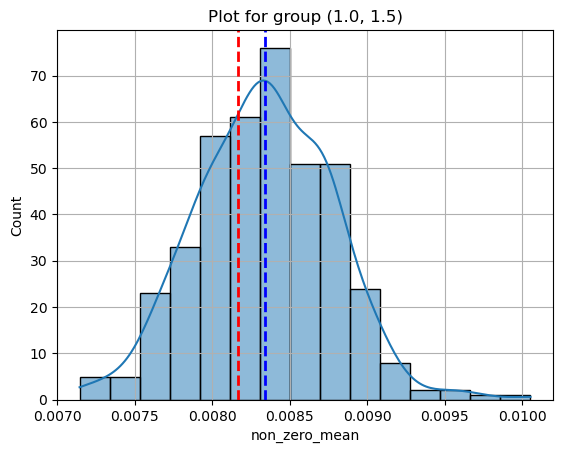

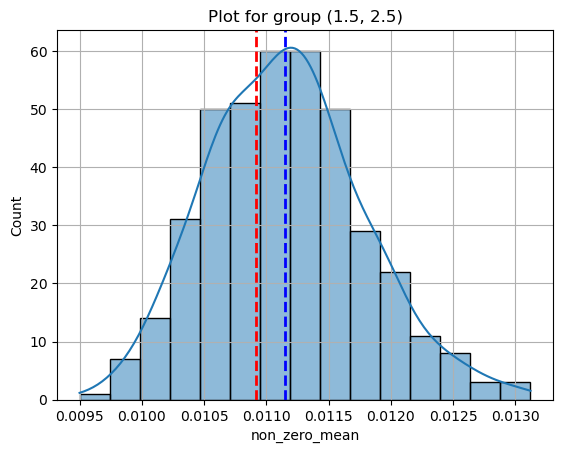

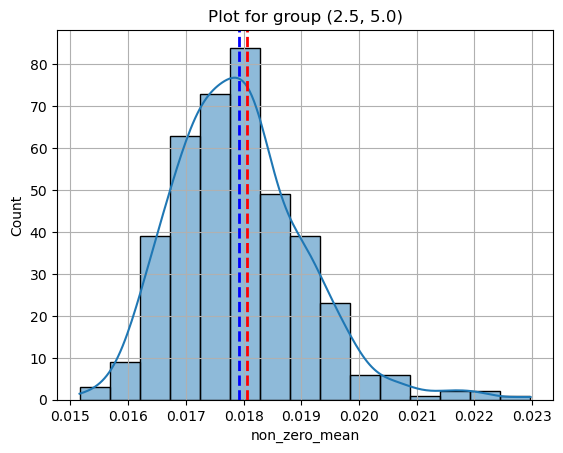

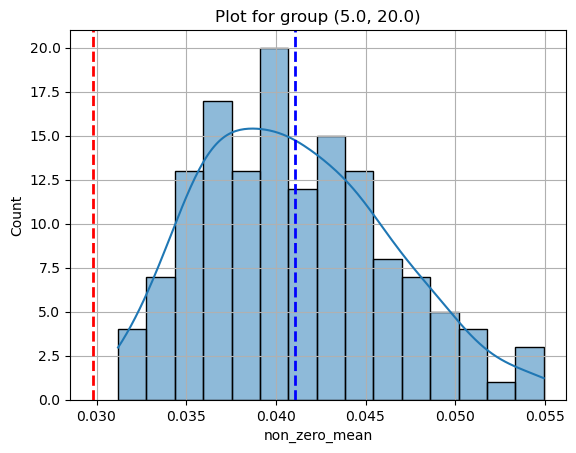

In [104]:
i = 0
for name, group in gg:
    plt.figure()
    sns.histplot(group['non_zero_mean'],bins = 15,kde = True)
    plt.title(f'Plot for group {name}')
    plt.axvline(x=true_list[i]/(1-group['p_0'].mean()), color='red', linestyle='--', linewidth=2)
    plt.axvline(x=group['non_zero_mean'].mean(),color = 'blue',linestyle = '--', linewidth=2)

    i += 1
    plt.grid(True)
    plt.show()

In [122]:
from one_population_data import simulate
N = [4000]
L =  [0.85,0.9,0.95,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,7,8,9,10] 
final_data = pd.DataFrame(columns = ['u','v','total_mean','non_zero_mean','p_0'])

for _ in range(400):
    ibd = simulate(N,L,2,1e7,10)
    data = pd.DataFrame(ibd)
    grouped = data.groupby(['u','v'])
    for name, group in grouped:
        u = name[0]
        v = name[1]
        total_mean = sum(group['fraction'])/len(group['fraction'])
        non_zero = [i for i in group['fraction'] if i > 0]
        p_0 = 1- (len(non_zero)/len(group['fraction']))
        if len(non_zero) ==0:
            sample_mean = 0
        else:
            sample_mean = sum(non_zero)/len(non_zero)
        new_data = [u,v,total_mean,sample_mean,p_0]
        final_data.loc[len(final_data)] = new_data

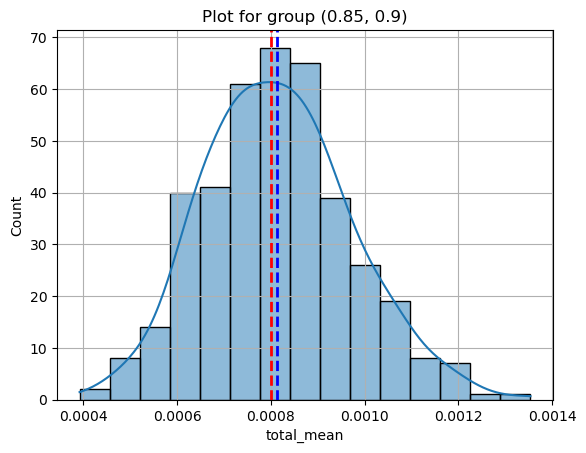

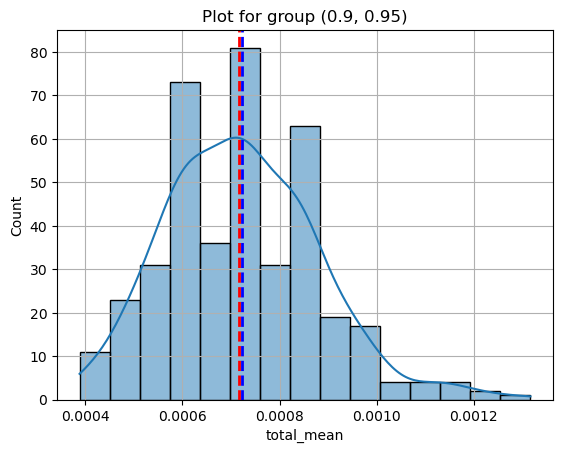

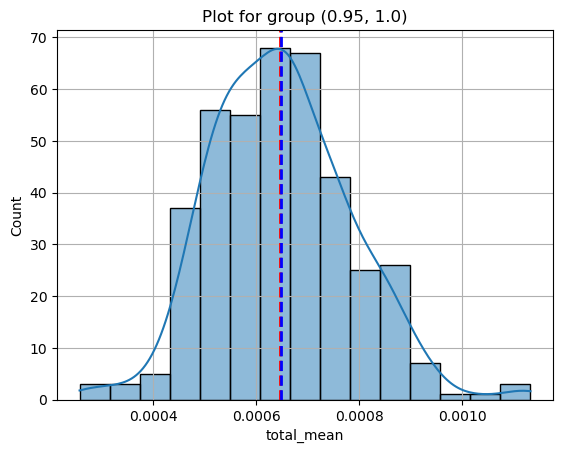

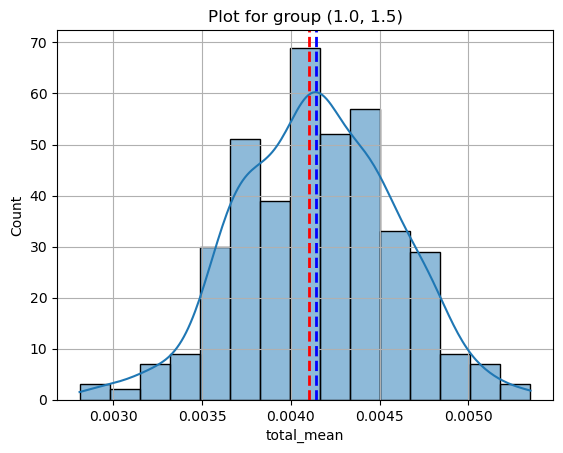

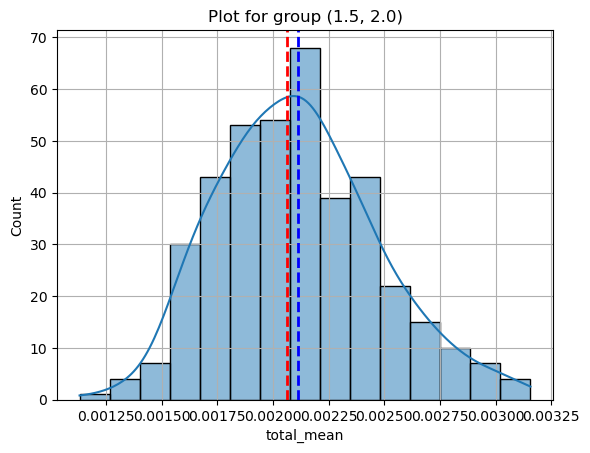

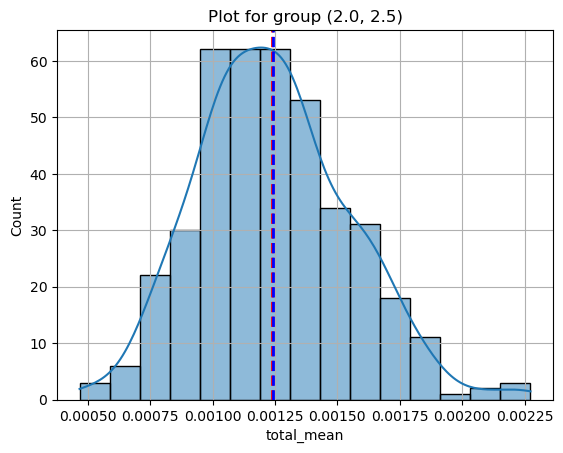

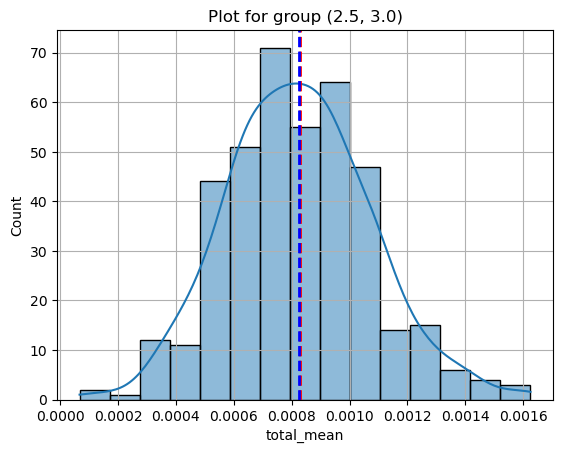

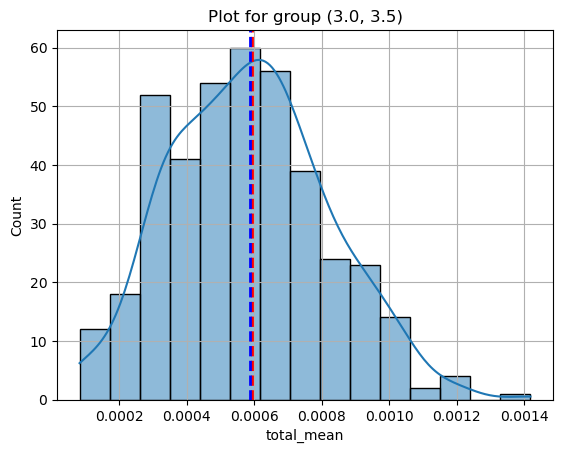

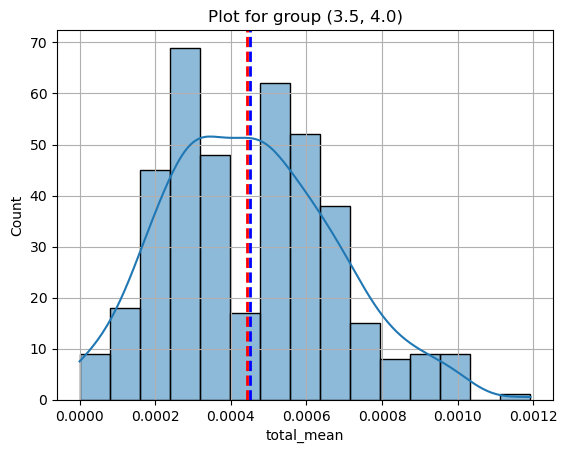

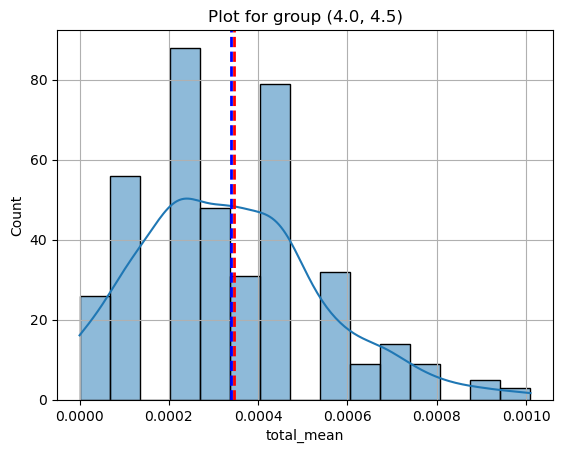

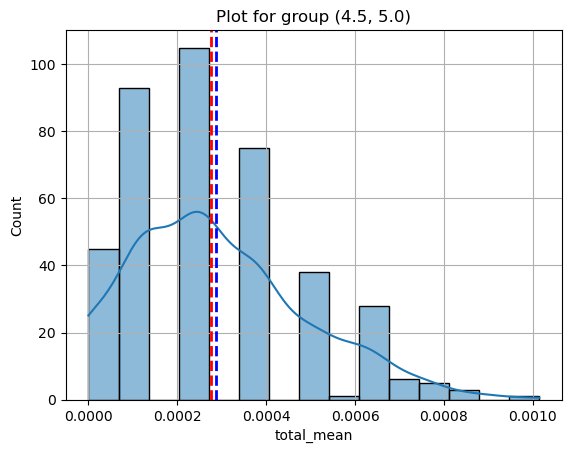

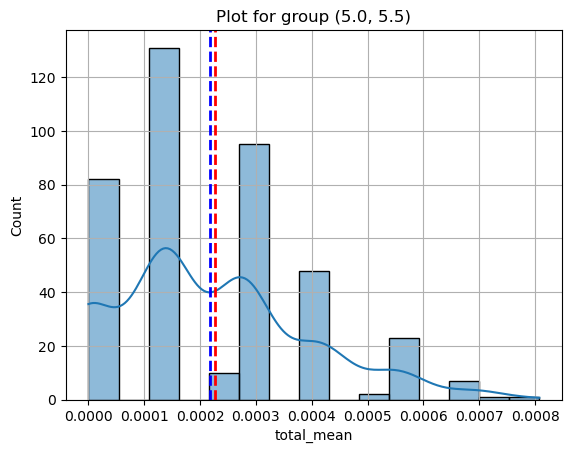

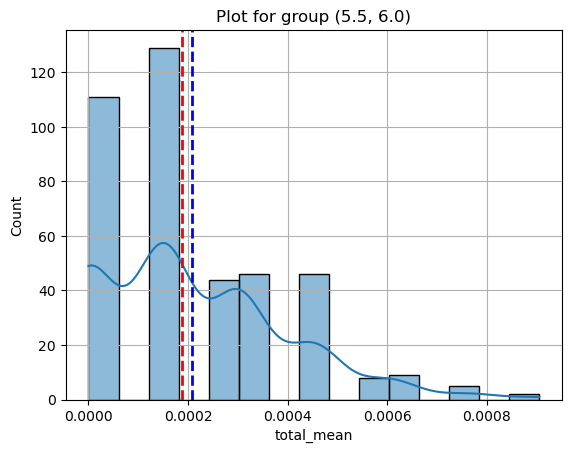

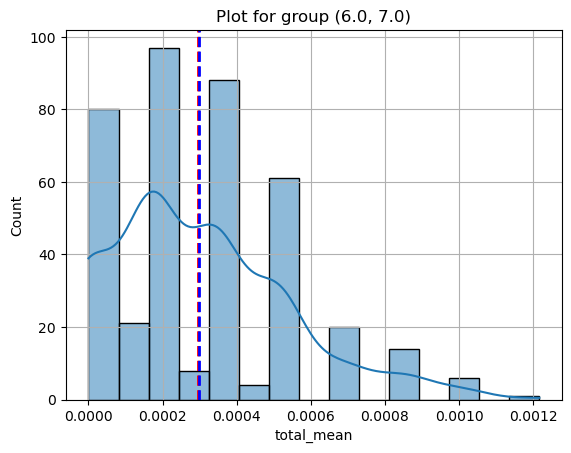

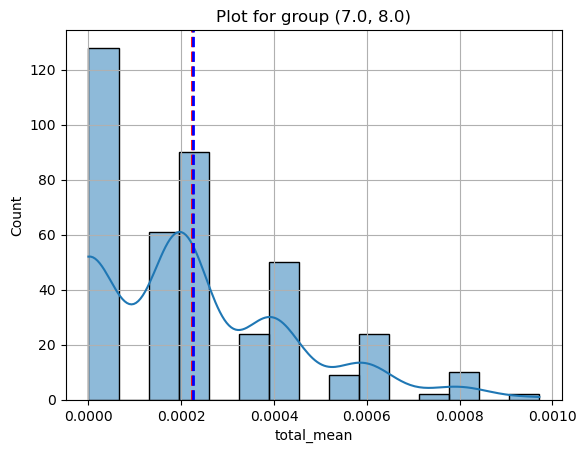

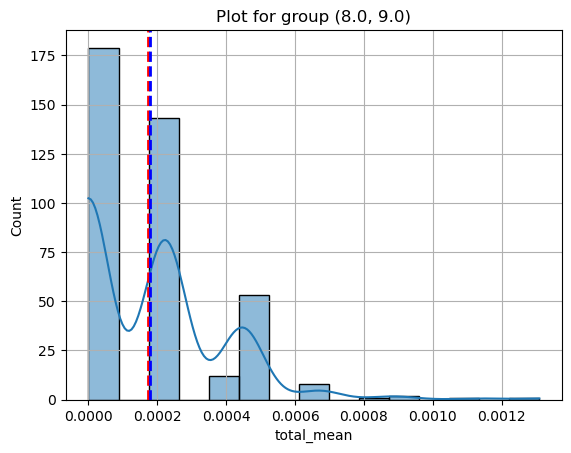

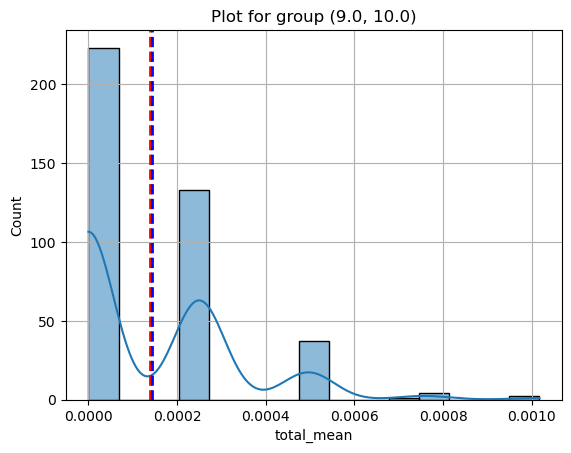

In [123]:
true_list = []
for a in range(len(L)-1):
    true_list.append(int_p_L(8000,0,10000000,L[a],L[a+1]))
gg = final_data.groupby(['u','v'])
i = 0
for name, group in gg:
    plt.figure()
    sns.histplot(group['total_mean'],bins = 15,kde = True)
    plt.title(f'Plot for group {name}')
    plt.axvline(x=true_list[i], color='red', linestyle='--', linewidth=2)
    plt.axvline(x=group['total_mean'].mean(),color = 'blue',linestyle = '--', linewidth=2)
    i += 1
    plt.grid(True)
    plt.show()


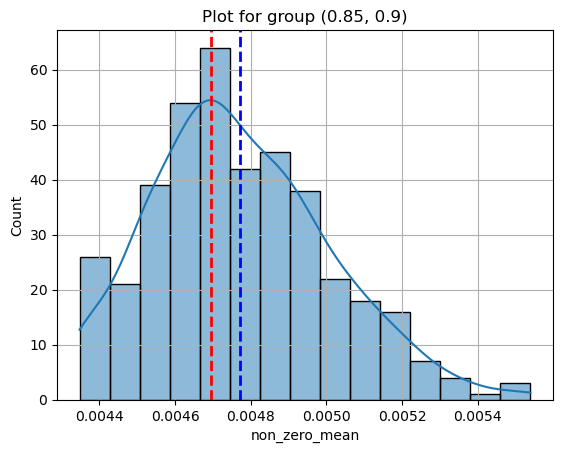

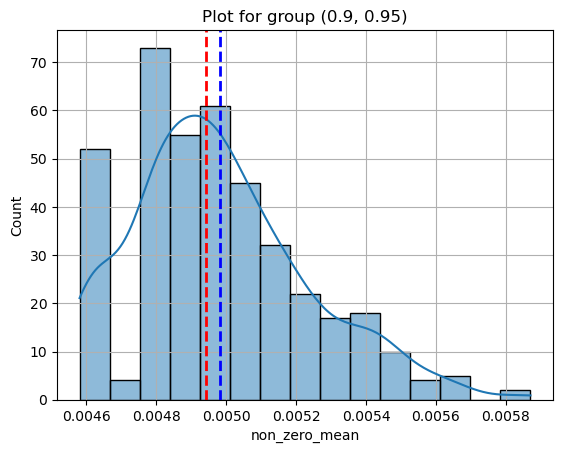

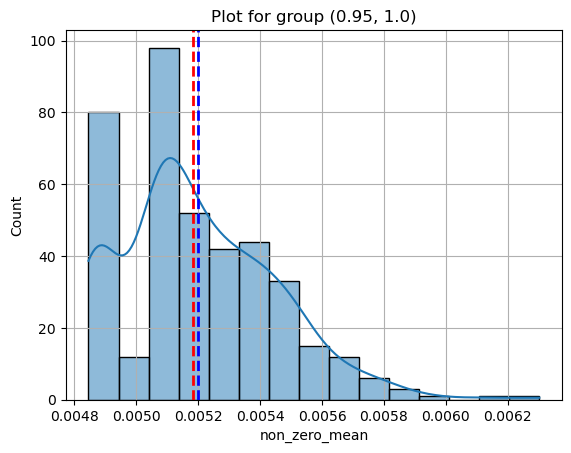

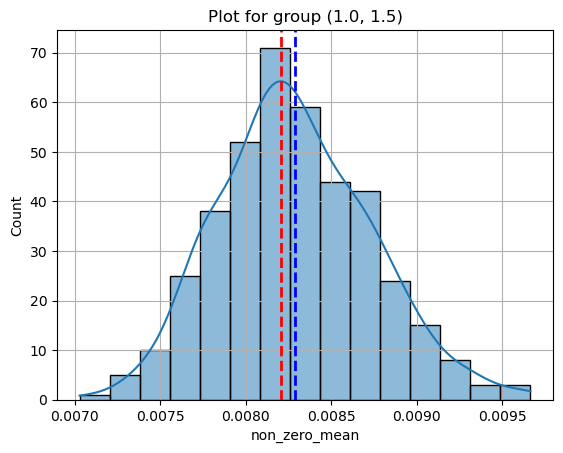

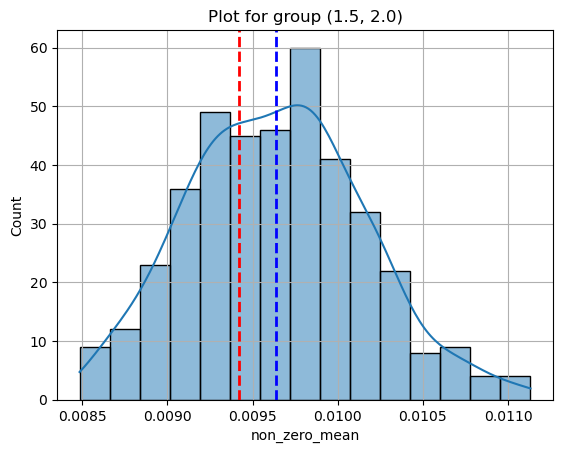

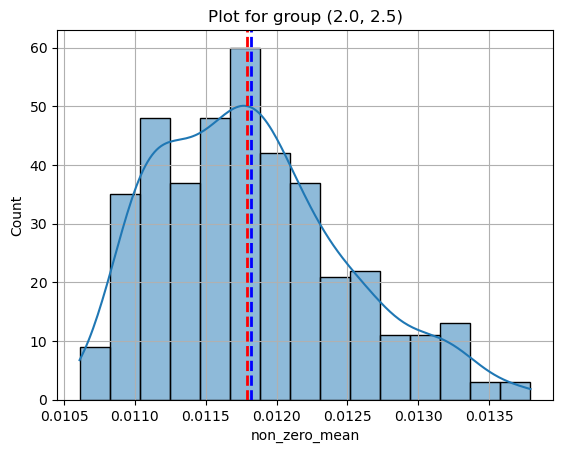

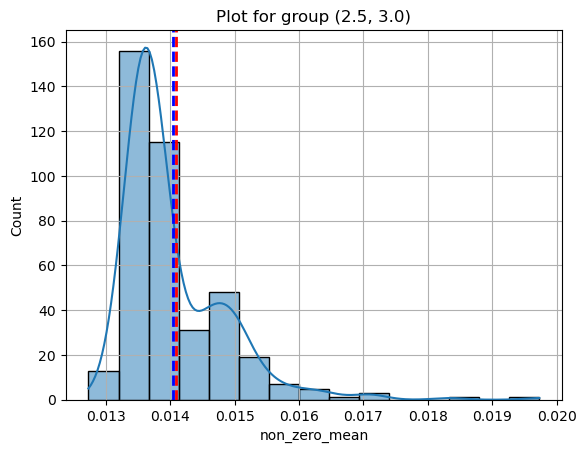

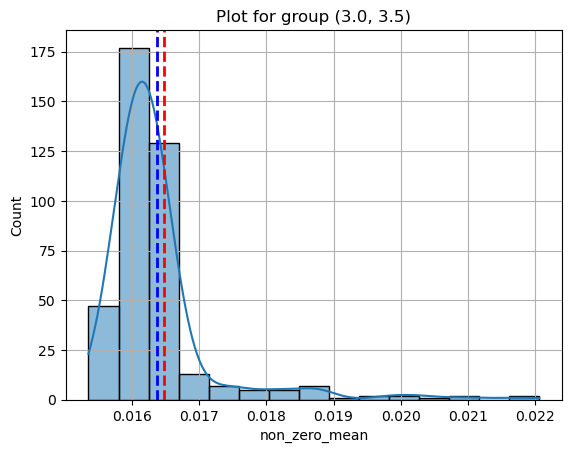

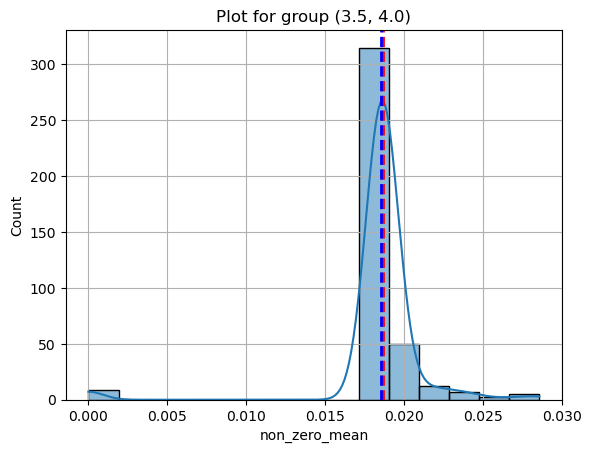

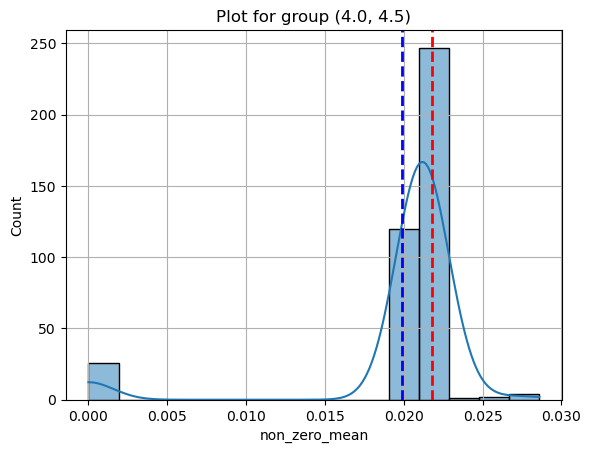

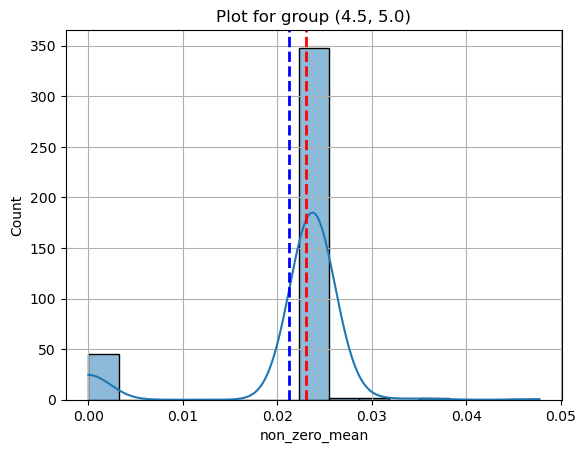

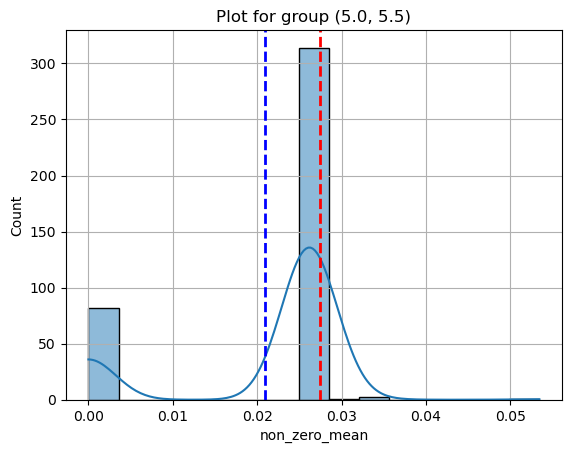

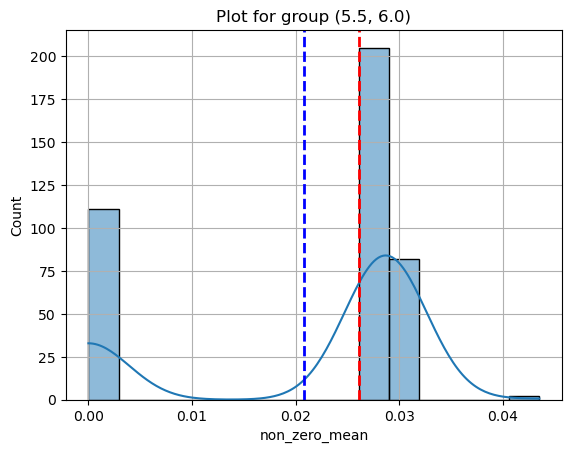

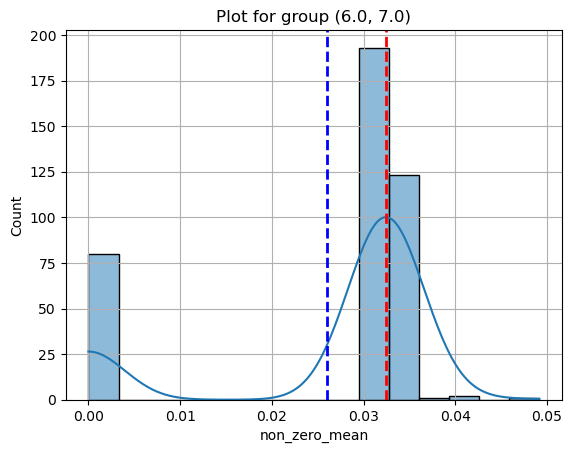

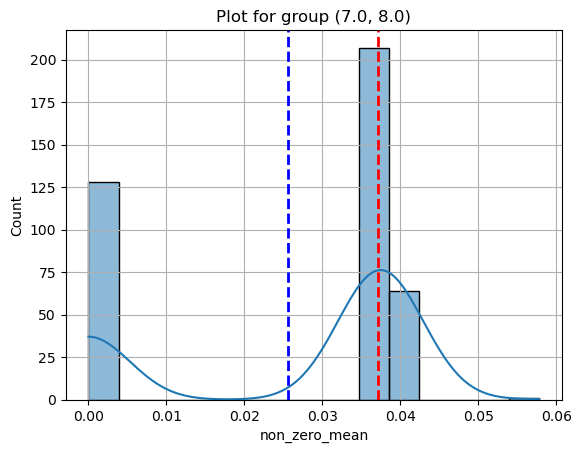

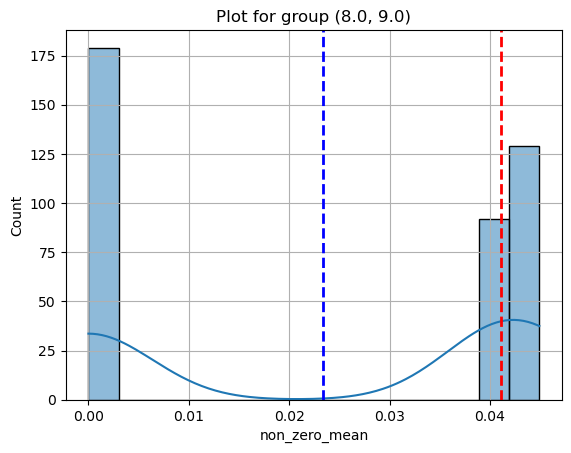

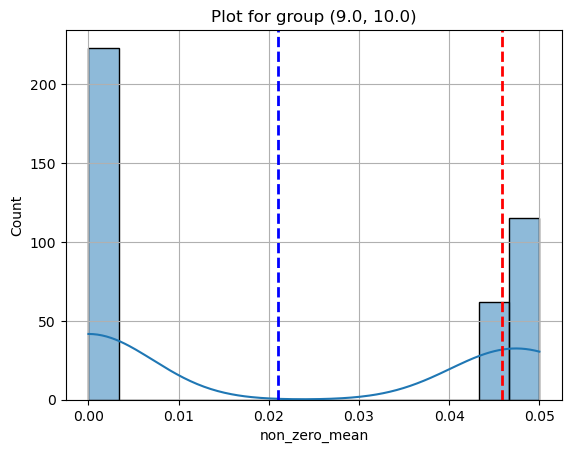

In [124]:
i = 0
for name, group in gg:
    plt.figure()
    sns.histplot(group['non_zero_mean'],bins = 15,kde = True)
    plt.title(f'Plot for group {name}')
    plt.axvline(x=true_list[i]/(1-group['p_0'].mean()), color='red', linestyle='--', linewidth=2)
    plt.axvline(x=group['non_zero_mean'].mean(),color = 'blue',linestyle = '--', linewidth=2)

    i += 1
    plt.grid(True)
    plt.show()

In [5]:
from one_population_data import simulate2
N = [4000]
L =  [0.7,0.75,0.8,0.85,0.9,0.95,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,7,8,10] 
T = 50
cross_data = pd.DataFrame(columns = ['u','v','total_mean','non_zero_mean','p_0'])

for _ in range(200):
    ibd = simulate2(N,T,L,2,1e7,10)
    data = pd.DataFrame(ibd)
    grouped = data.groupby(['u','v'])
    for name, group in grouped:
        u = name[0]
        v = name[1]
        total_mean = sum(group['fraction'])/len(group['fraction'])
        non_zero = [i for i in group['fraction'] if i > 0]
        p_0 = 1- (len(non_zero)/len(group['fraction']))
        if len(non_zero) ==0:
            sample_mean = 0
        else:
            sample_mean = sum(non_zero)/len(non_zero)
        new_data = [u,v,total_mean,sample_mean,p_0]
        cross_data.loc[len(cross_data)] = new_data

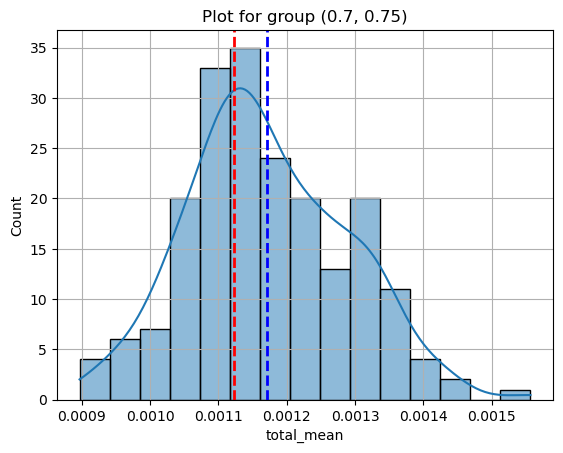

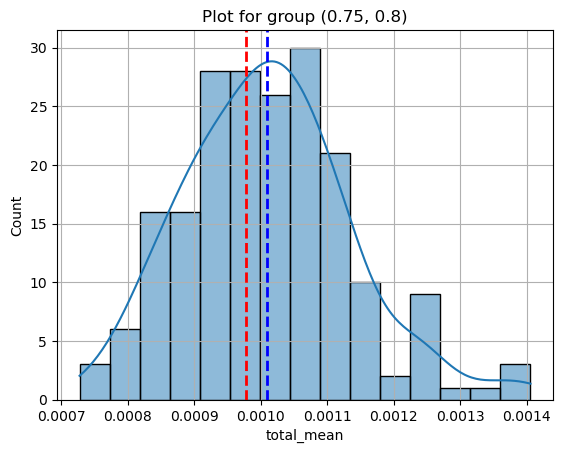

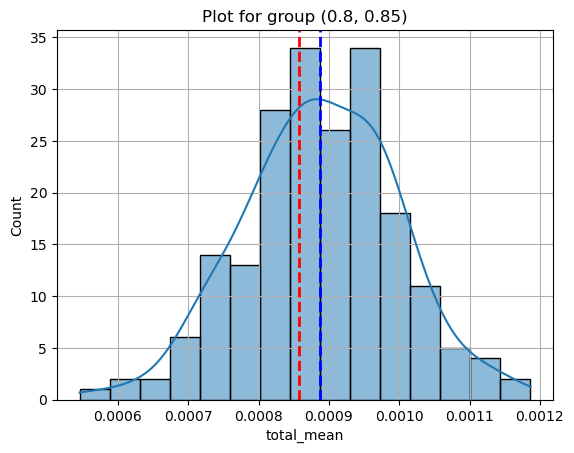

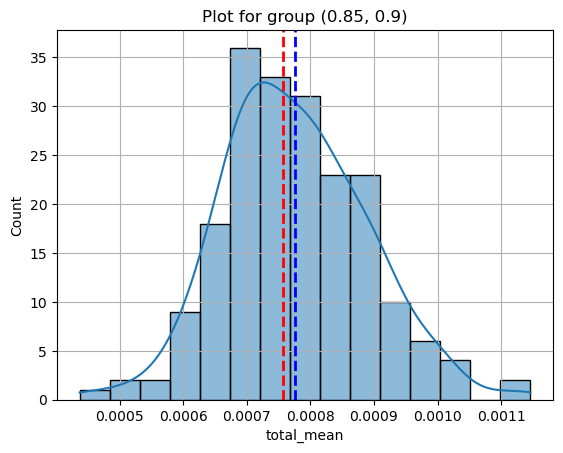

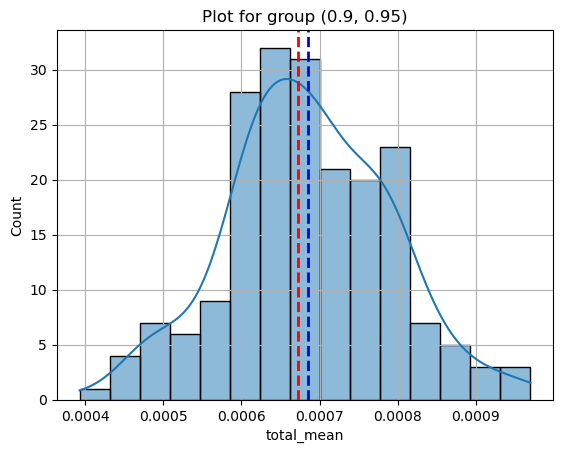

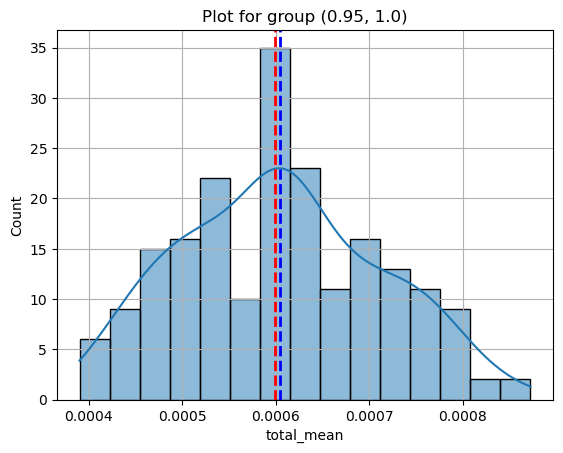

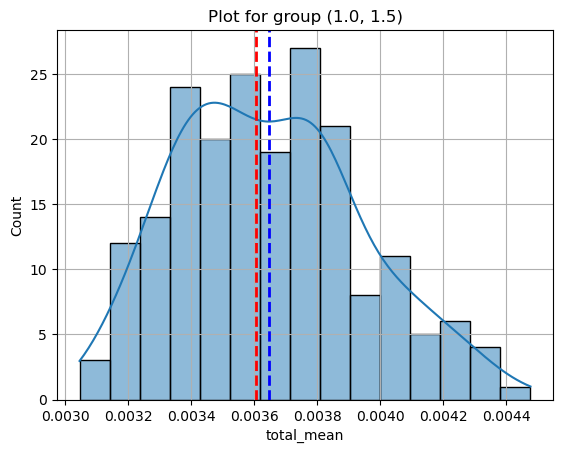

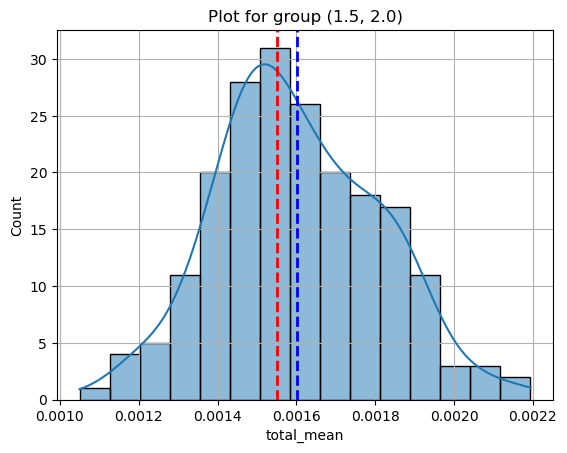

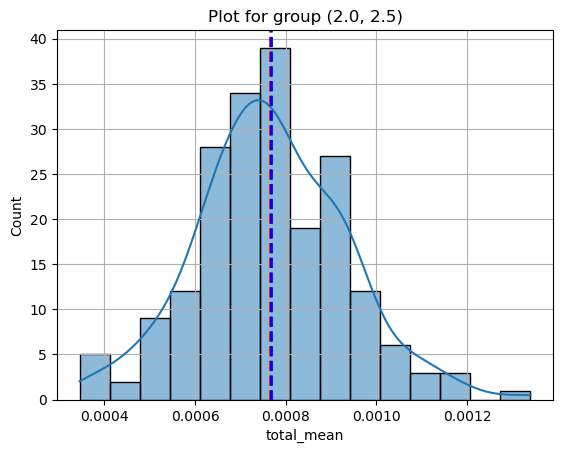

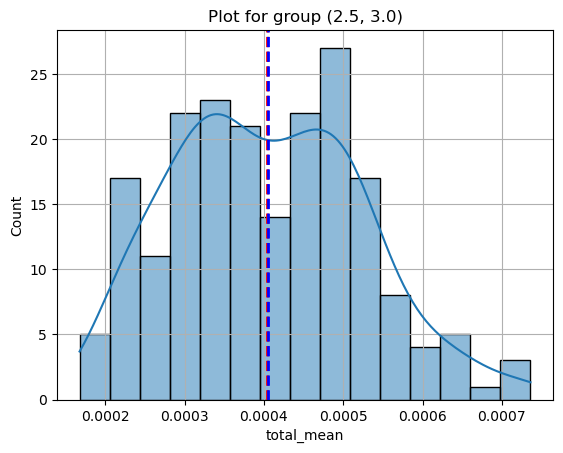

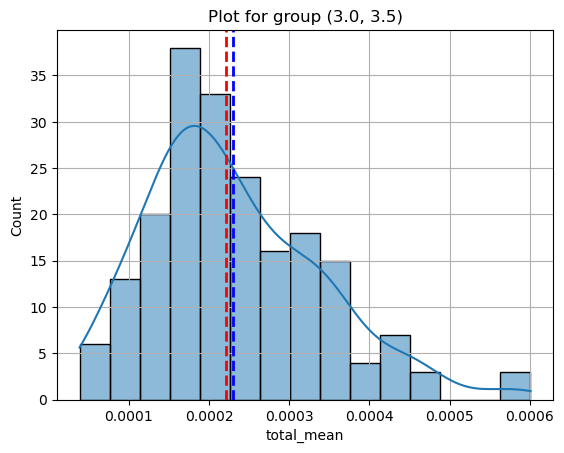

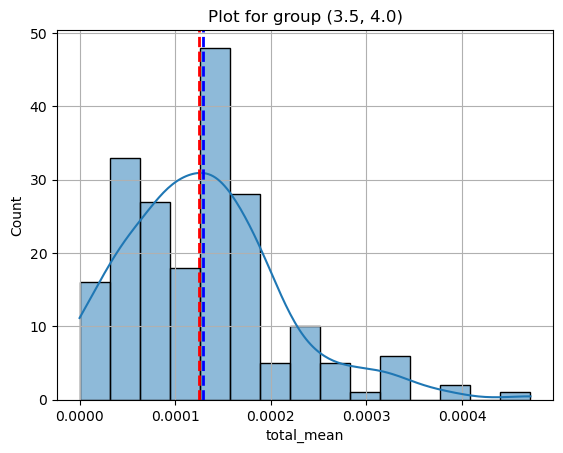

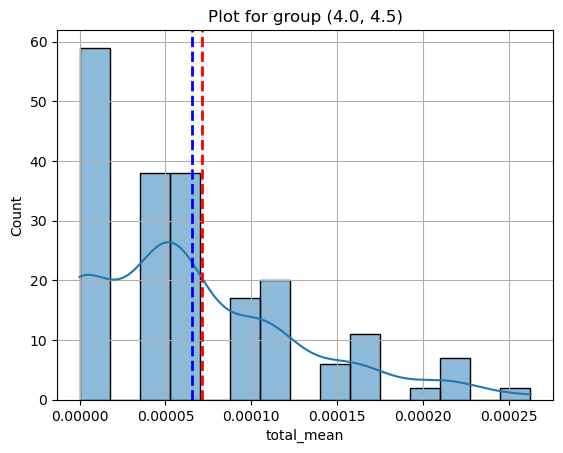

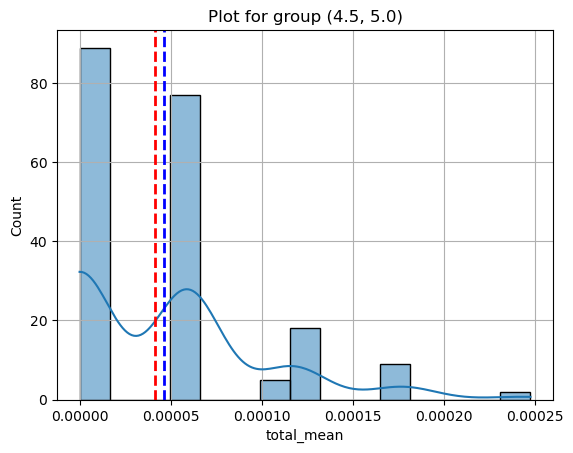

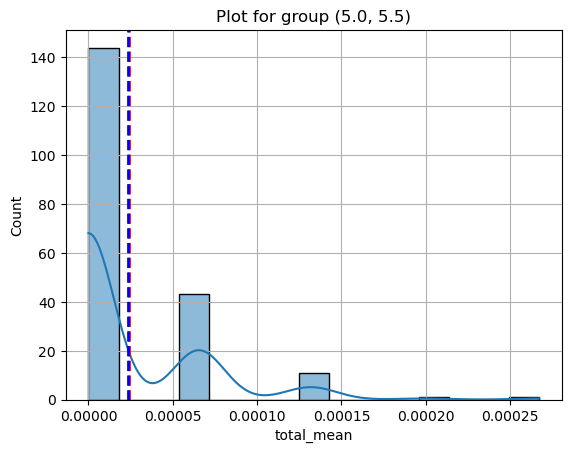

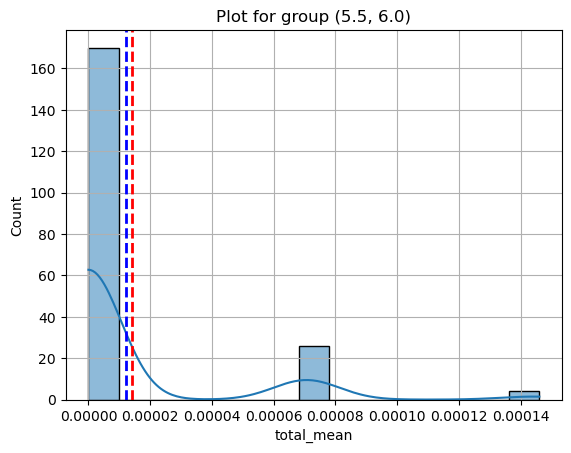

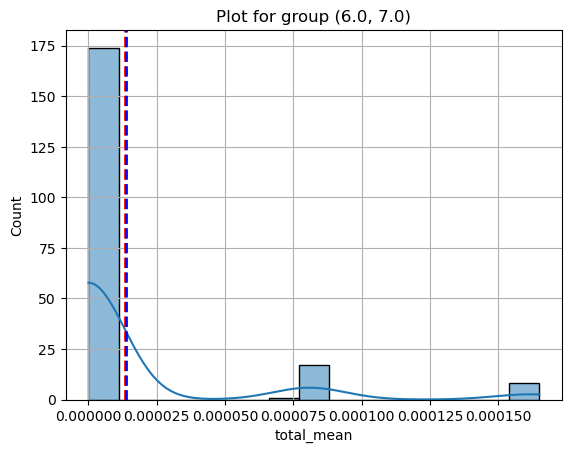

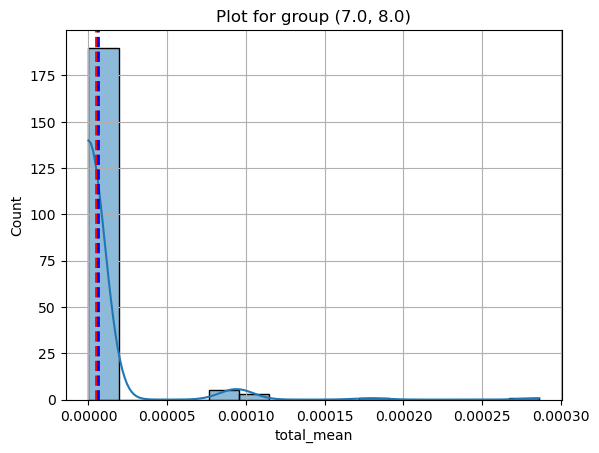

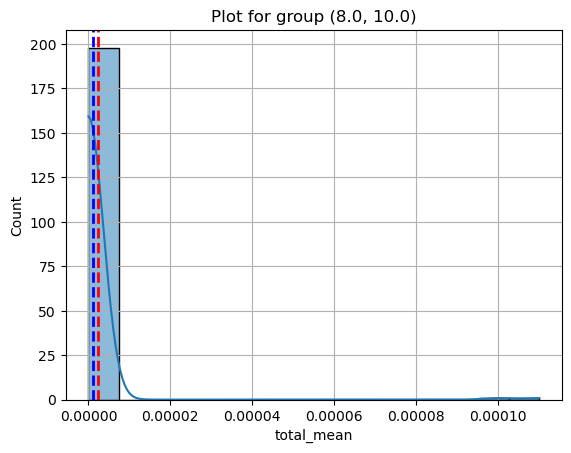

In [18]:
true_list = []
for a in range(len(L)-1):
    true_list.append(np.exp(50/8000) * int_p_L(8000,50,10000000,L[a],L[a+1]))
cross_gg = cross_data.groupby(['u','v'])
i = 0
for name, group in cross_gg:
    plt.figure()
    sns.histplot(group['total_mean'],bins = 15,kde = True)
    plt.title(f'Plot for group {name}')
    plt.axvline(x=true_list[i], color='red', linestyle='--', linewidth=2)
    plt.axvline(x=group['total_mean'].mean(),color = 'blue',linestyle = '--', linewidth=2)
    i += 1
    plt.grid(True)
    plt.show()